<a href="https://colab.research.google.com/github/AryanSinha0809/first-contributions/blob/main/CNN_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/fchollet/ARC-AGI.git

Cloning into 'ARC-AGI'...
remote: Enumerating objects: 1274, done.
remote: Counting objects: 100% (305/305), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 1274 (delta 192), reused 198 (delta 175), pack-reused 969 (from 1)
Receiving objects: 100% (1274/1274), 499.71 KiB | 7.69 MiB/s, done.
Resolving deltas: 100% (725/725), done.


In [ ]:
folder_path = '/content/ARC-AGI/data'

In [ ]:
import os
files=os.listdir(folder_path)
print(files)

['evaluation', 'training']


In [ ]:
import numpy as np
import pandas as pd
import os
import json
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from matplotlib import colors

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, output_channels, kernel_size=1)
        self.relu = nn.ReLU()

    def forward(self, x, target_shape=None):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)

        # Upsample using interpolate if target_shape is provided
        if target_shape is not None:
            # Ensure target_shape has 2 spatial dimensions
            # by taking the last two elements
            spatial_dims = target_shape[-2:]
            x = F.interpolate(x, size=spatial_dims, mode='bilinear', align_corners=False)
        return x

In [ ]:
class ARCDataset(Dataset):
    def __init__(self, task, mode='train'):
        self.data = task[mode]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_grid = np.array(self.data[idx]['input'], dtype=np.float32)
        output_grid = np.array(self.data[idx]['output'], dtype=np.int64)
        return torch.tensor(input_grid).unsqueeze(0), torch.tensor(output_grid)


In [ ]:
def train_model(model, dataloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        total_pixels = 0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            # Pass target shape to the model's forward method
            outputs = model(inputs, target_shape=targets.shape)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # Compute accuracy
            preds = outputs.argmax(dim=1)  # Get the predicted class
            running_corrects += (preds == targets).sum().item()  # Correct pixel count
            total_pixels += targets.numel()  # Total pixel count
        epoch_acc = running_corrects / total_pixels  # Pixel-wise accuracy
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(dataloader)}, Accuracy: {epoch_acc:.4f}")

def predict_model(model, input_grid, target_shape):
    model.eval()
    with torch.no_grad():
        input_grid = torch.tensor(input_grid, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

        # Get target shape ensuring we provide 2 dimensions
        target_shape_interp = target_shape[:2] # Get the first two dimensions of the target shape for interpolation
        # Pass target shape to the model's forward method
        prediction = model(input_grid, target_shape=target_shape_interp)

        return prediction.argmax(dim=1).squeeze(0).cpu().numpy()

Epoch 1/10, Loss: 2.0366857051849365, Accuracy: 0.5481
Epoch 2/10, Loss: 1.6579960584640503, Accuracy: 0.7111
Epoch 3/10, Loss: 1.4209089040756226, Accuracy: 0.7111
Epoch 4/10, Loss: 1.302872085571289, Accuracy: 0.7111
Epoch 5/10, Loss: 1.1957077503204345, Accuracy: 0.7111
Epoch 6/10, Loss: 1.0828497648239135, Accuracy: 0.7111
Epoch 7/10, Loss: 1.0005139470100404, Accuracy: 0.7358
Epoch 8/10, Loss: 0.928068482875824, Accuracy: 0.7679
Epoch 9/10, Loss: 0.8812503695487977, Accuracy: 0.7852
Epoch 10/10, Loss: 0.828241491317749, Accuracy: 0.7926
Epoch 1/10, Loss: 1.9804414510726929, Accuracy: 0.7446
Epoch 2/10, Loss: 1.6251113653182983, Accuracy: 0.7446
Epoch 3/10, Loss: 1.2255770206451415, Accuracy: 0.7446
Epoch 4/10, Loss: 0.9182282090187073, Accuracy: 0.7446
Epoch 5/10, Loss: 0.6699486315250397, Accuracy: 0.7853
Epoch 6/10, Loss: 0.5060008049011231, Accuracy: 0.9293
Epoch 7/10, Loss: 0.401652193069458, Accuracy: 0.9334
Epoch 8/10, Loss: 0.329154771566391, Accuracy: 0.9334
Epoch 9/10, Lo

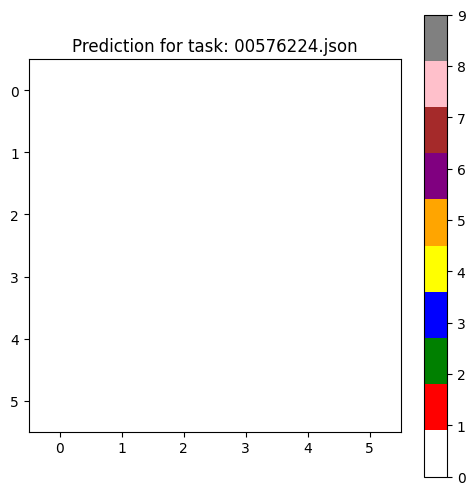

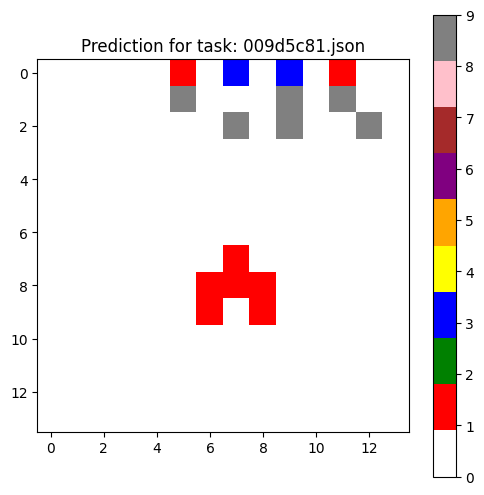

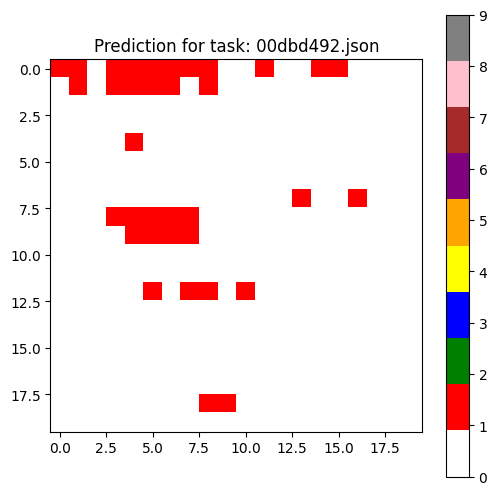

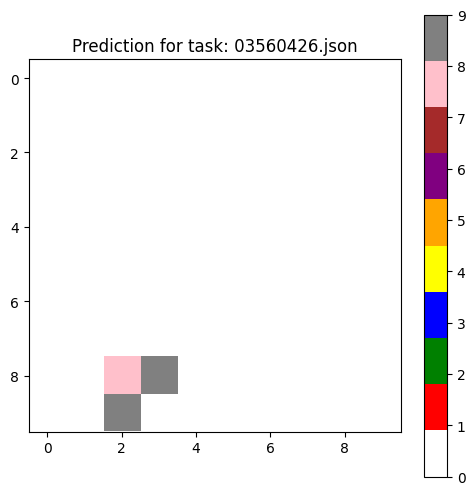

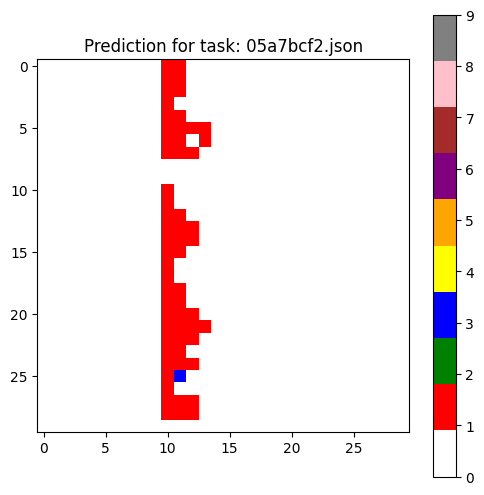

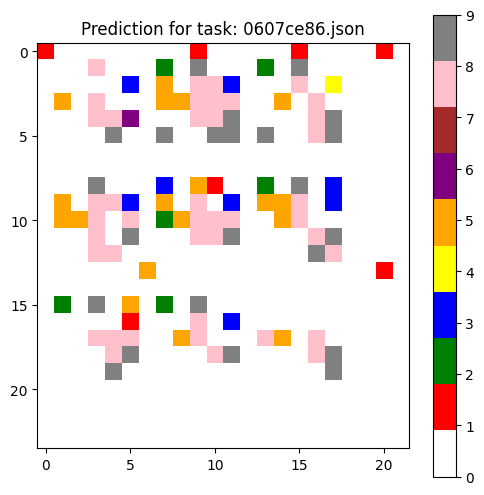

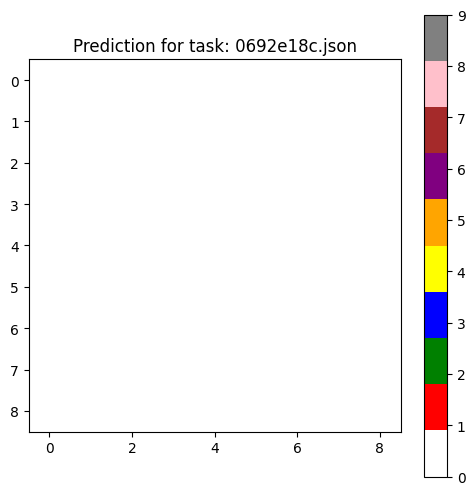

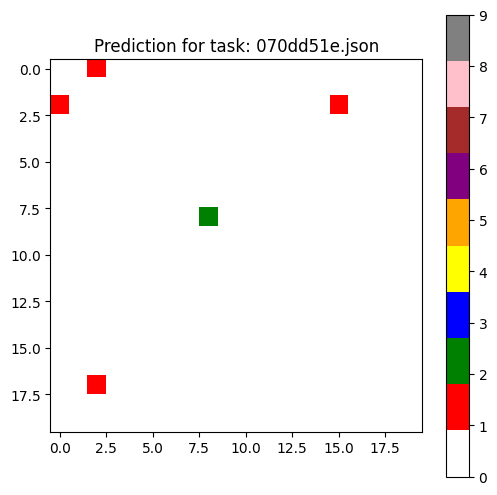

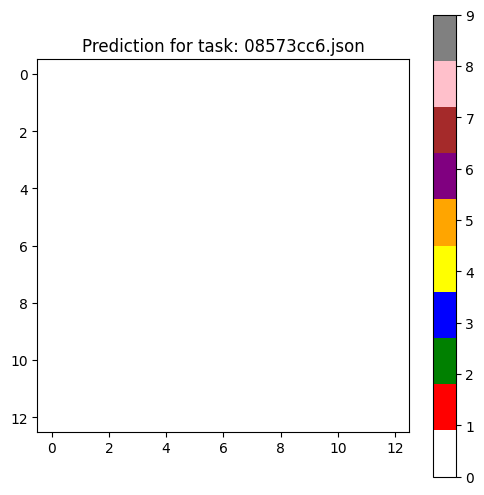

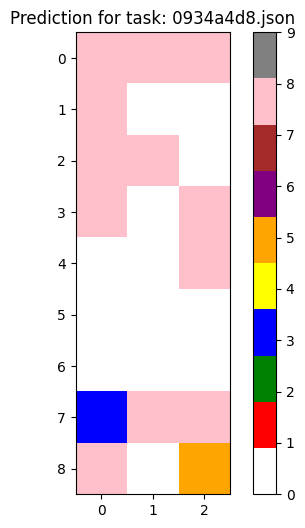

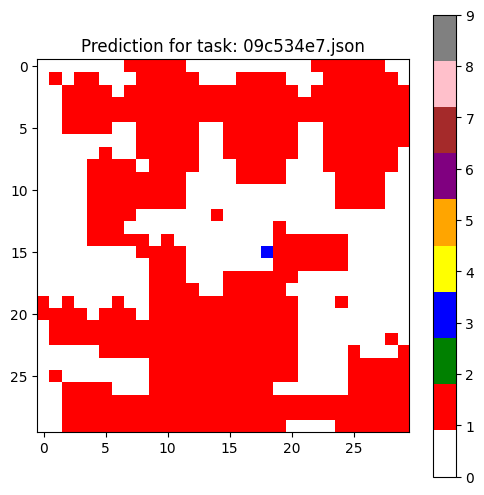

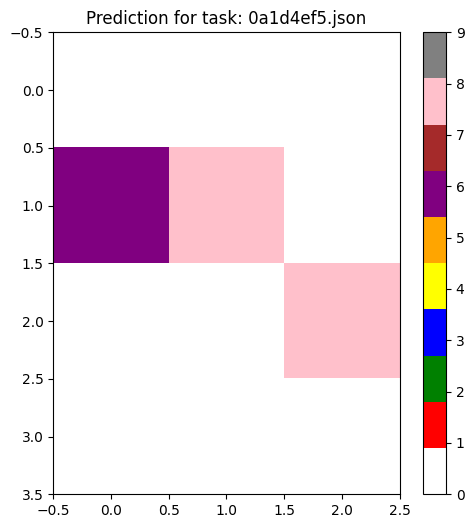

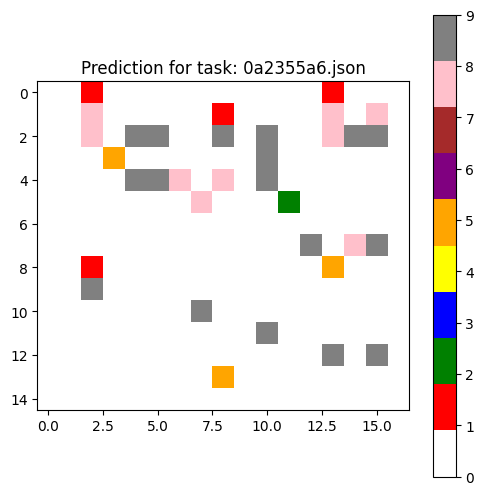

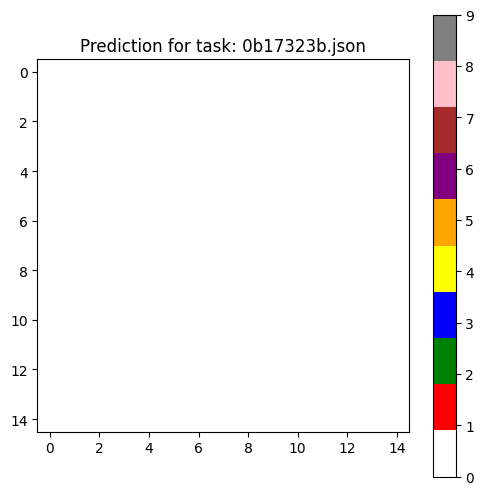

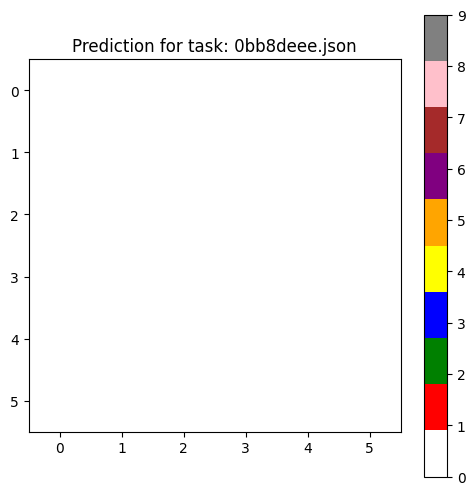

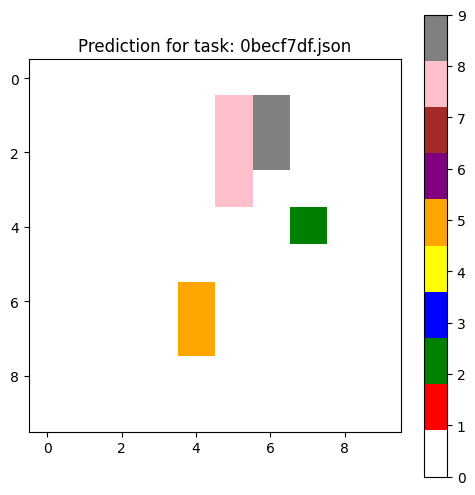

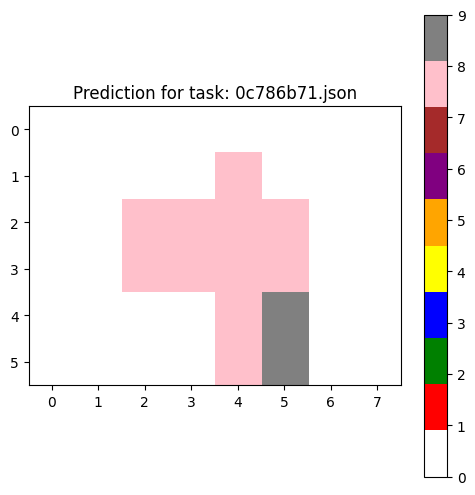

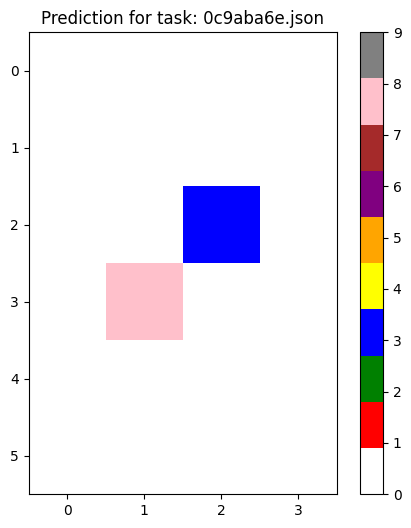

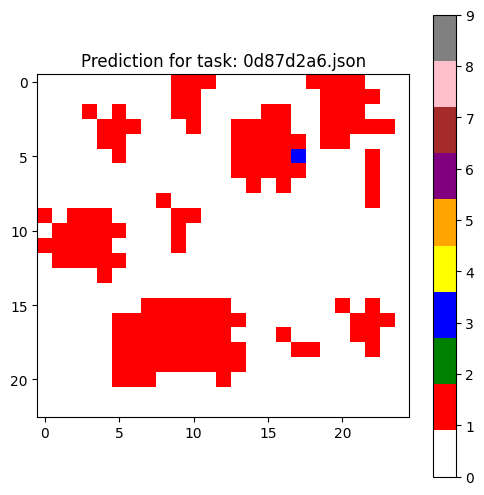

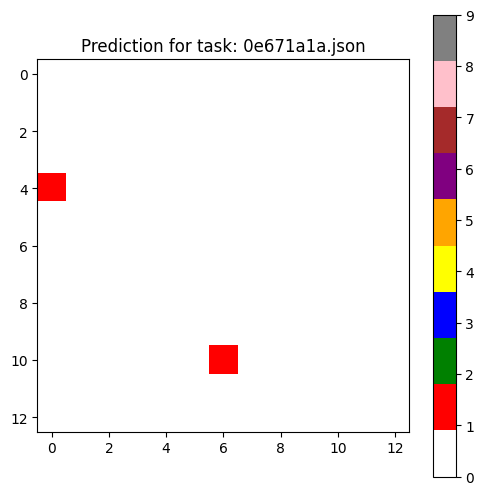

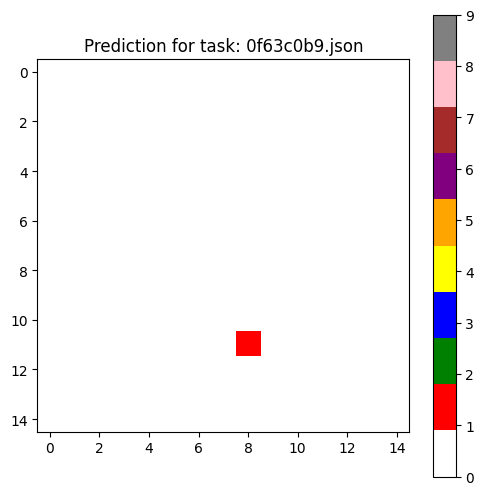

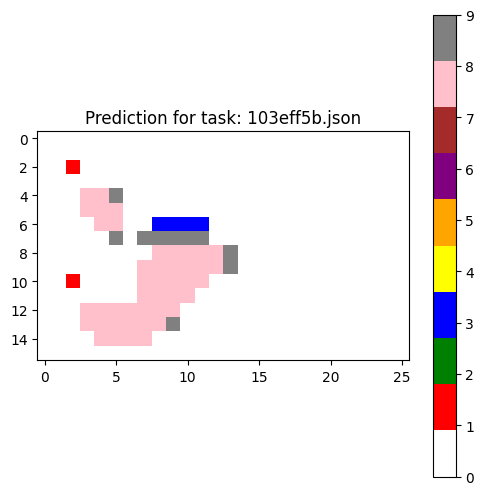

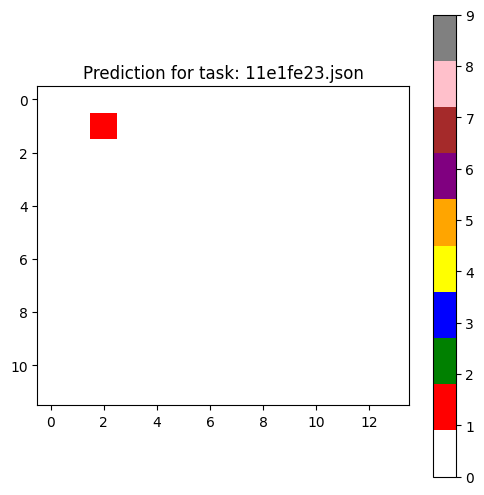

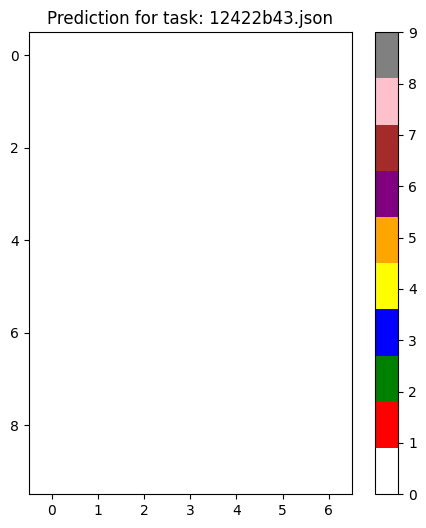

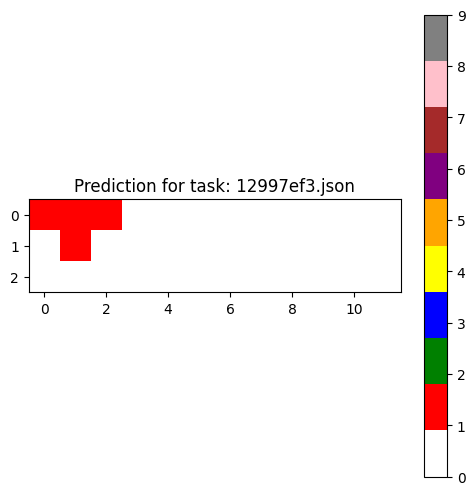

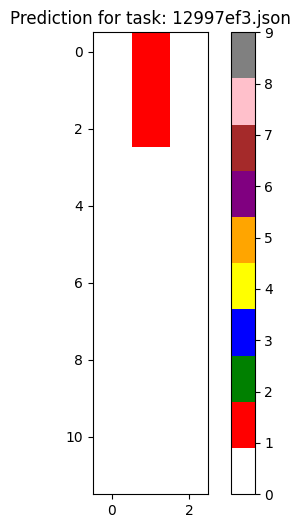

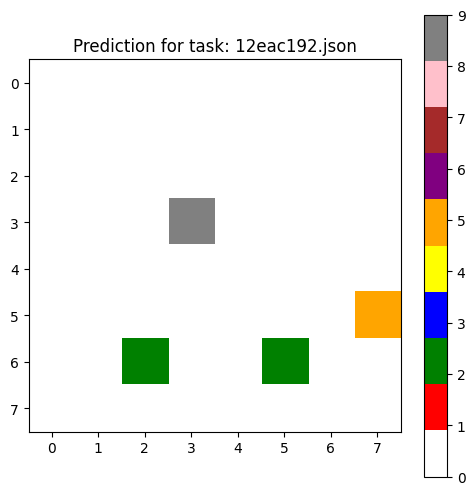

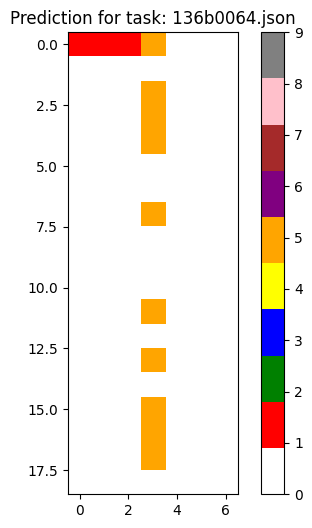

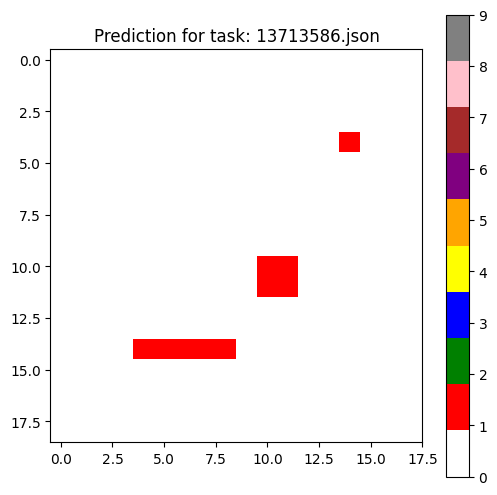

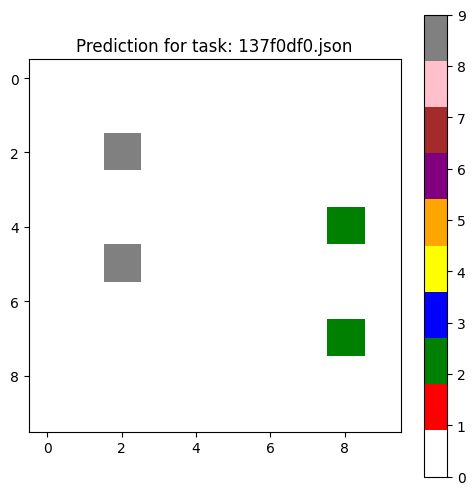

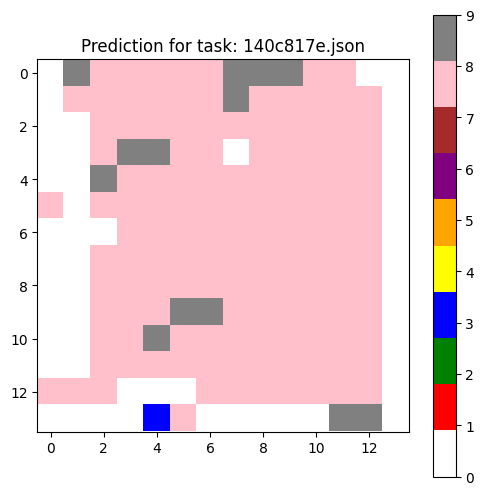

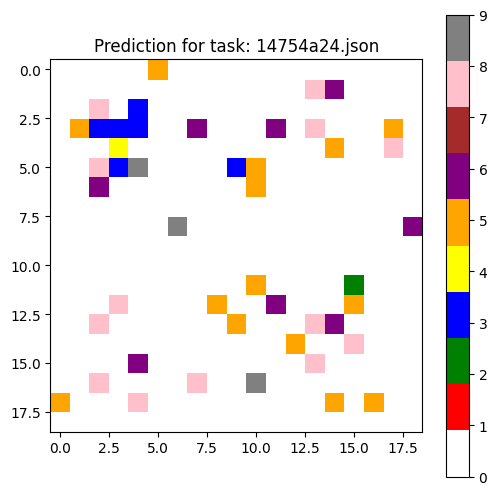

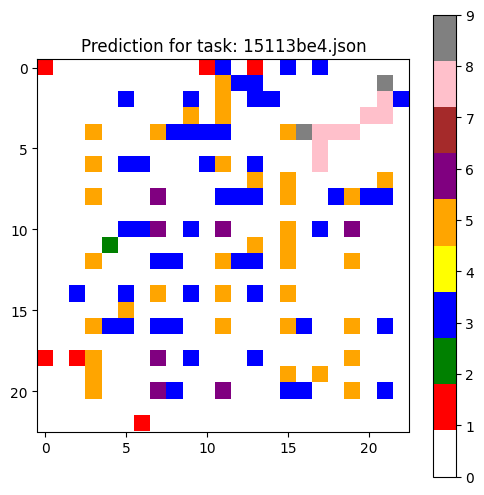

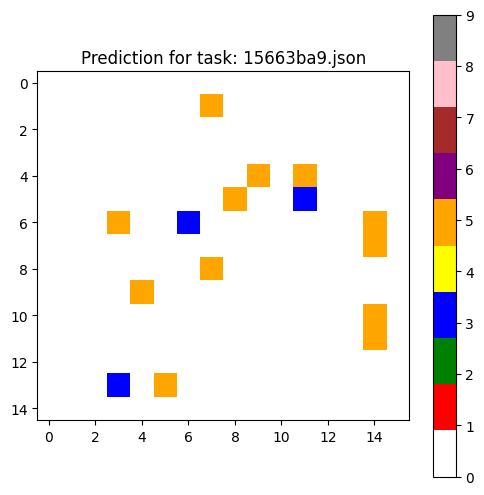

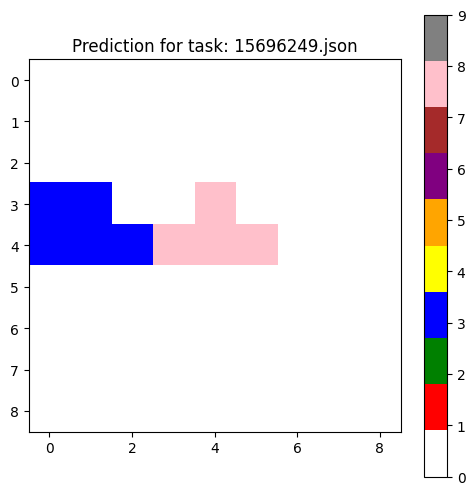

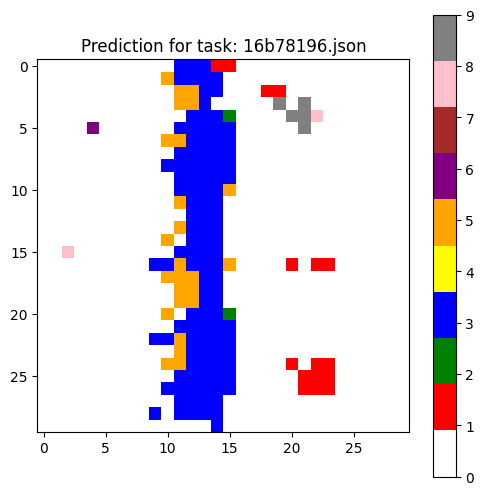

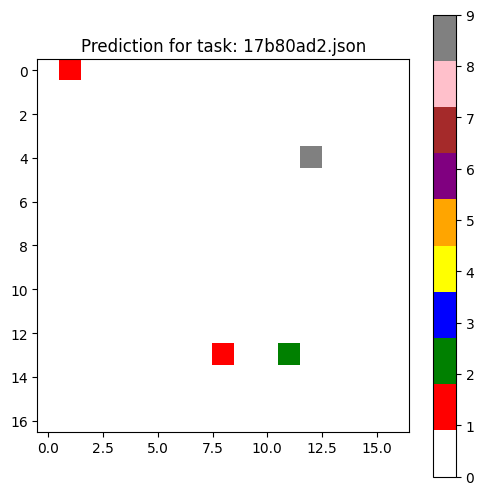

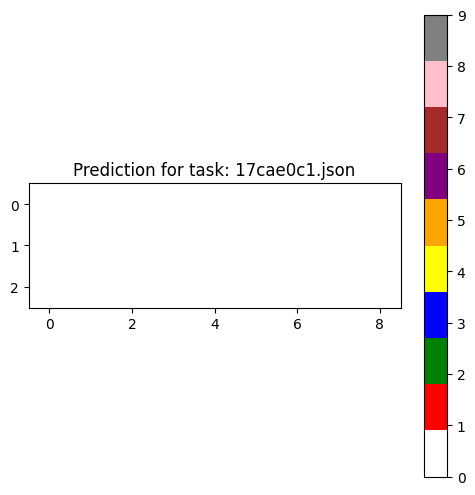

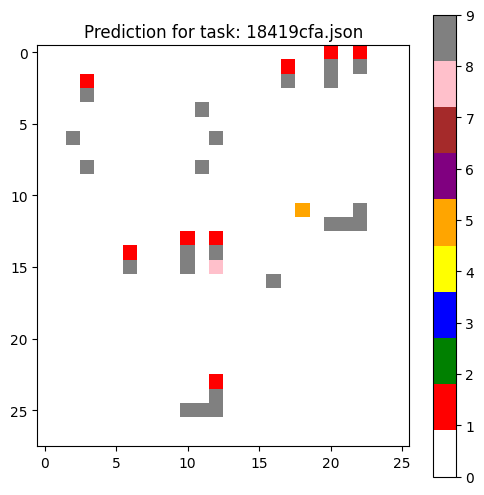

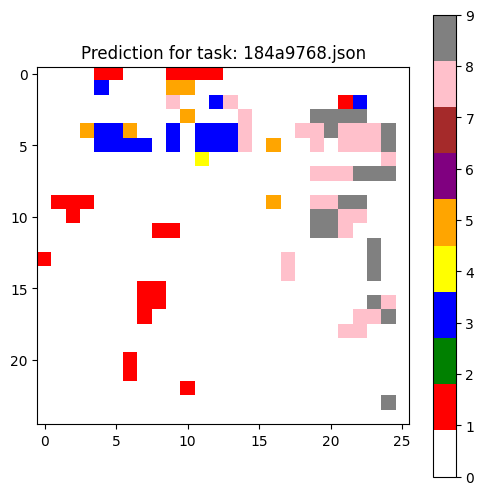

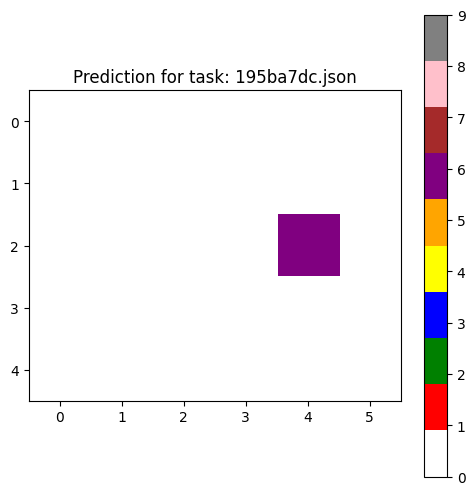

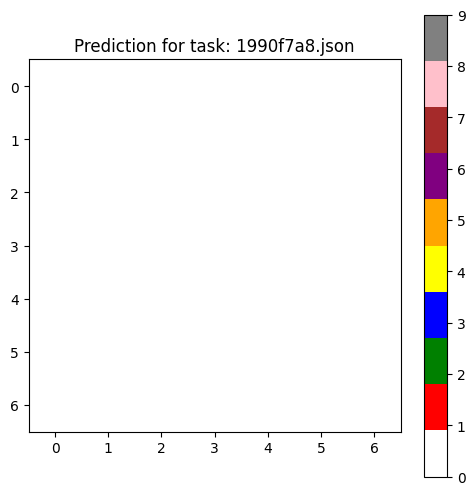

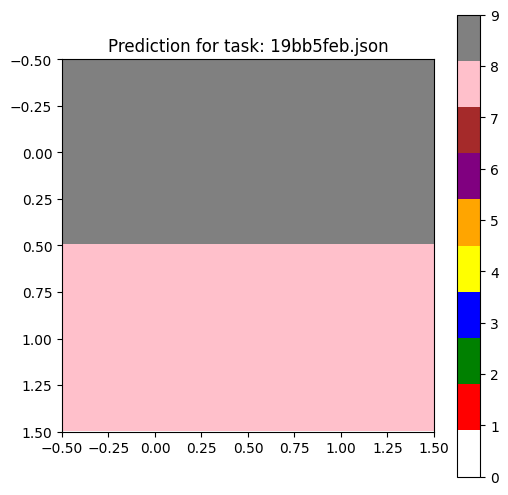

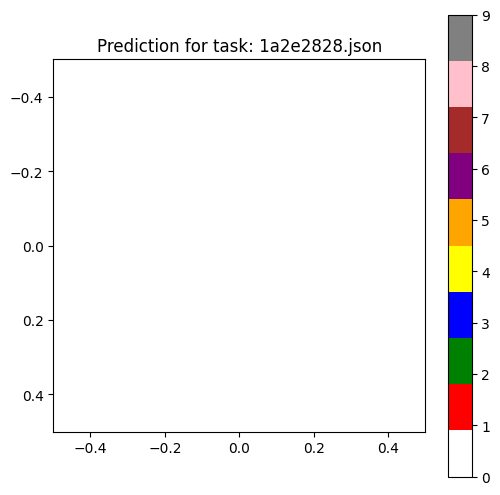

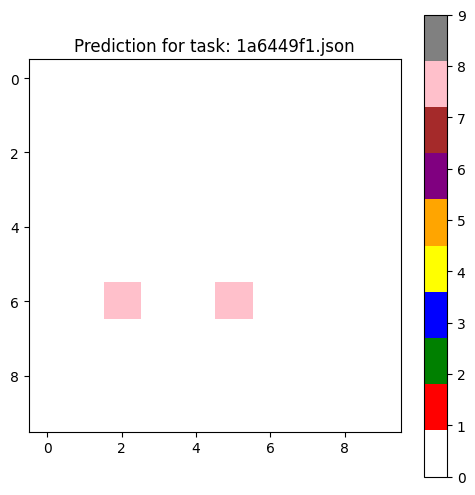

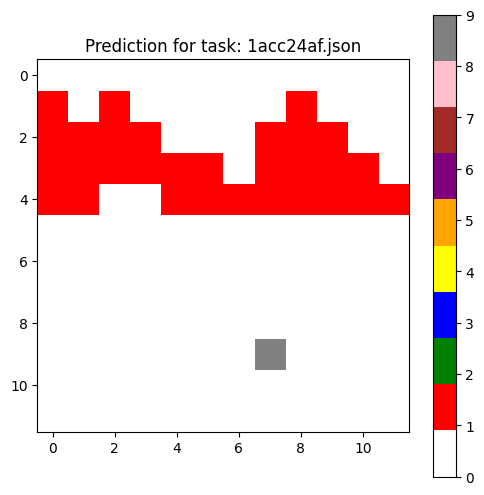

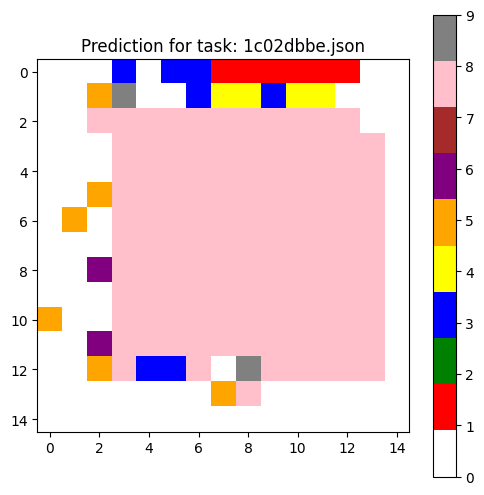

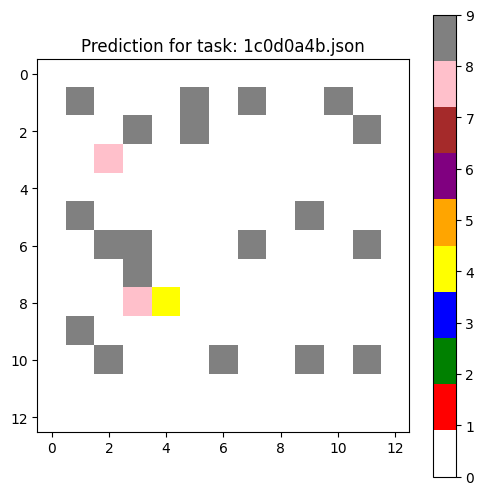

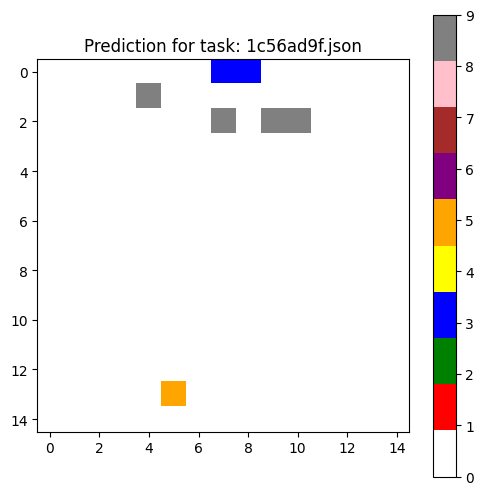

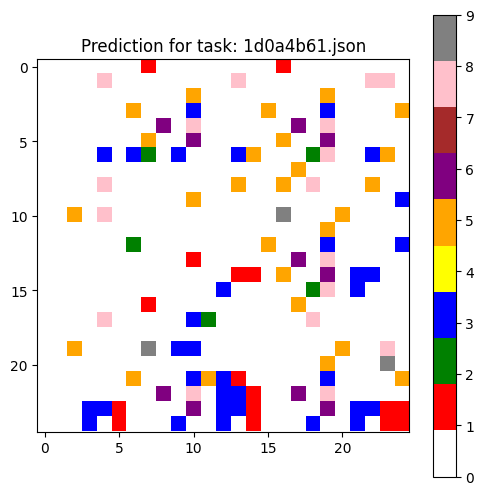

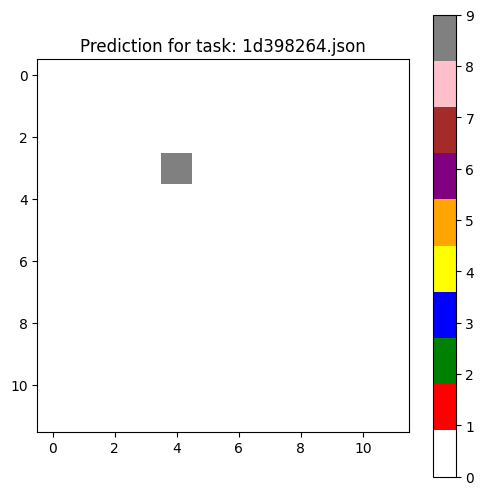

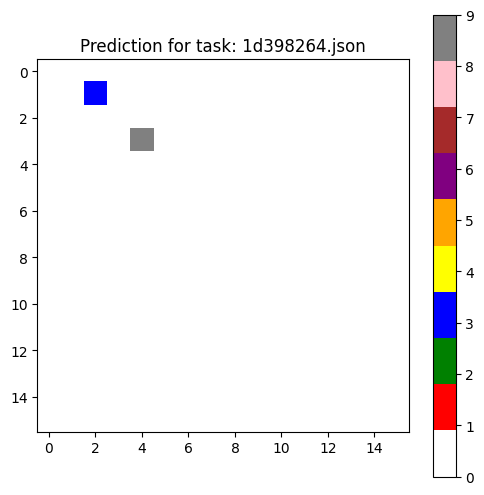

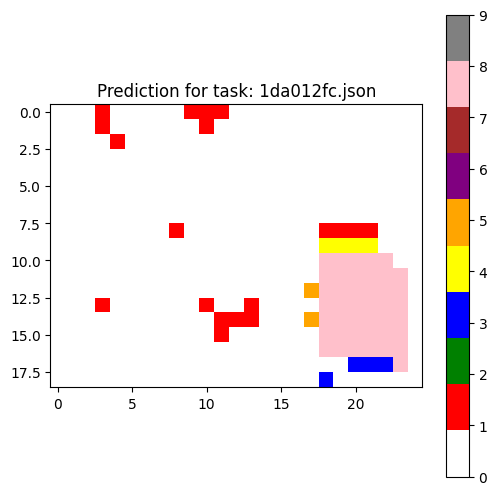

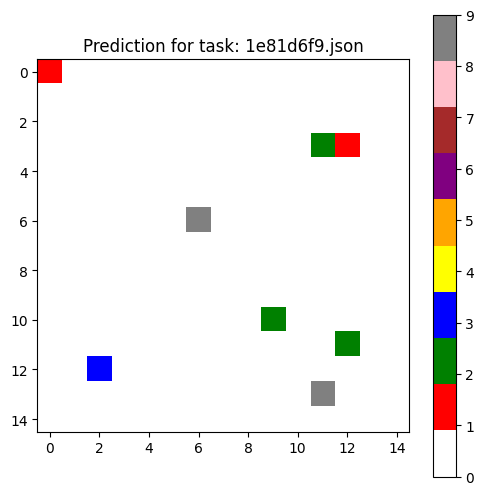

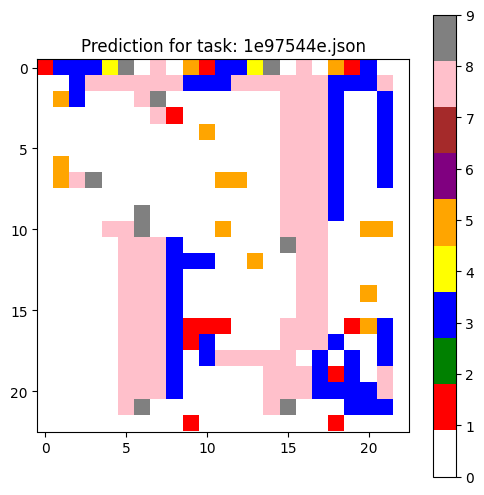

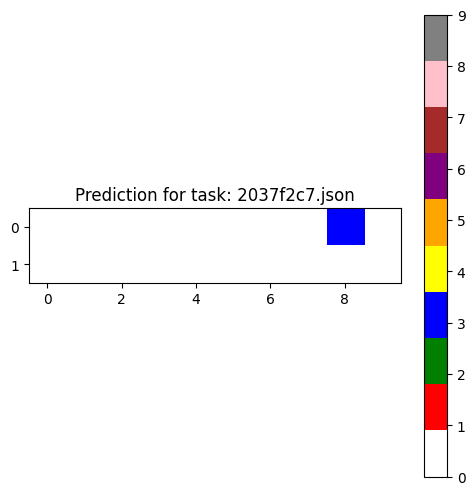

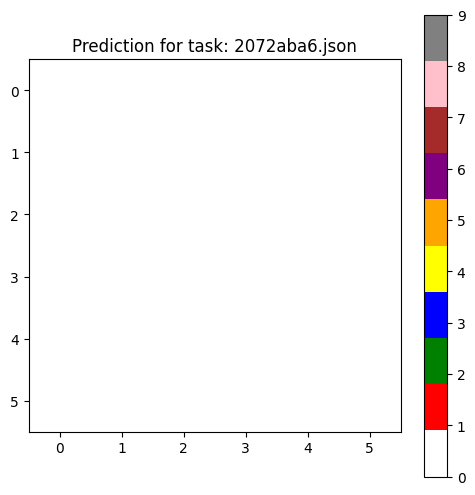

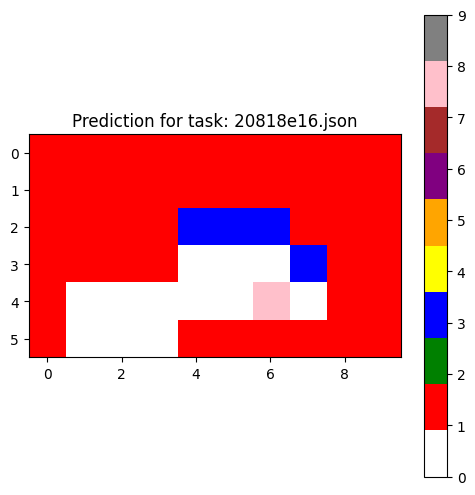

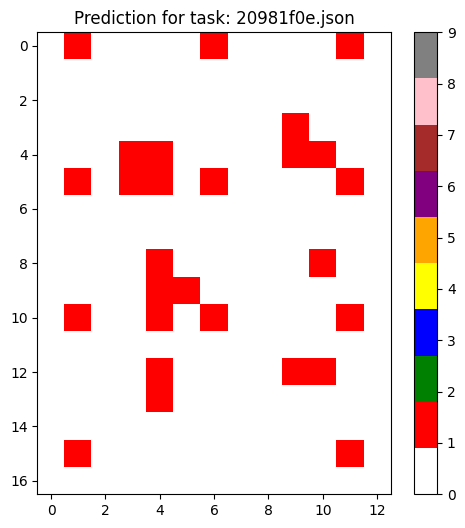

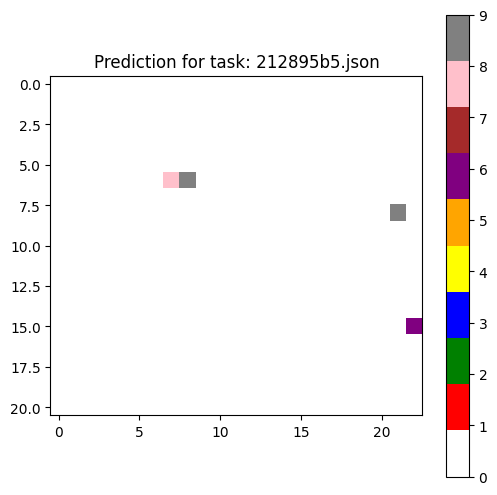

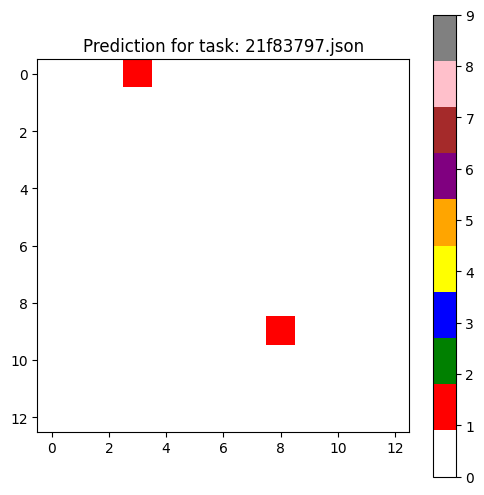

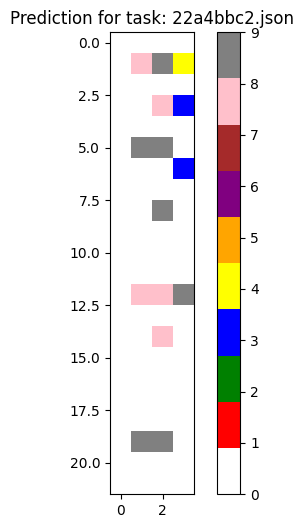

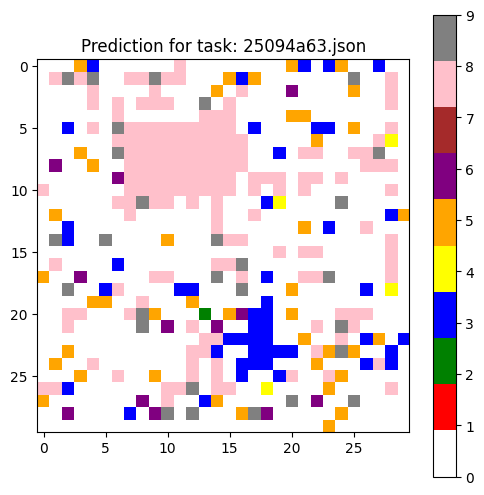

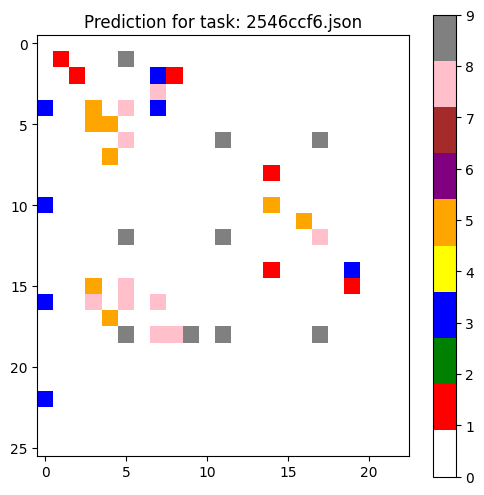

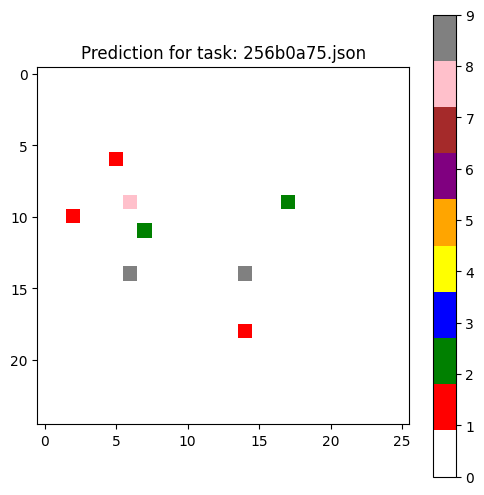

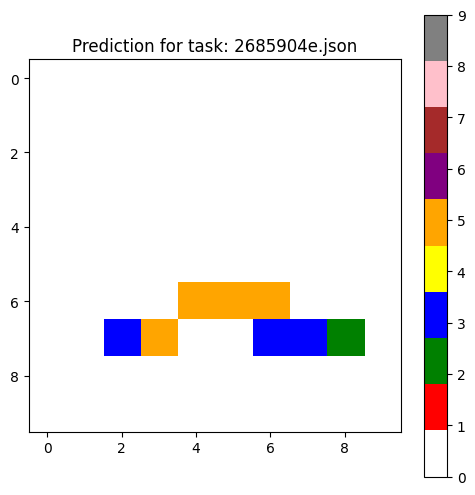

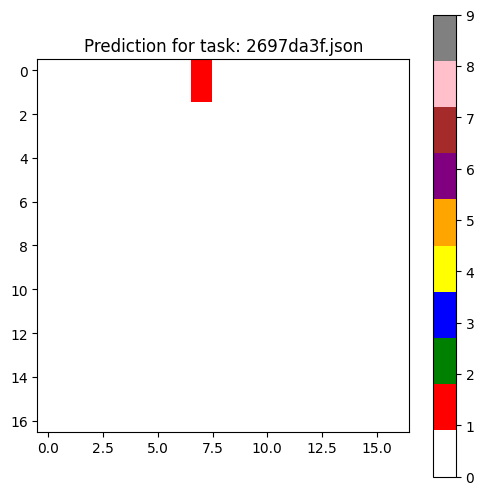

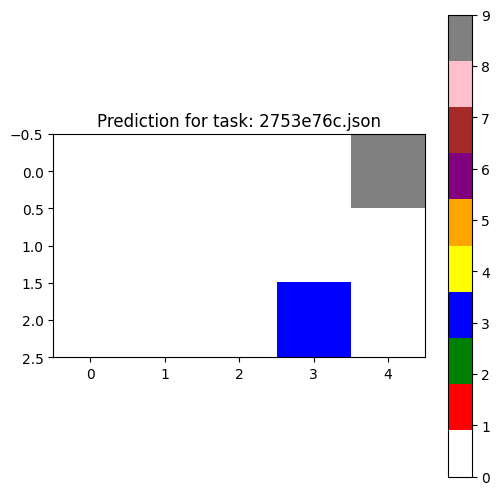

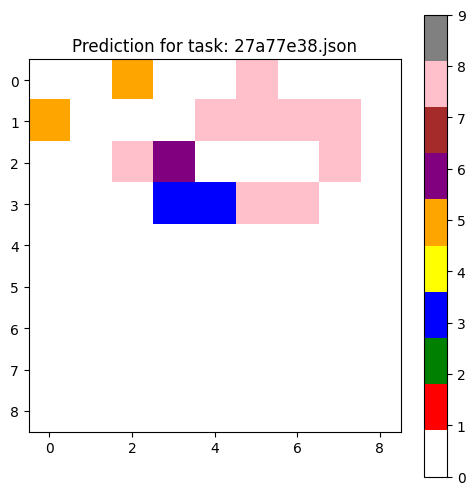

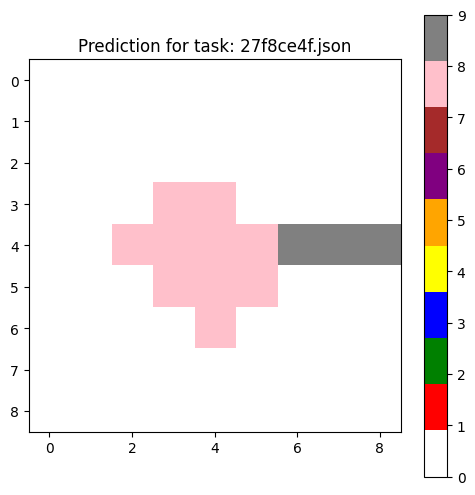

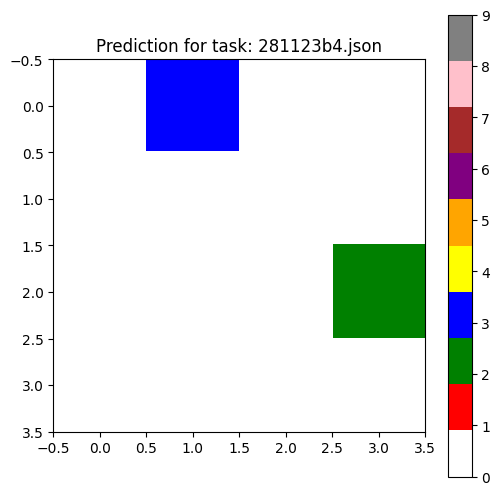

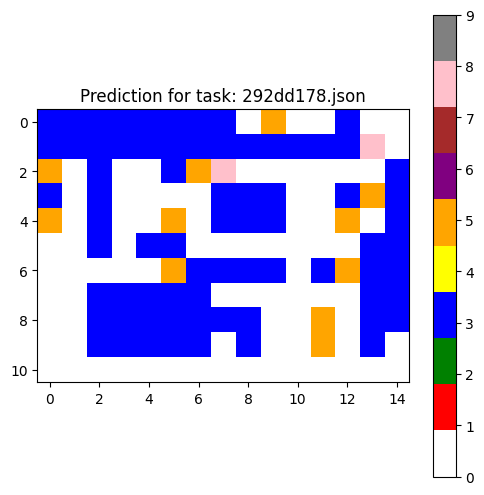

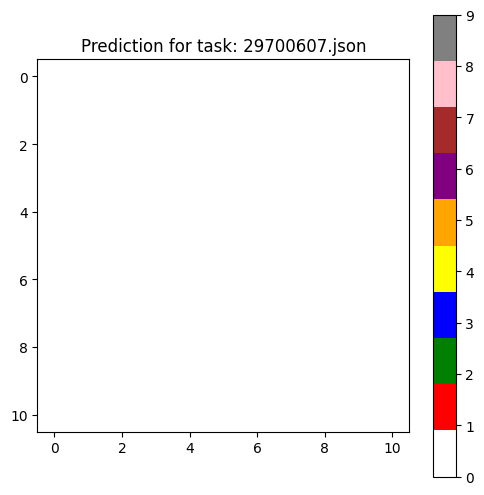

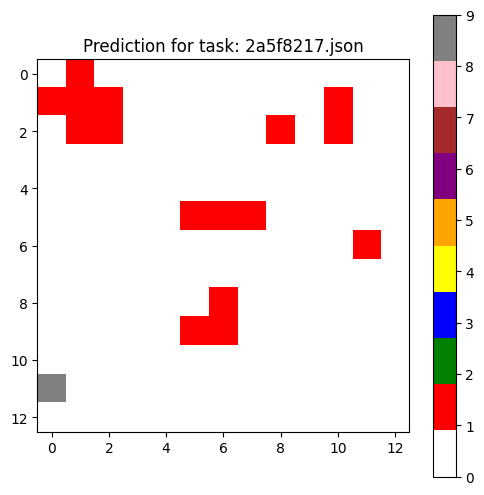

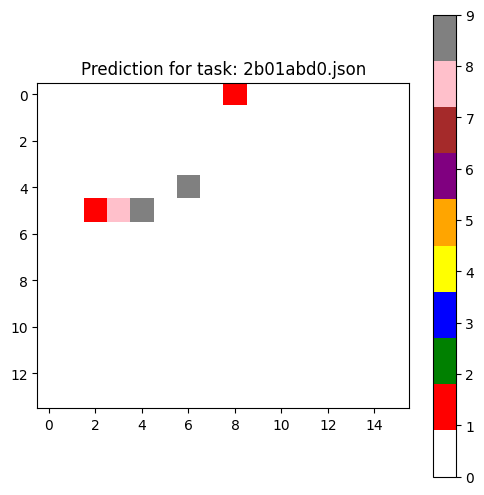

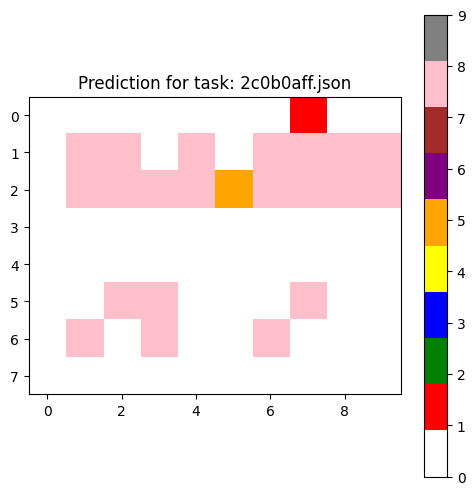

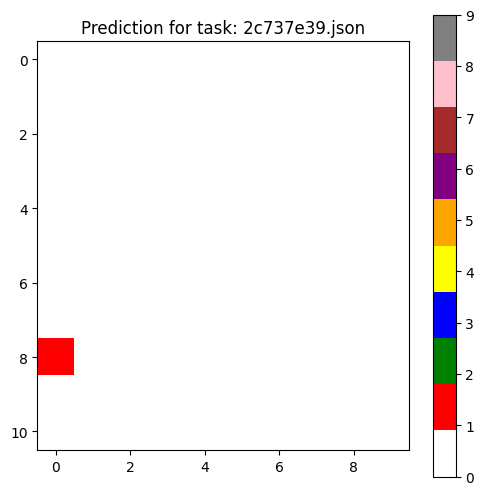

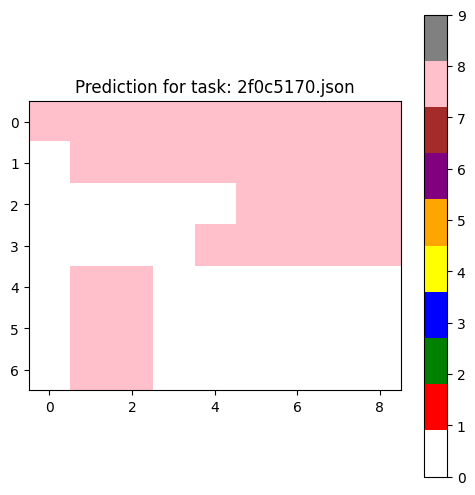

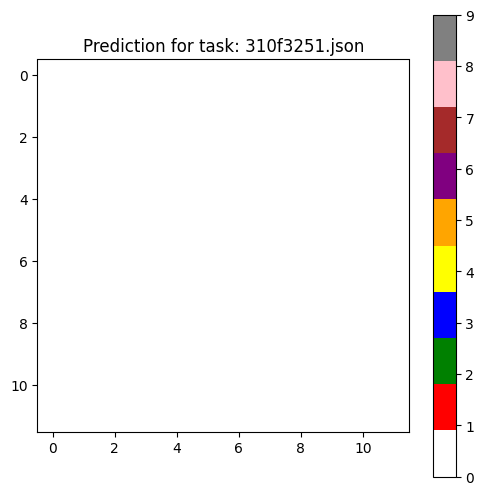

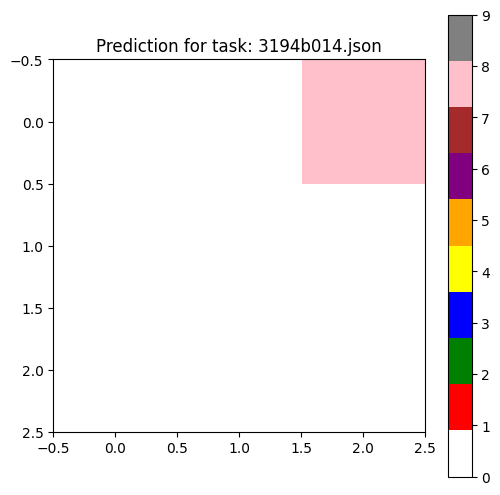

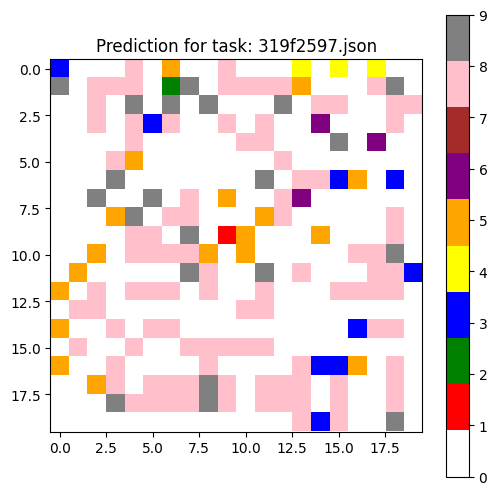

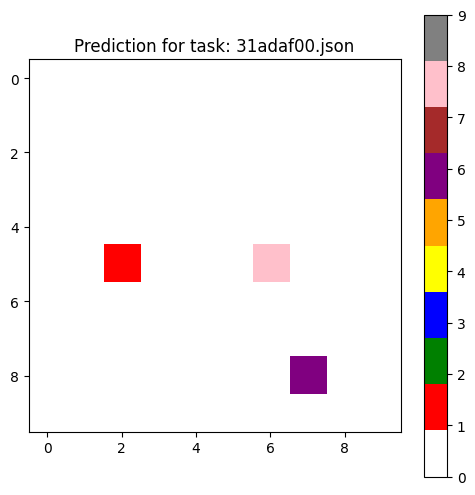

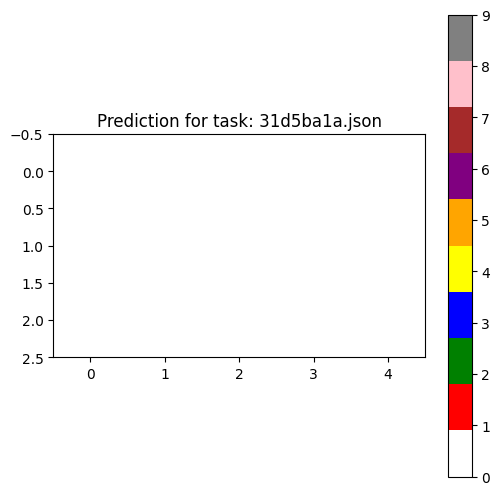

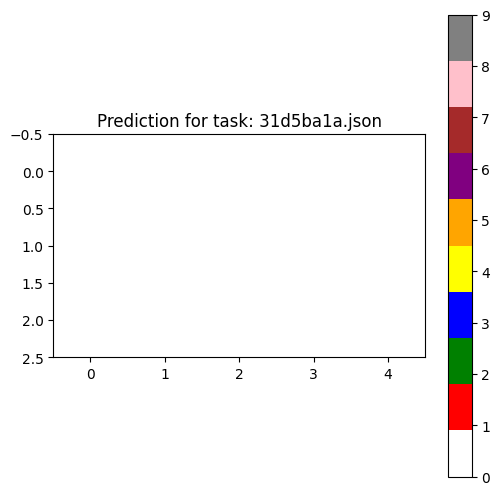

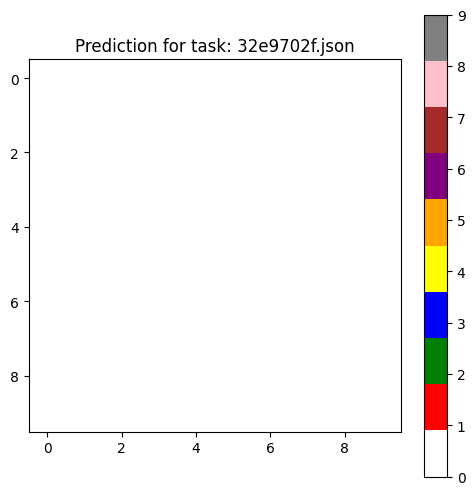

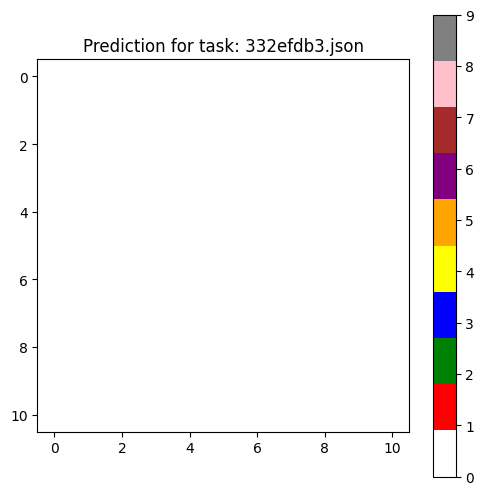

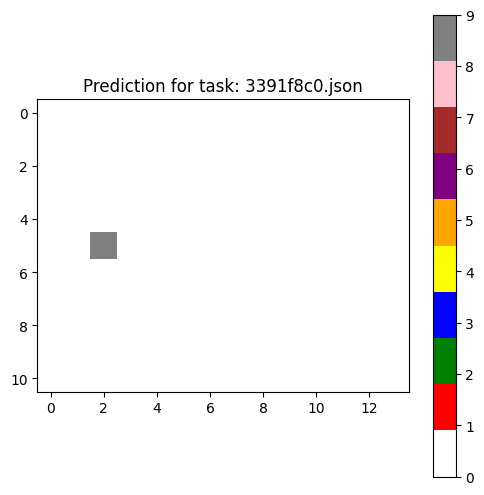

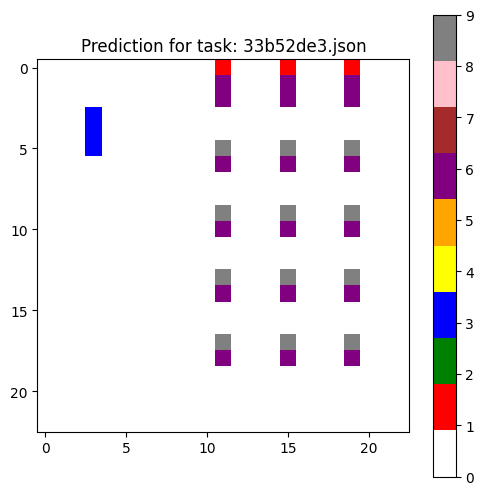

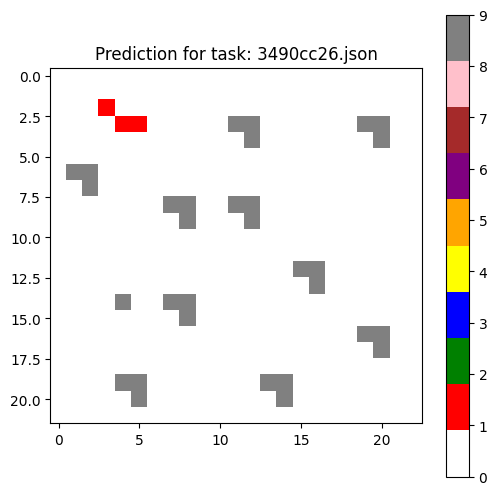

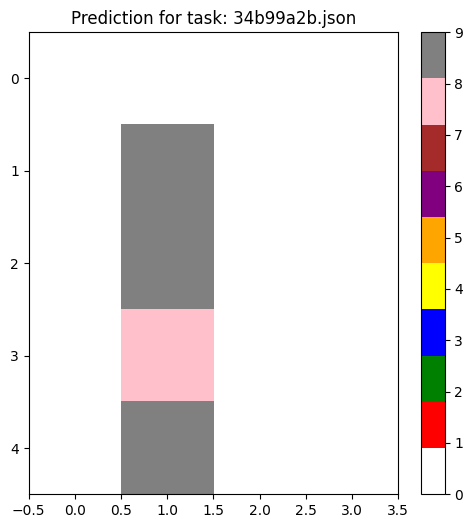

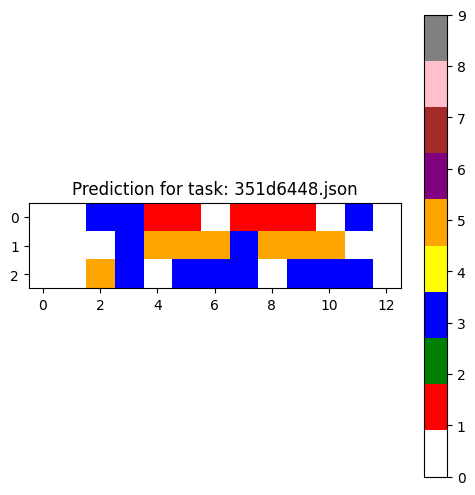

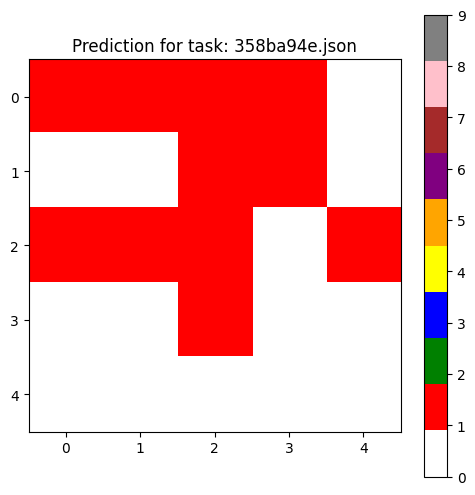

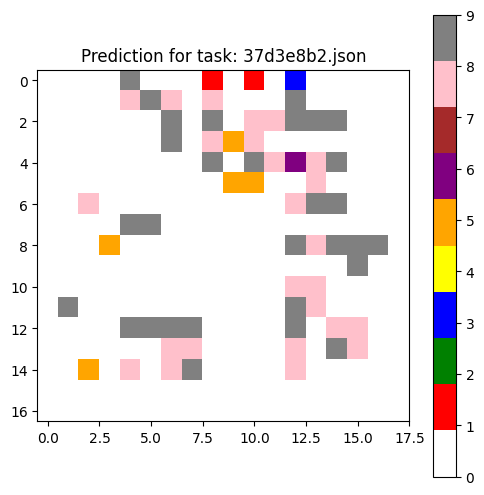

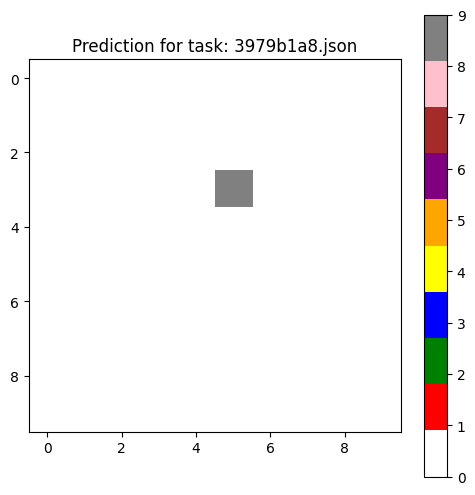

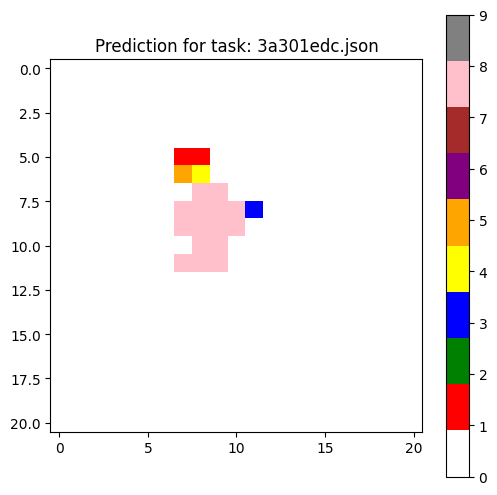

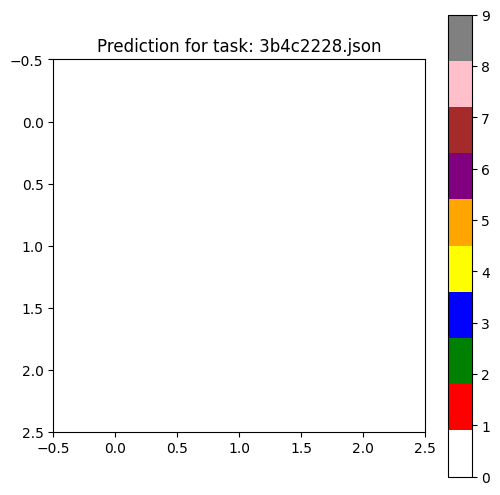

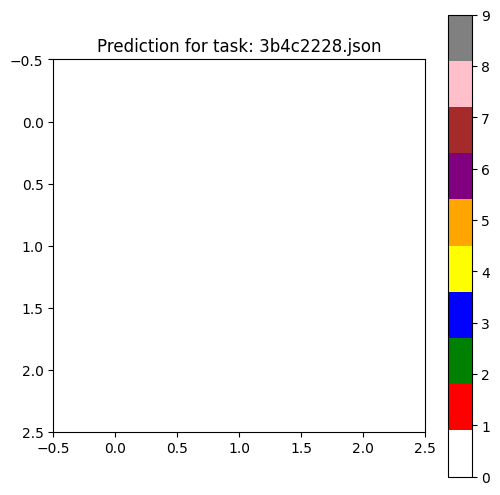

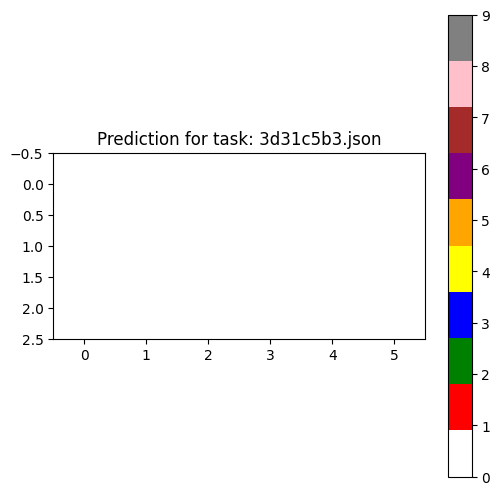

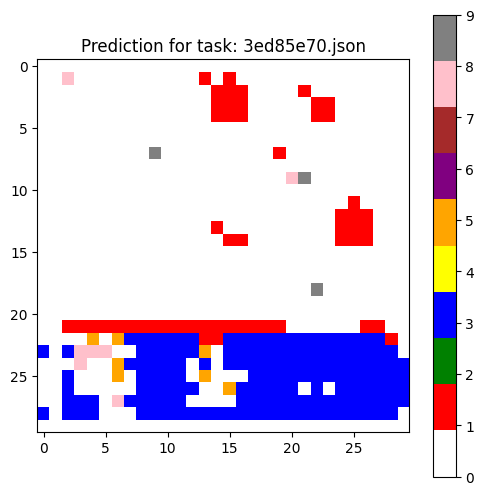

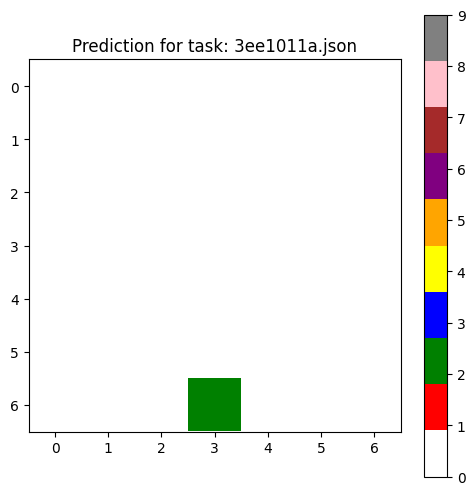

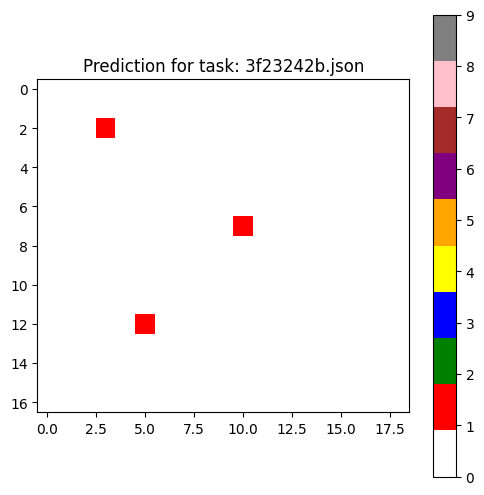

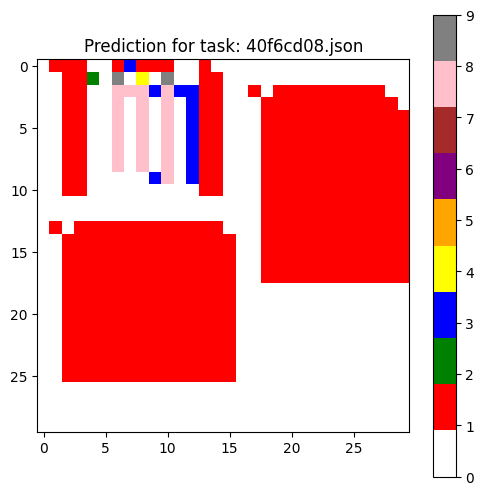

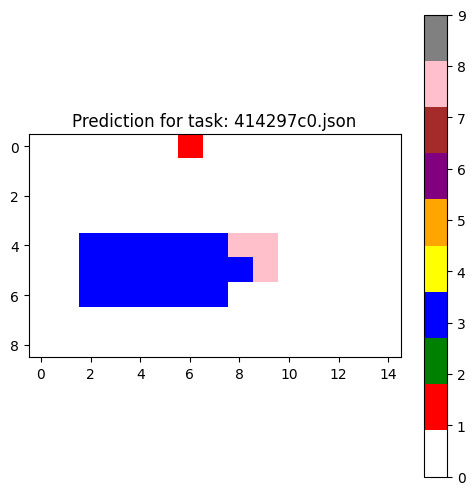

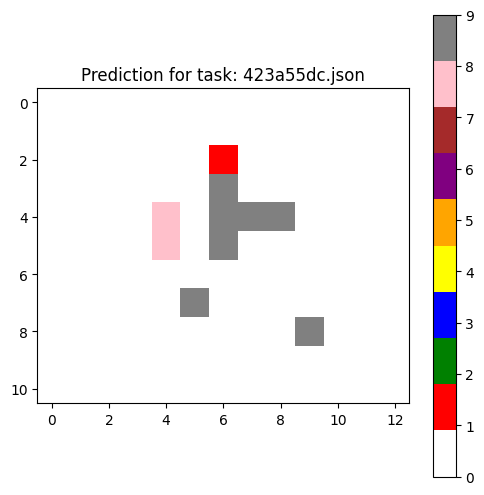

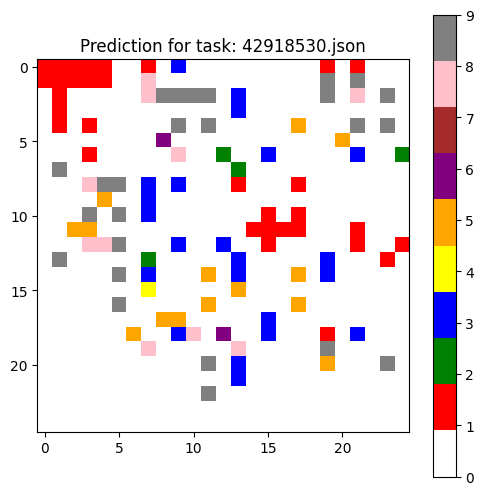

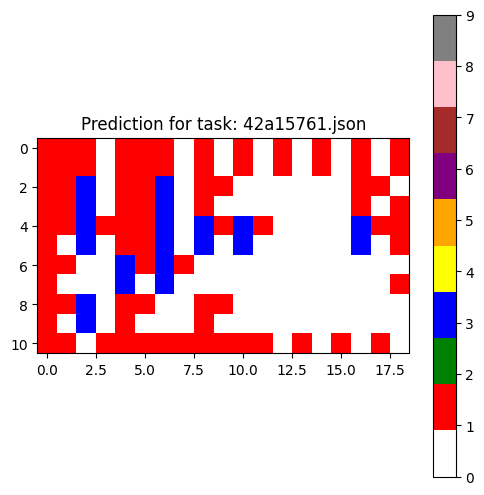

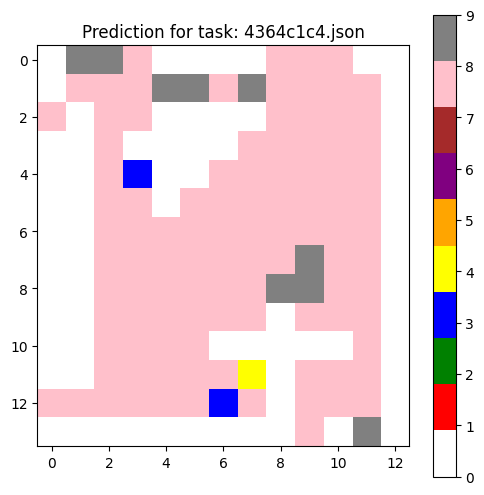

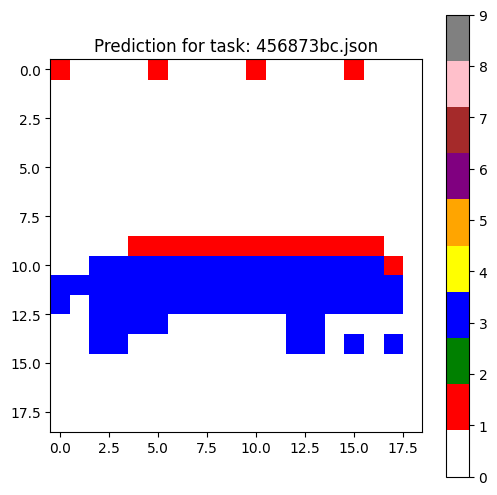

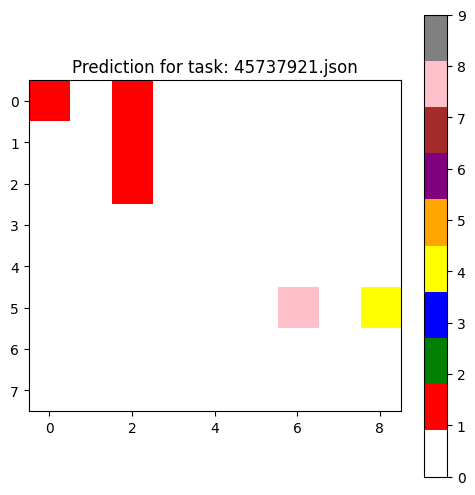

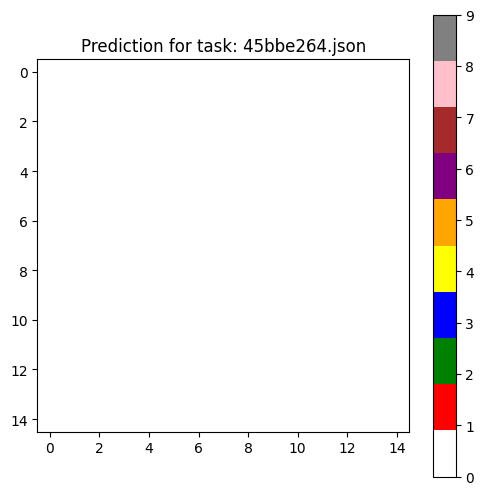

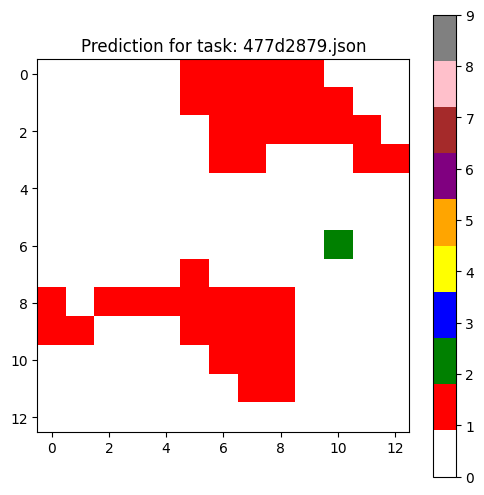

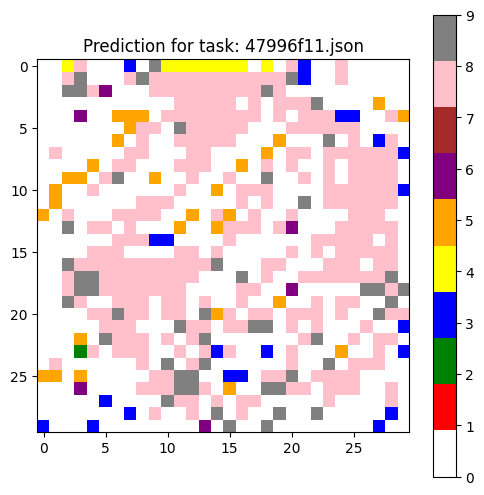

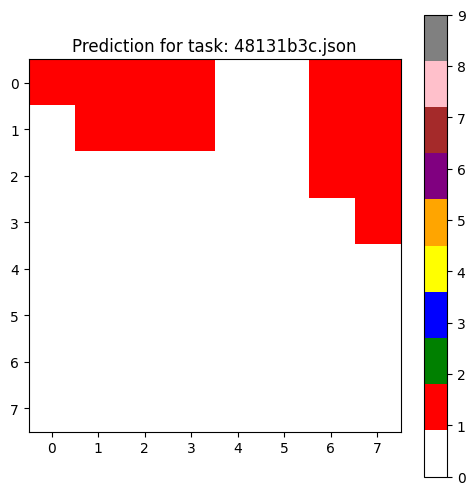

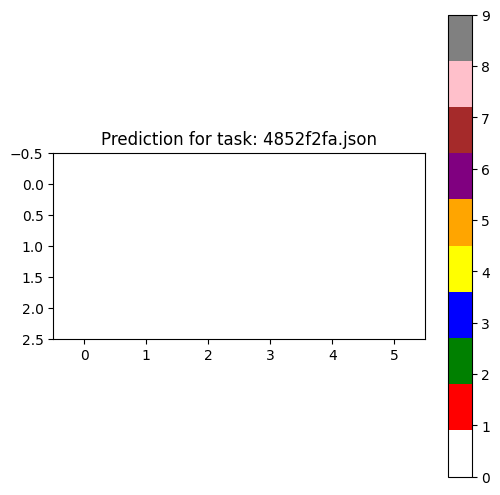

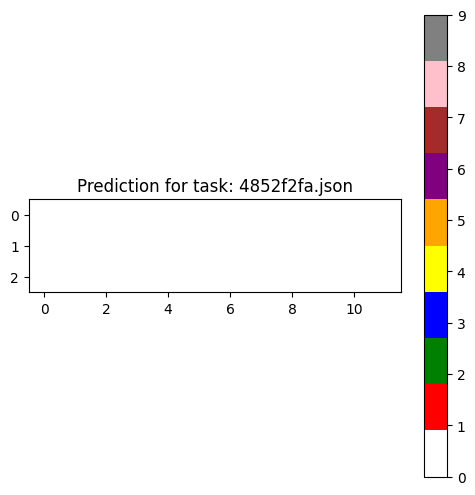

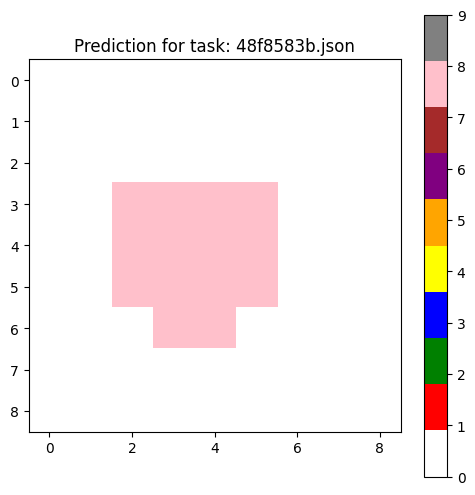

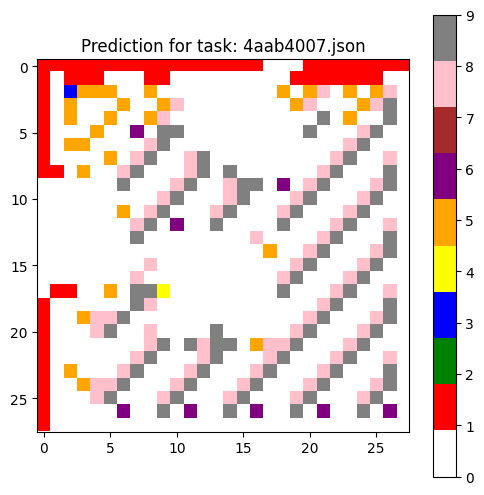

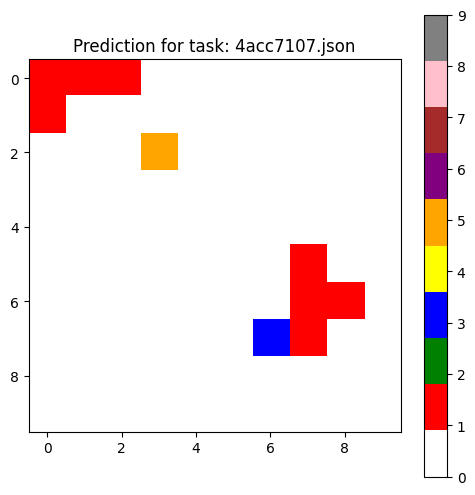

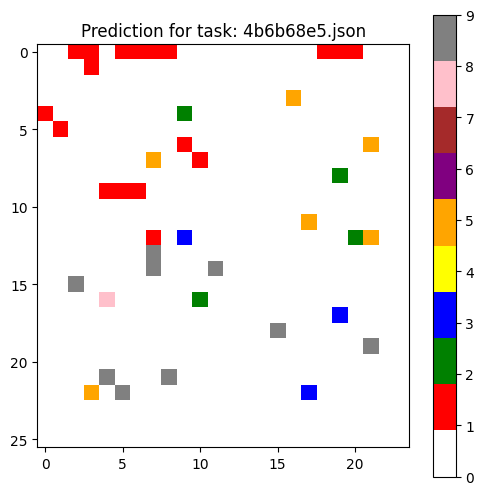

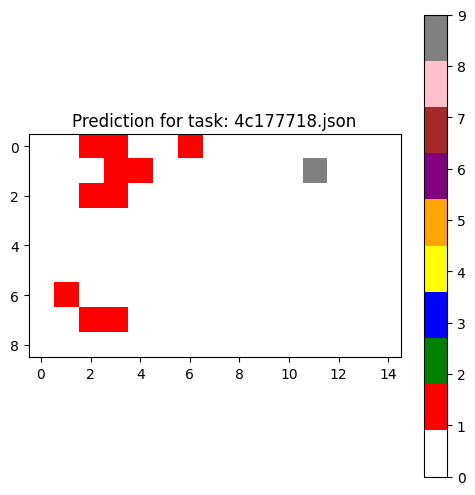

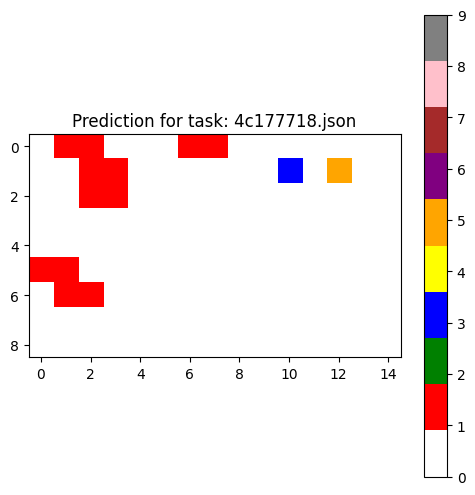

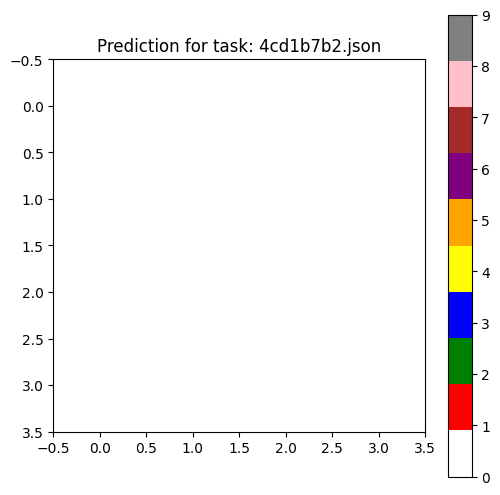

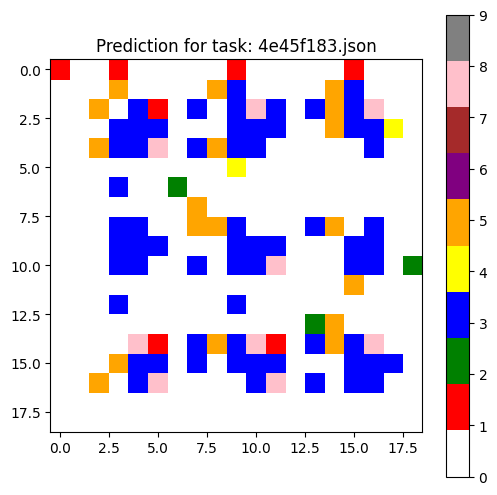

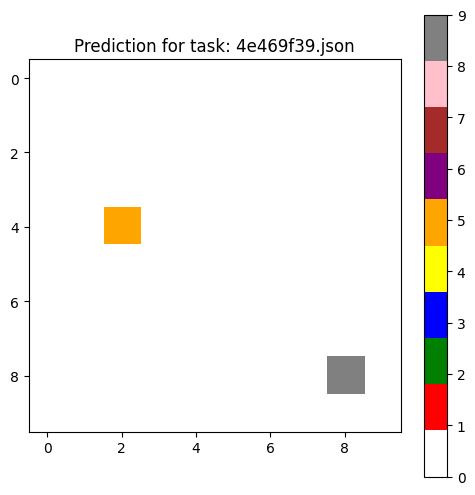

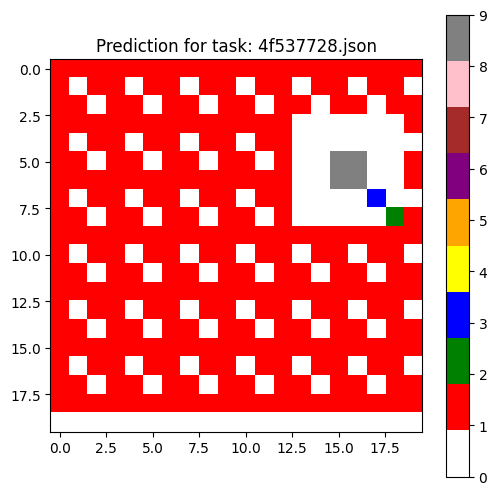

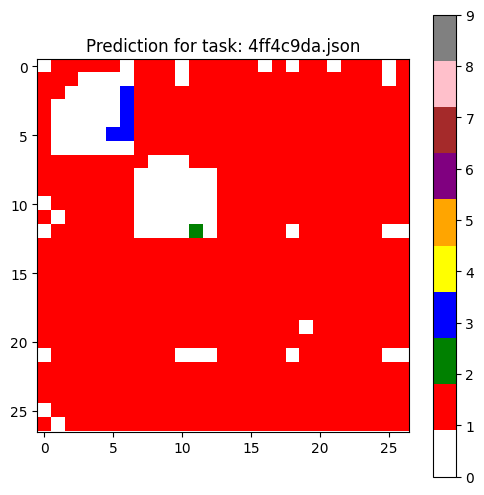

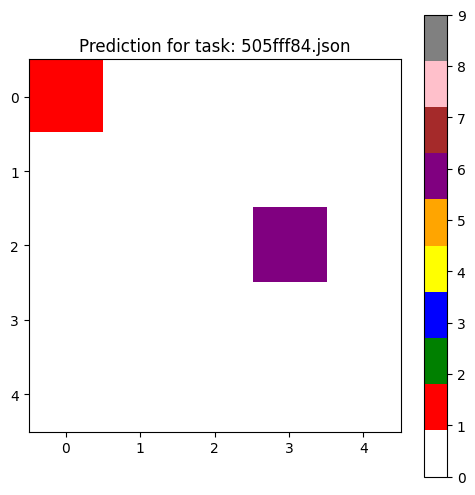

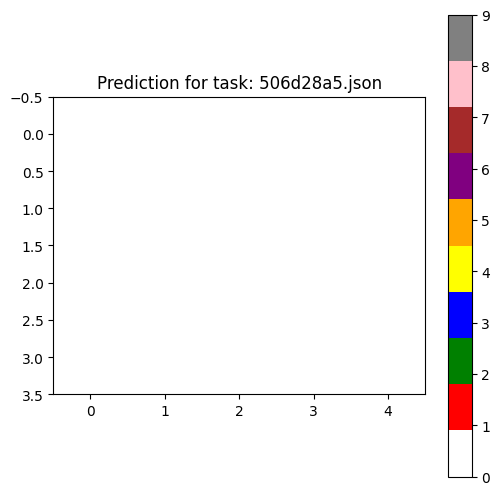

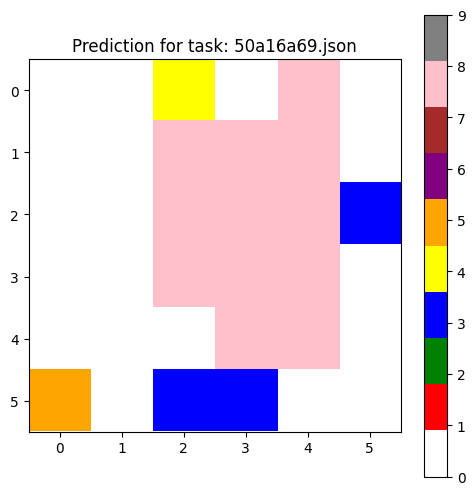

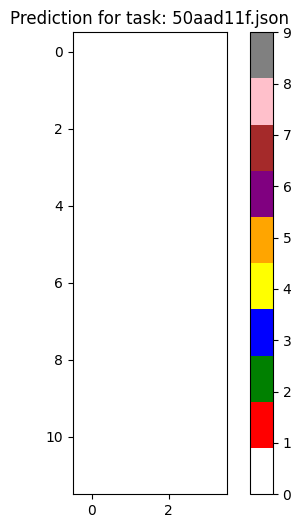

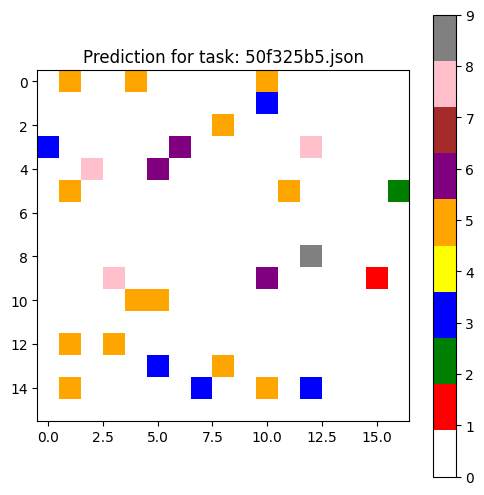

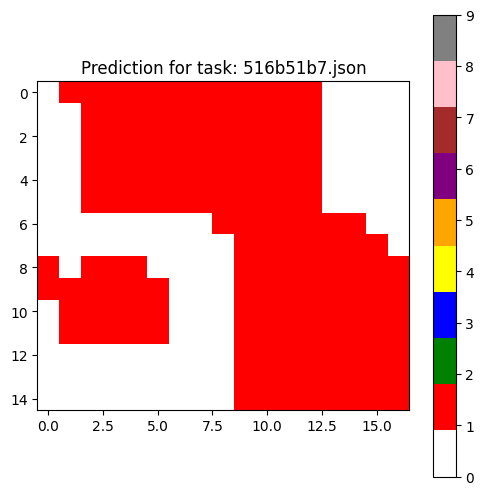

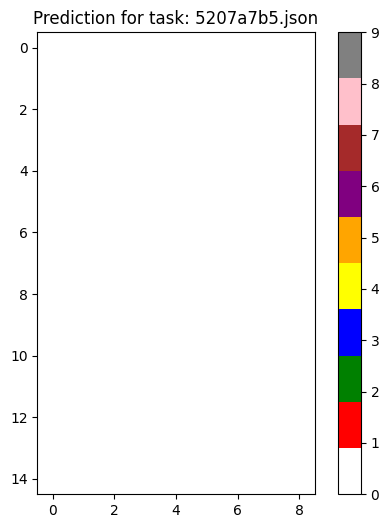

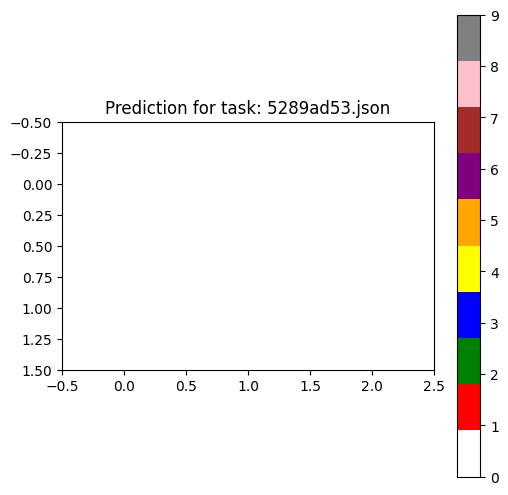

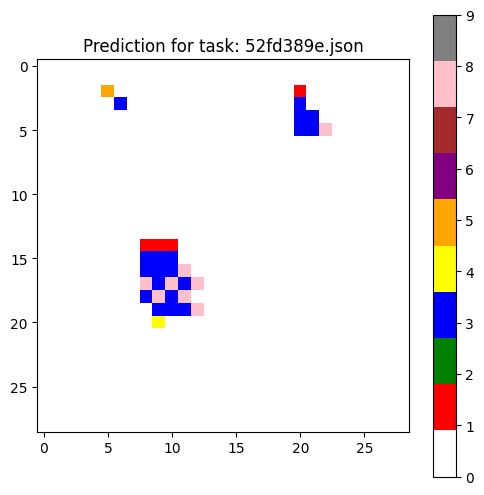

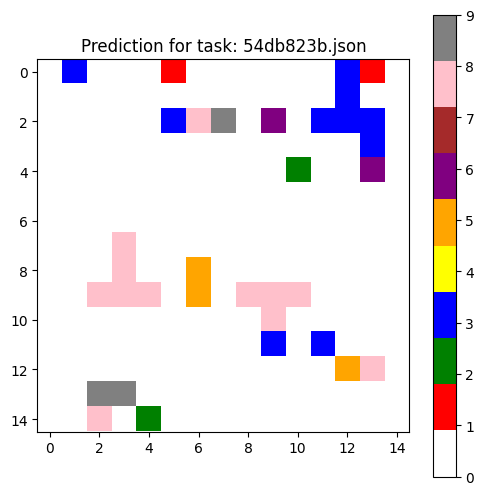

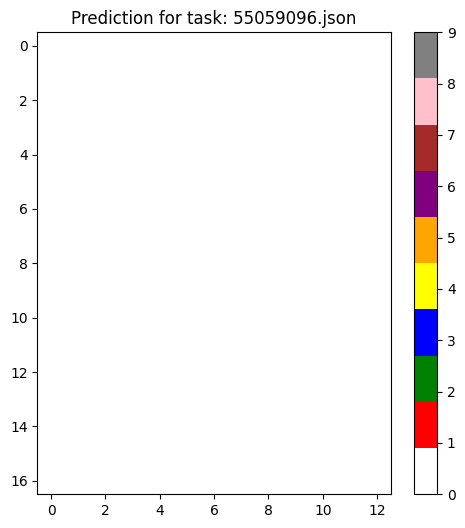

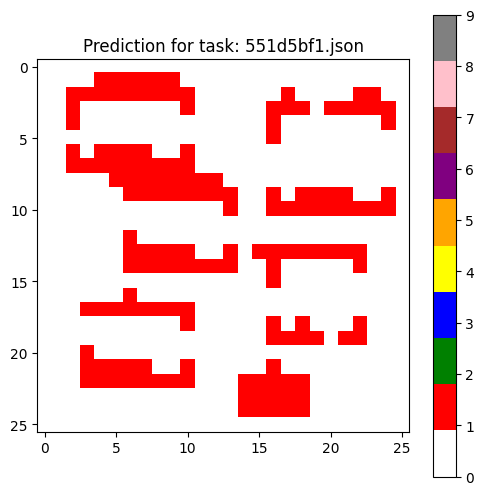

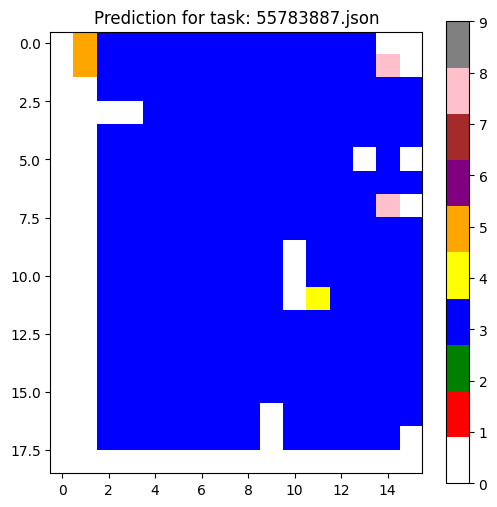

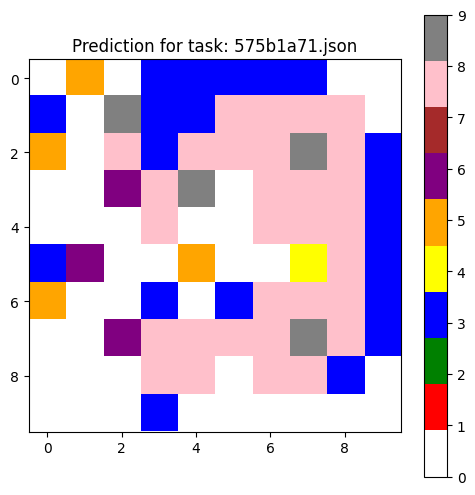

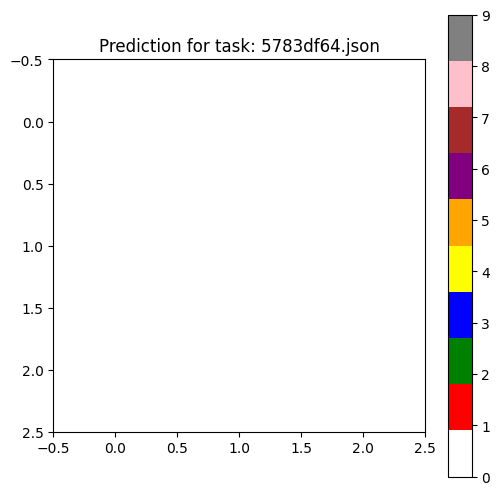

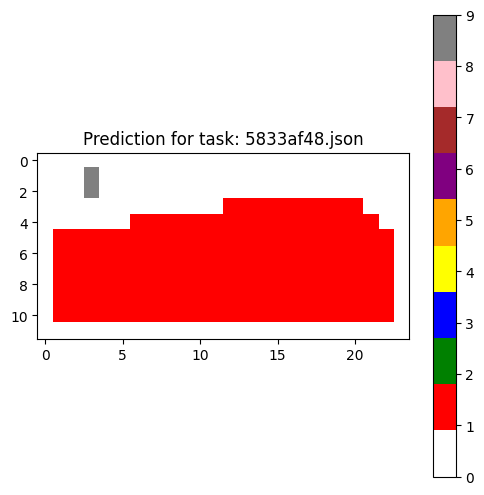

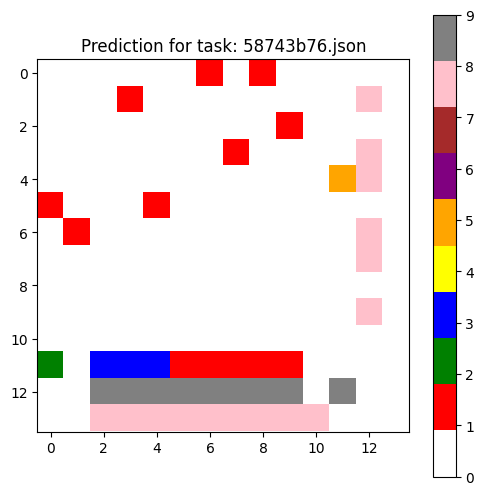

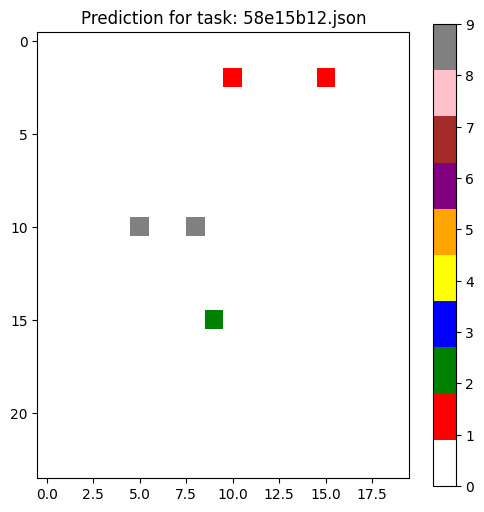

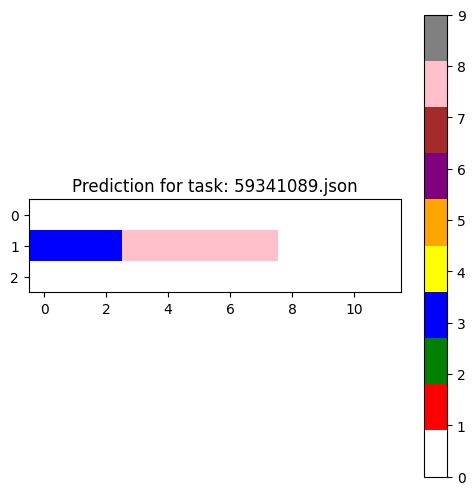

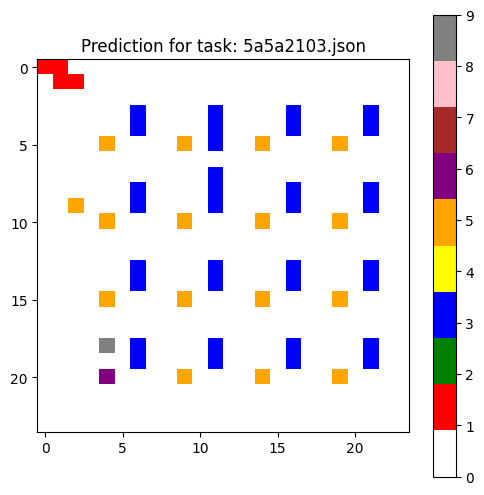

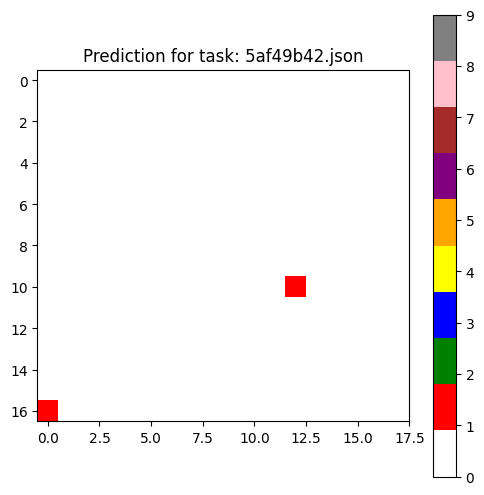

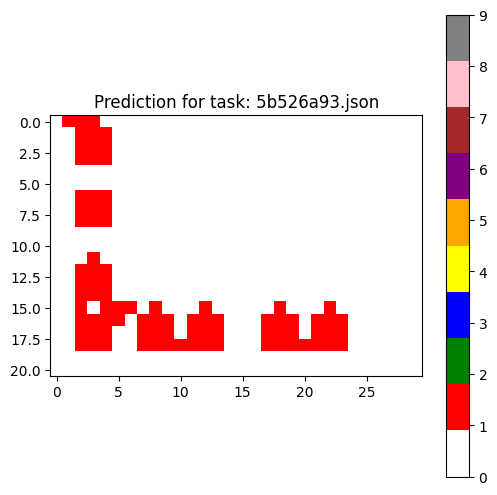

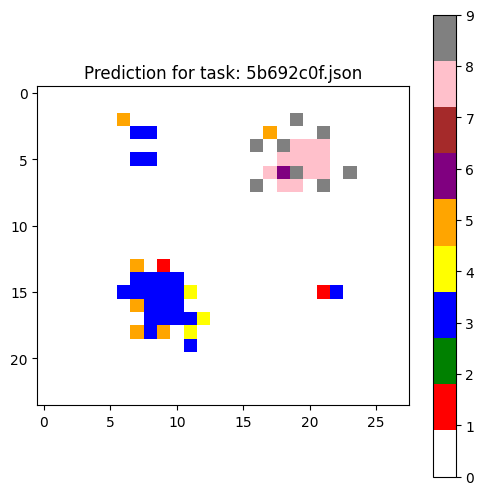

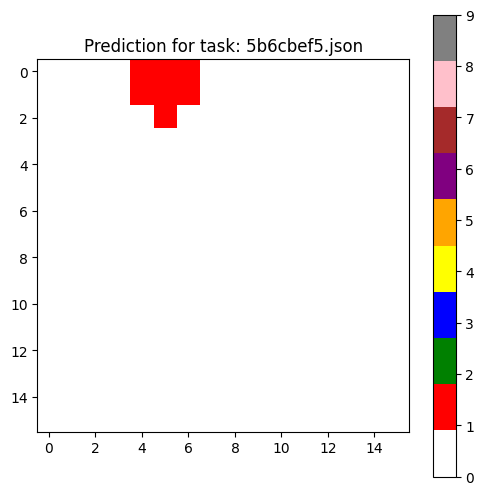

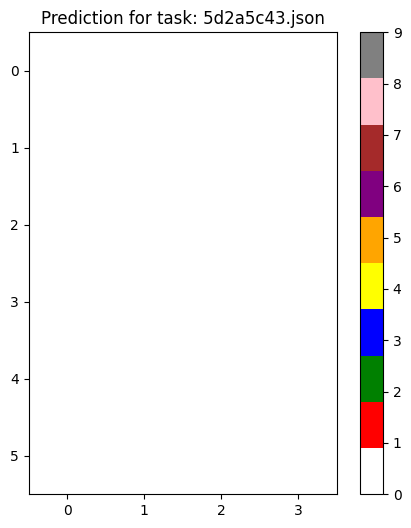

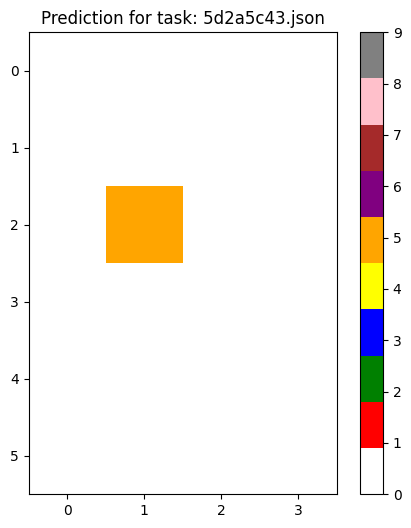

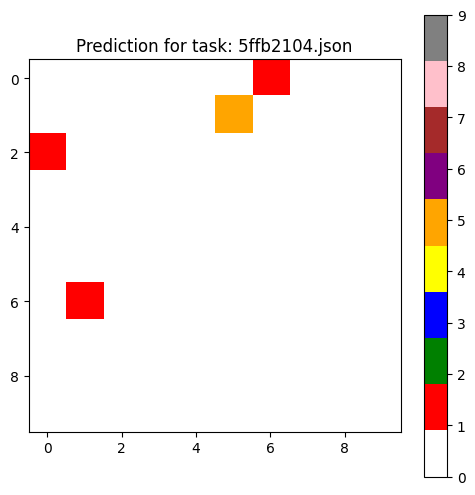

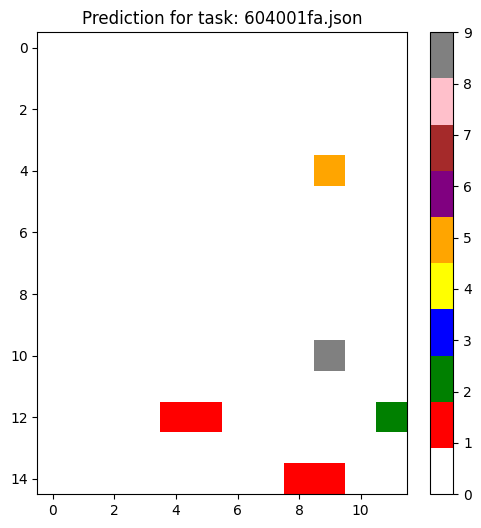

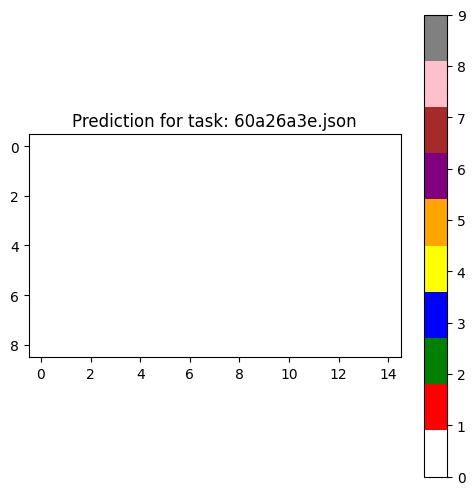

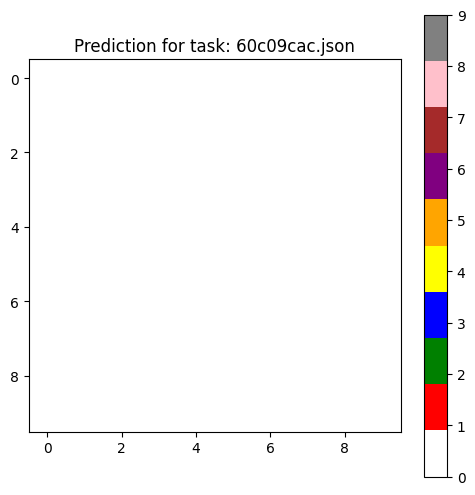

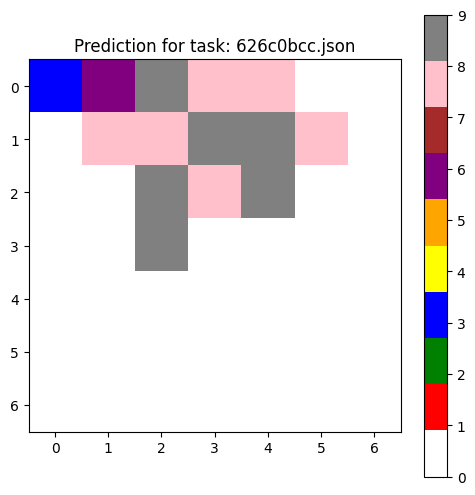

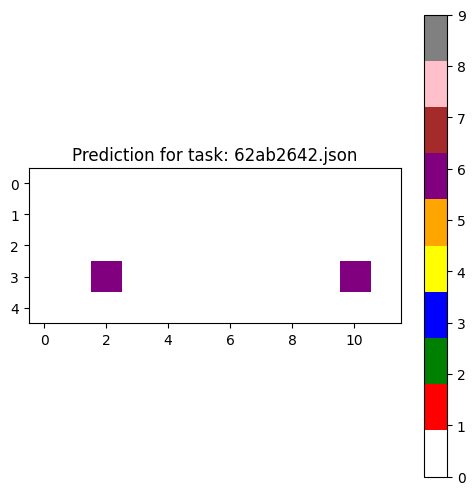

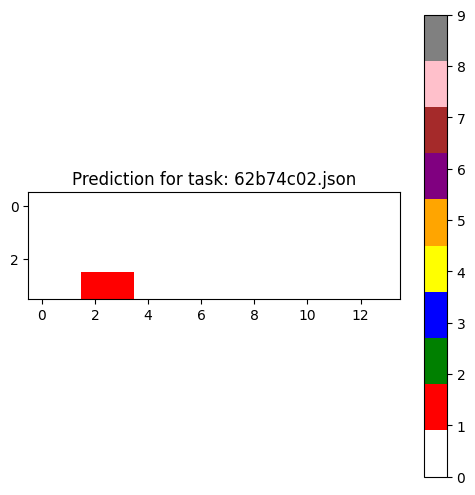

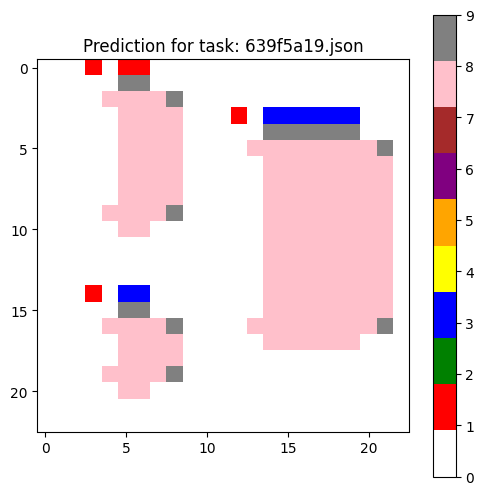

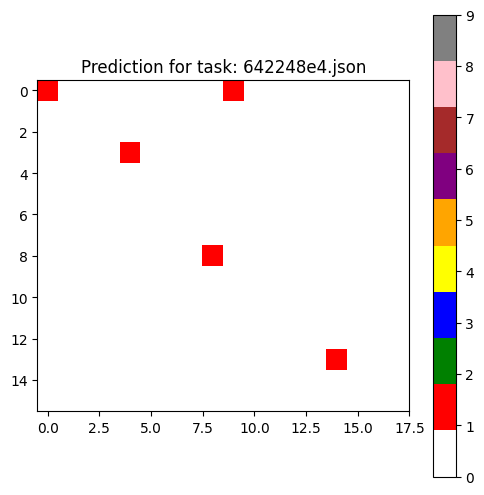

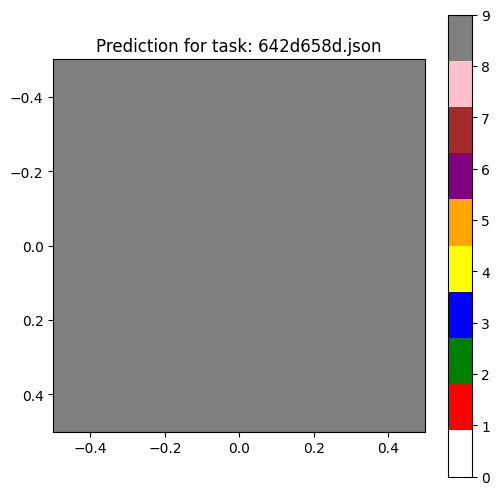

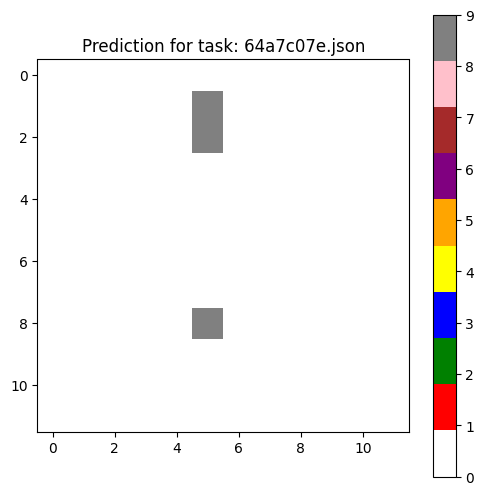

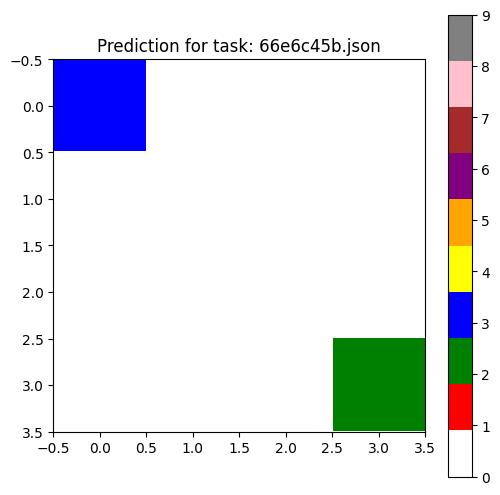

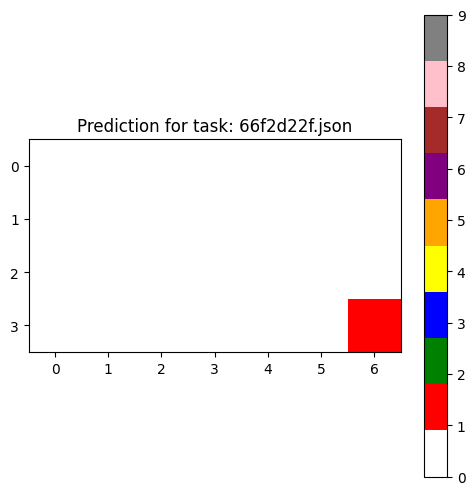

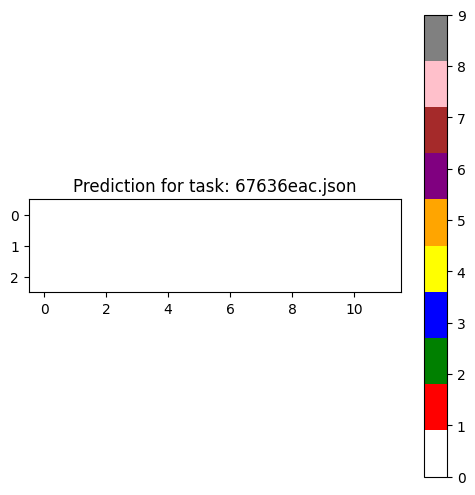

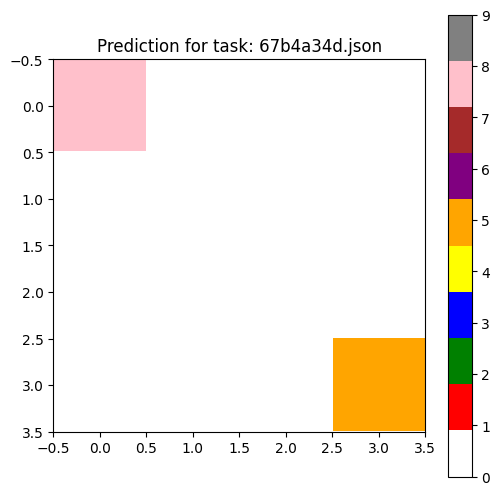

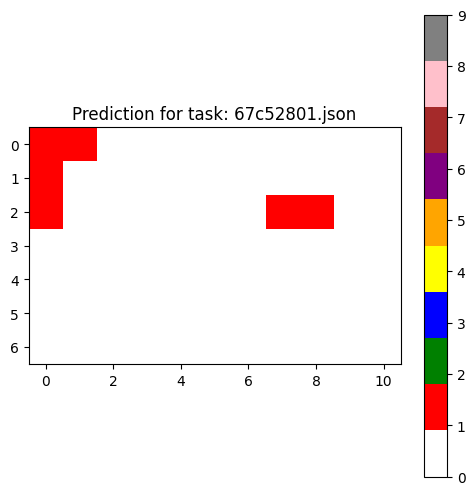

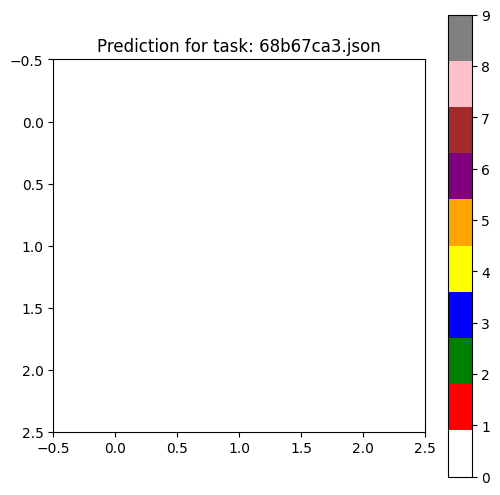

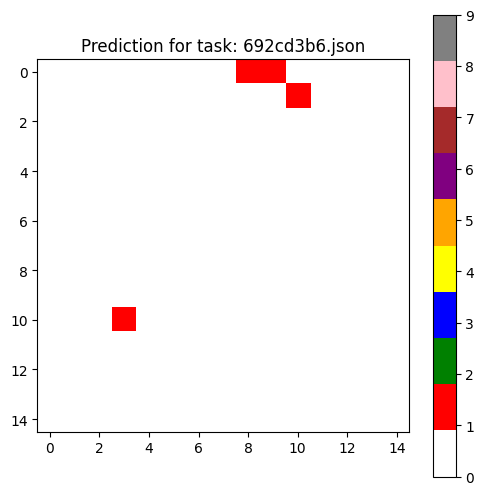

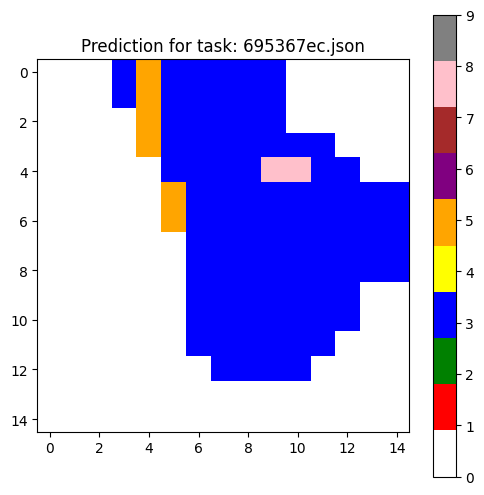

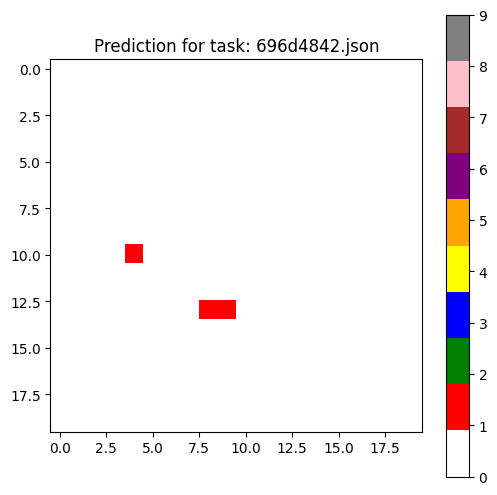

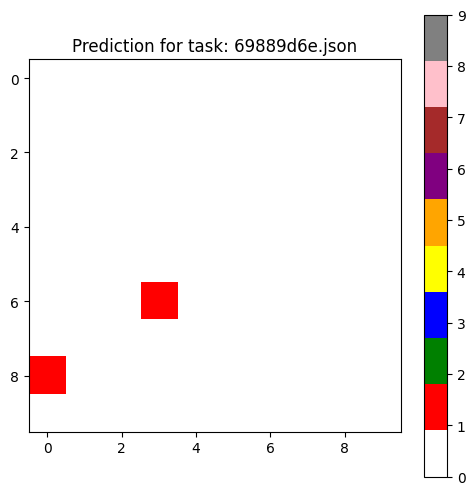

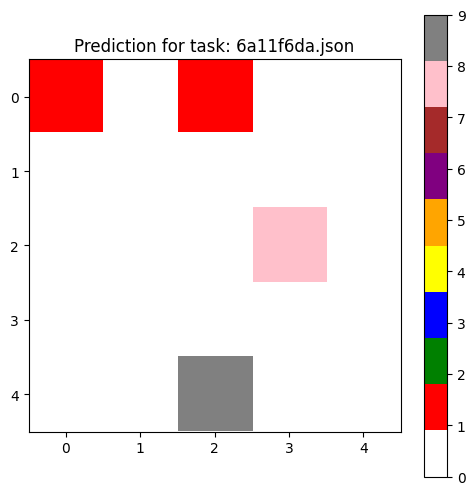

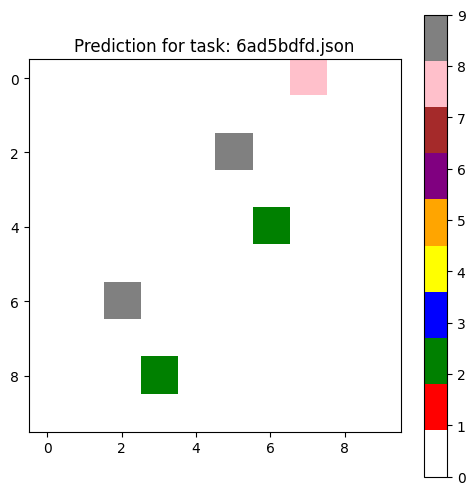

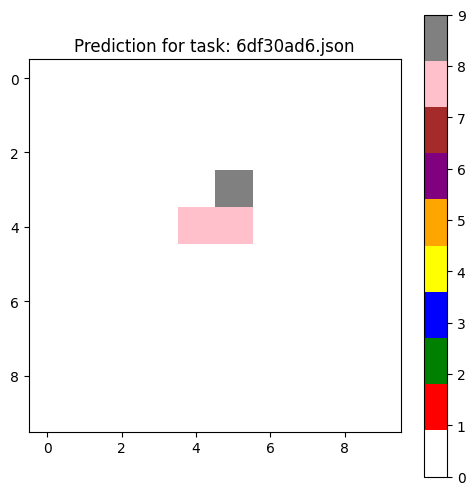

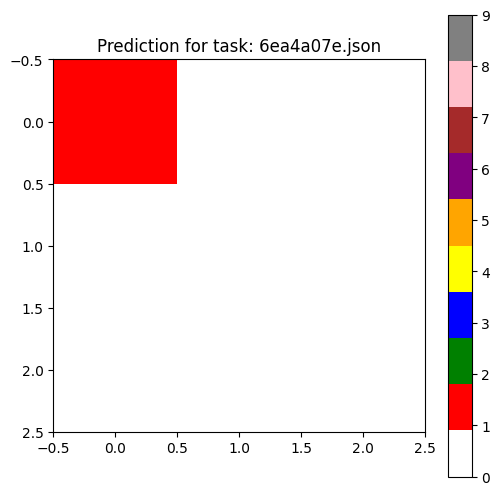

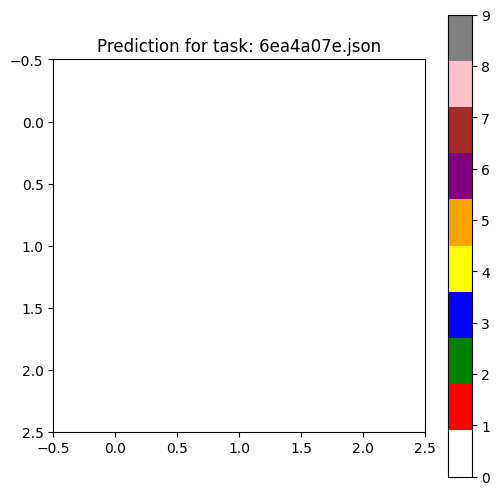

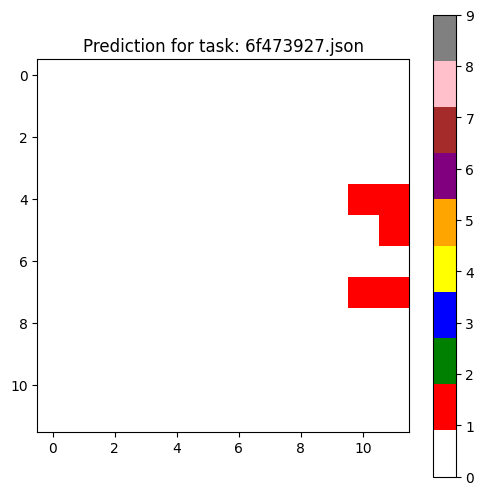

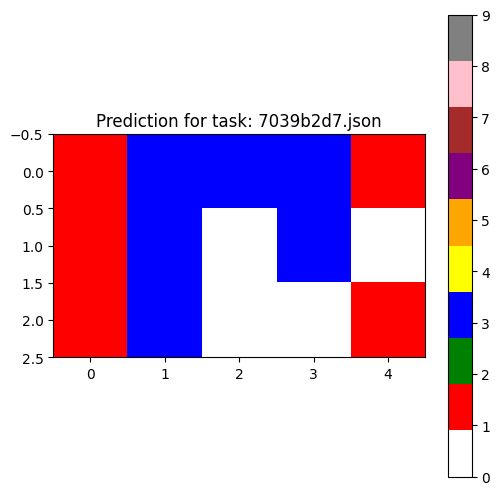

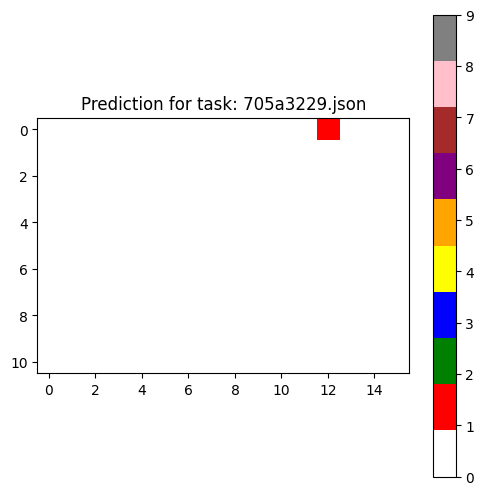

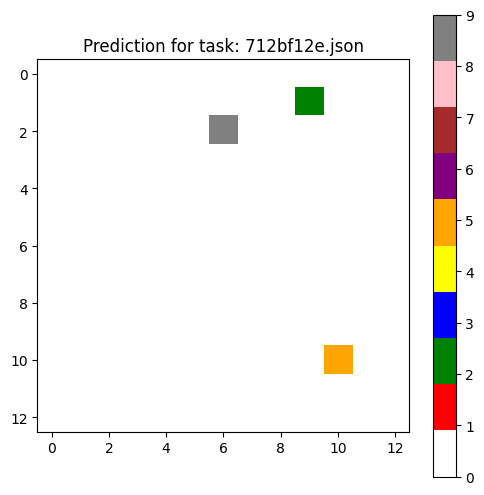

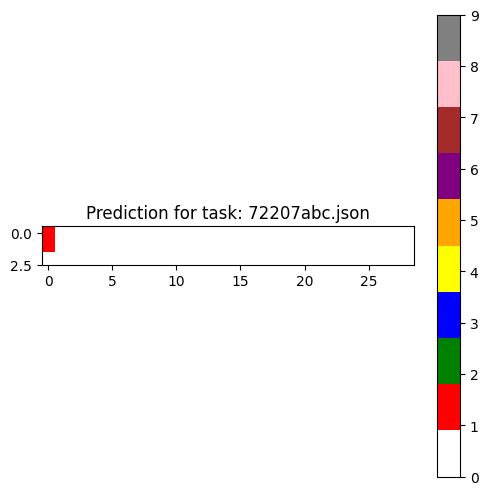

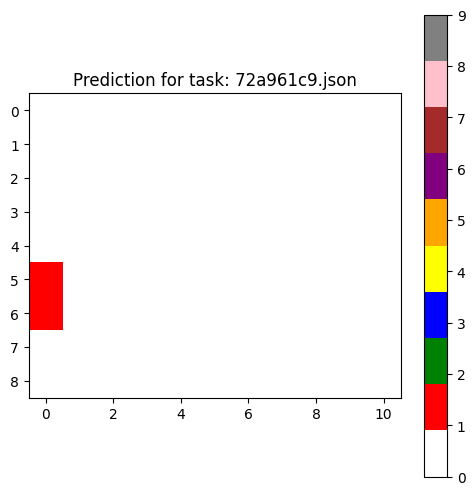

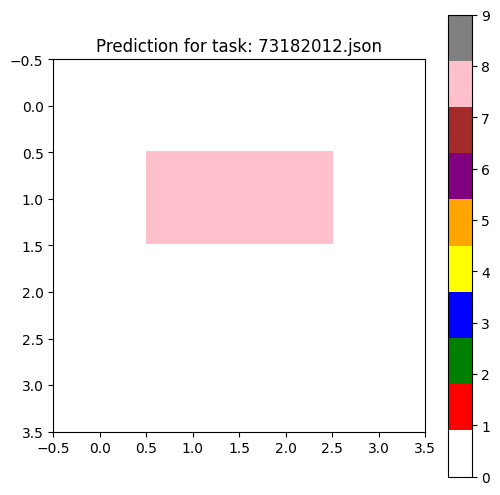

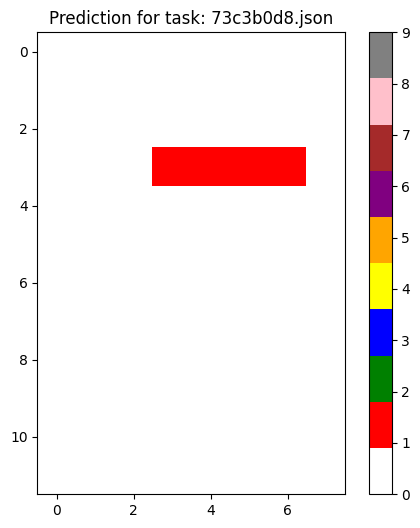

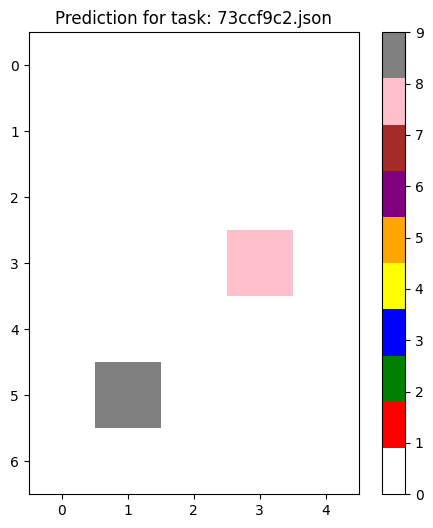

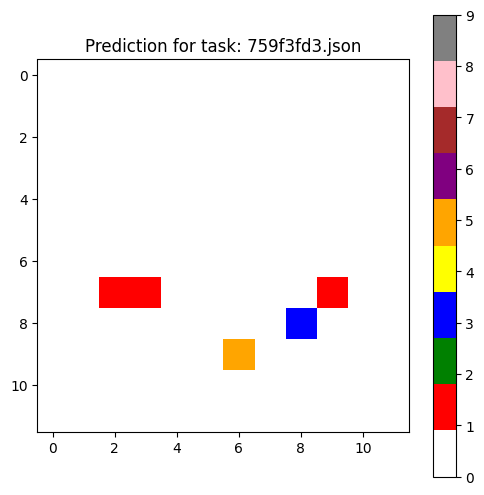

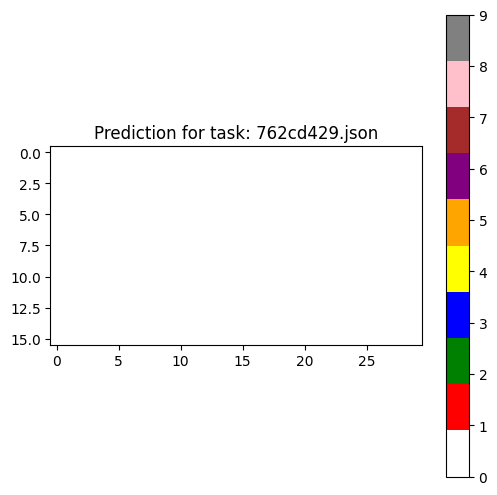

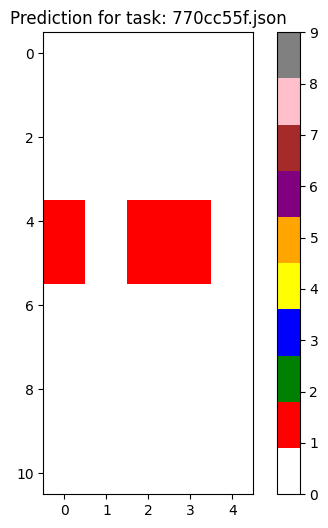

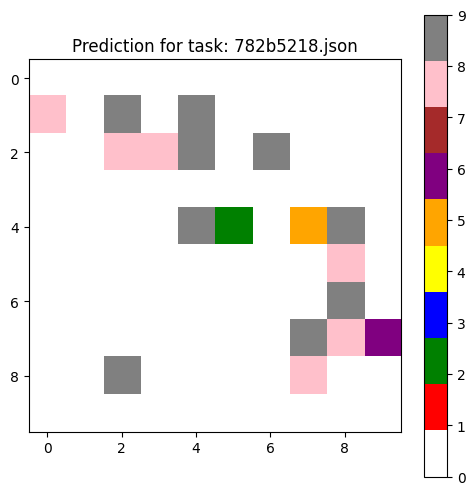

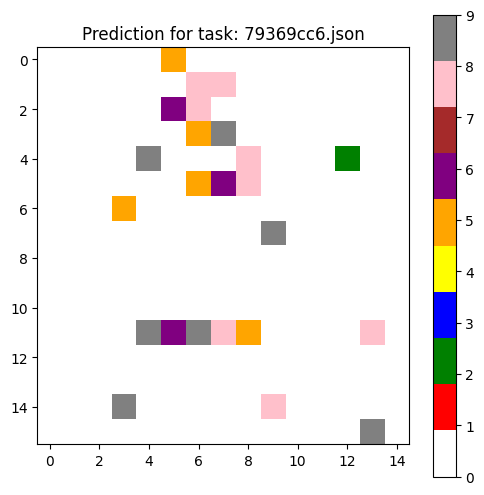

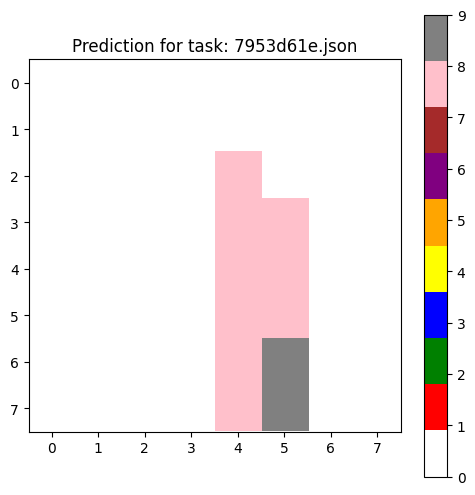

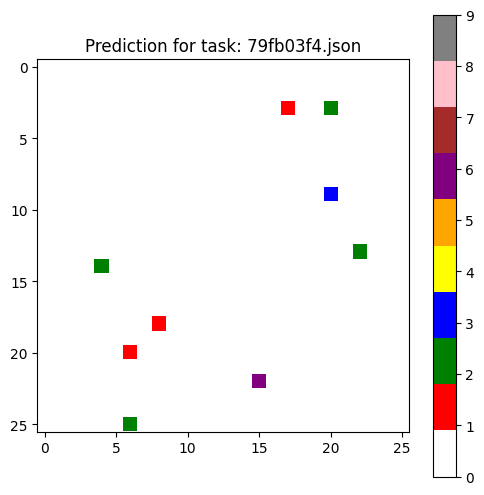

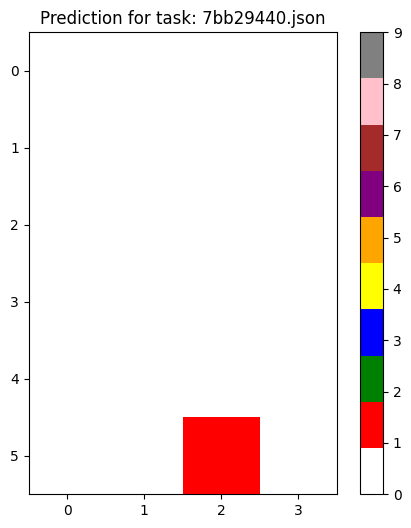

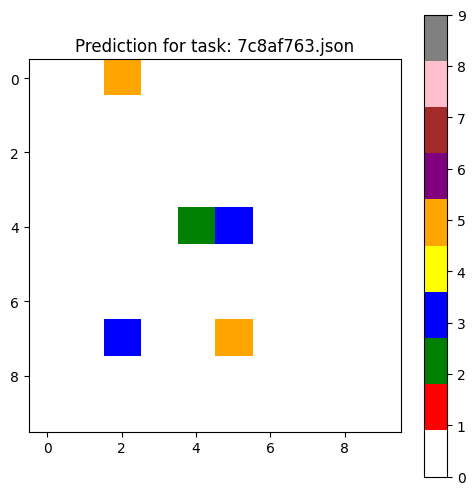

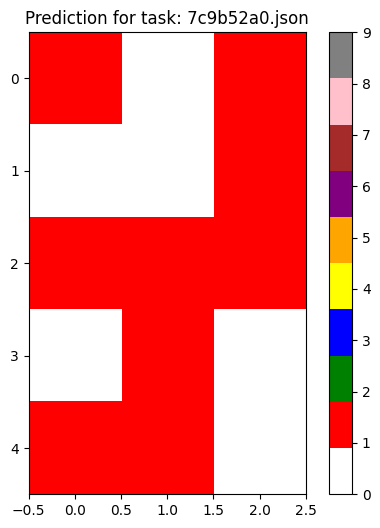

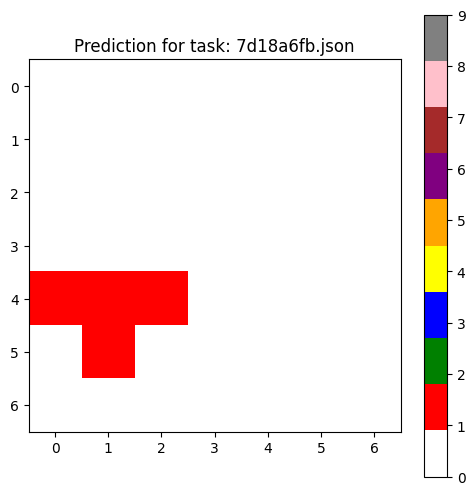

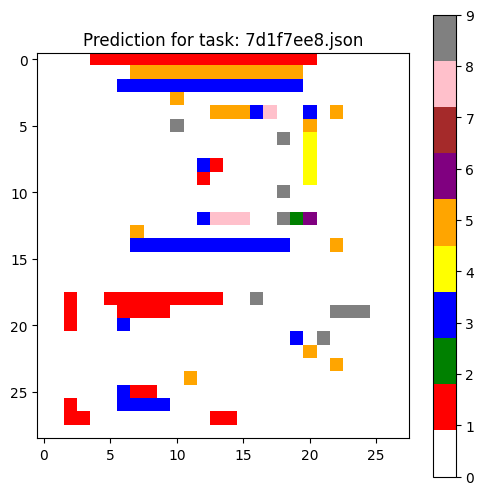

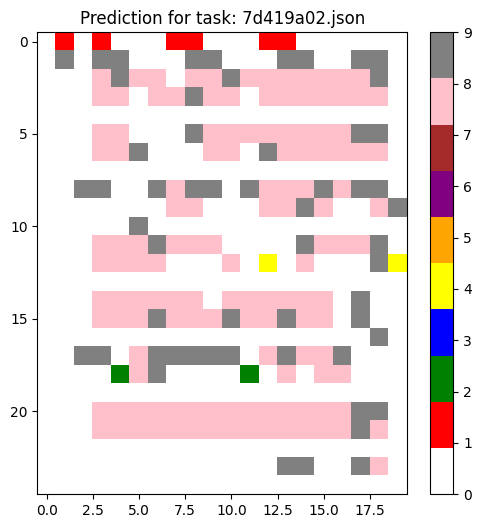

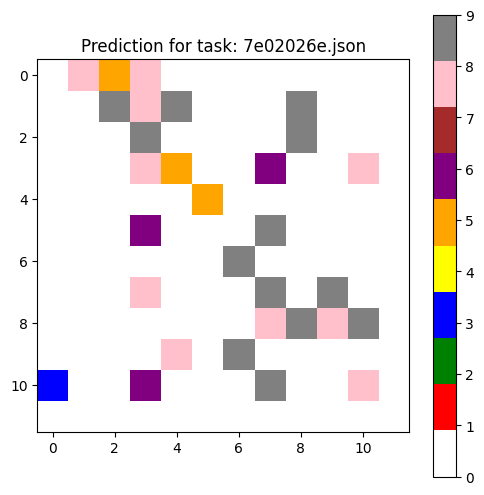

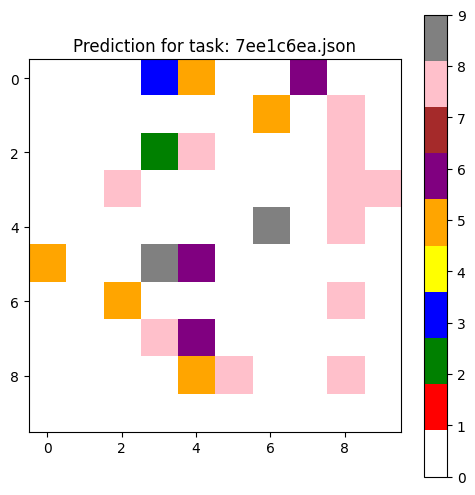

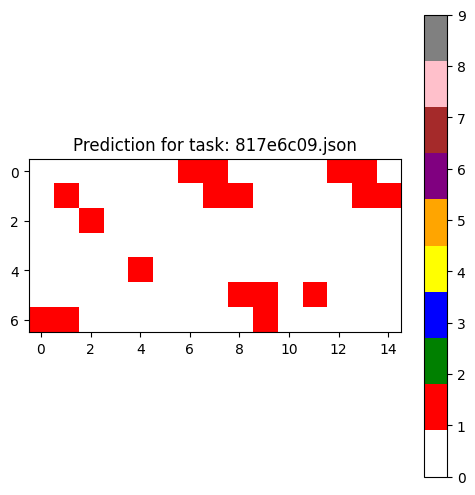

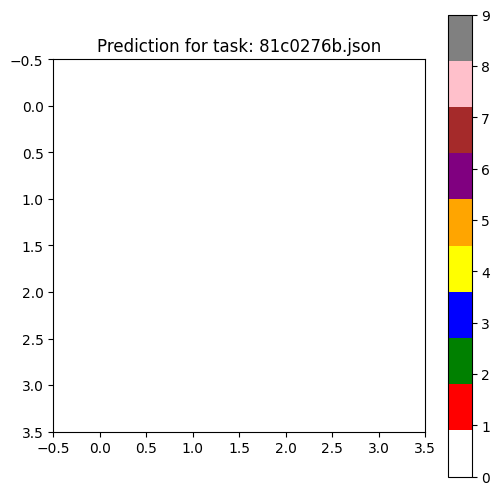

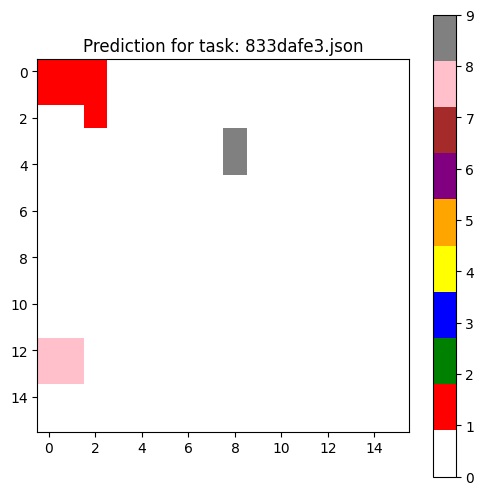

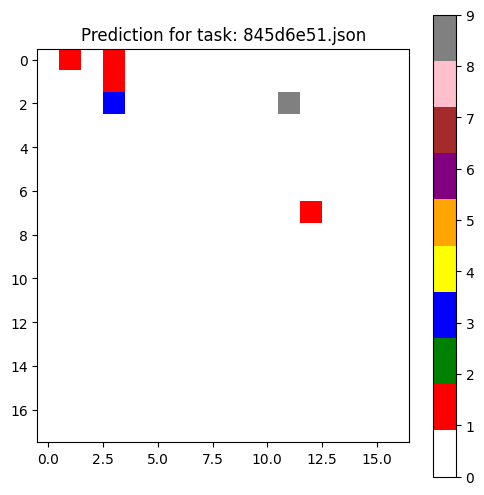

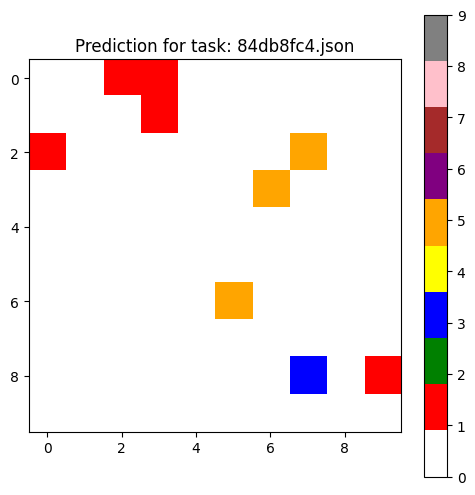

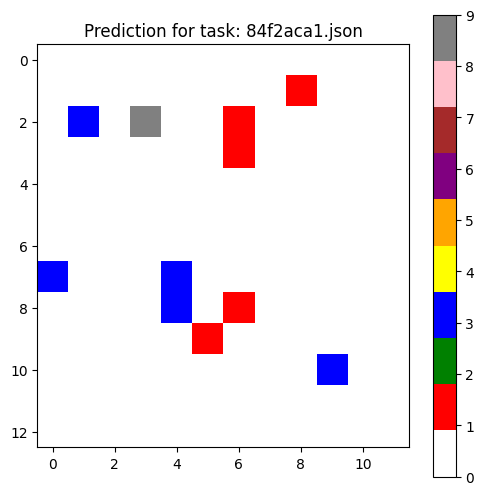

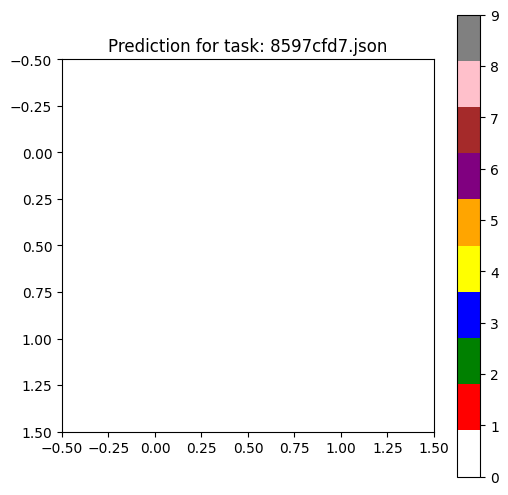

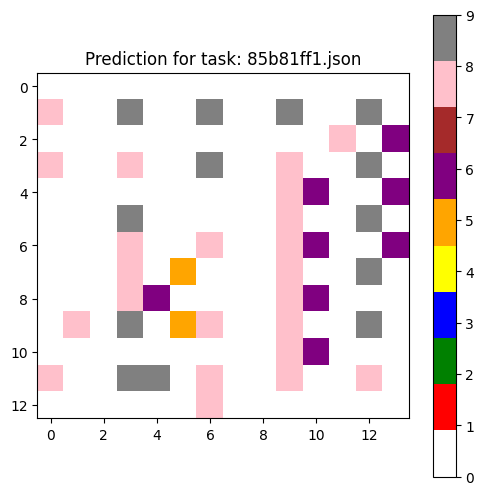

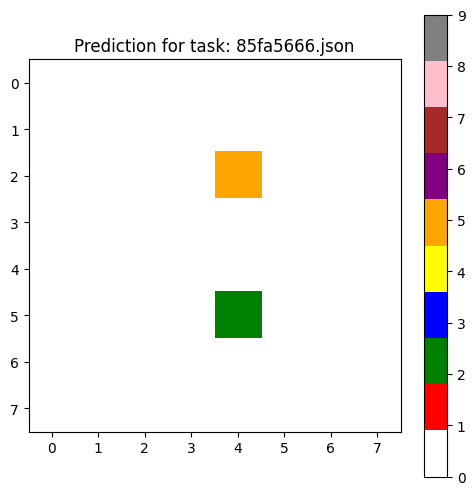

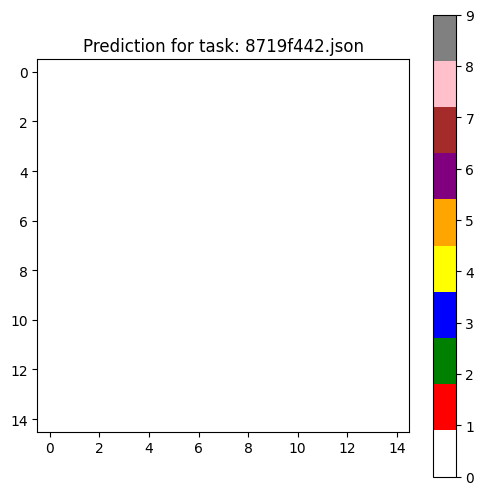

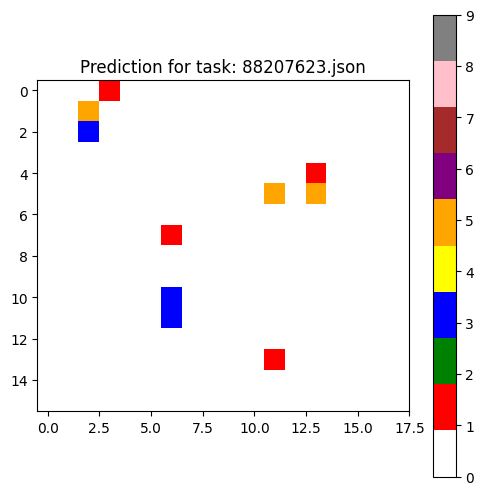

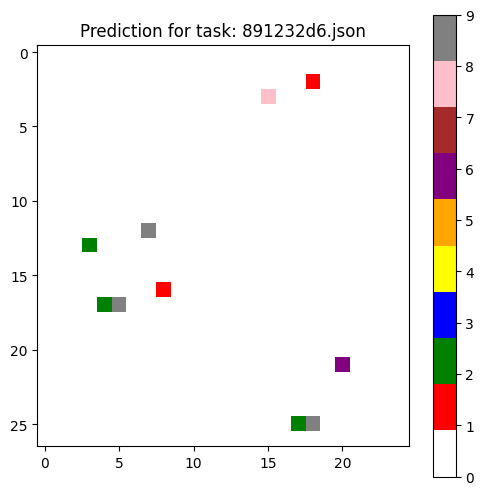

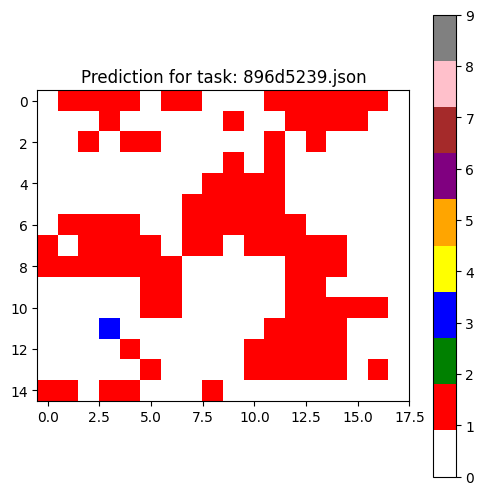

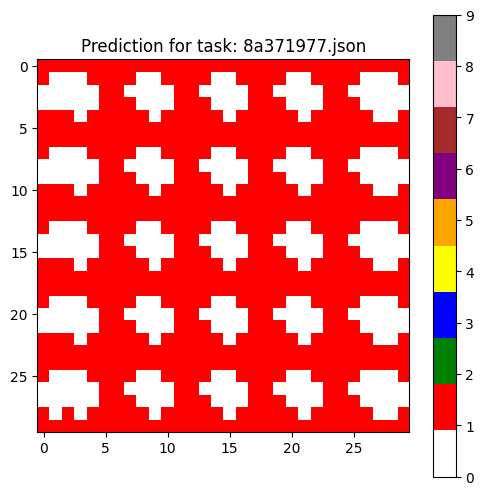

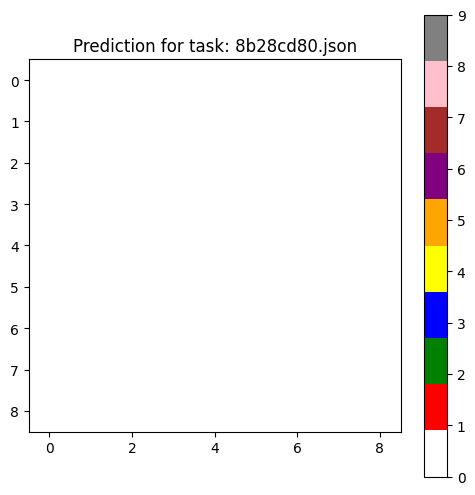

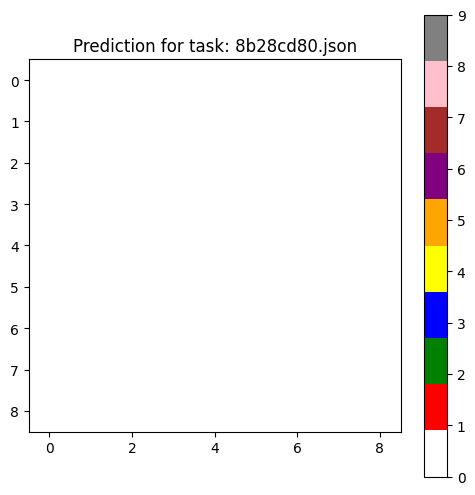

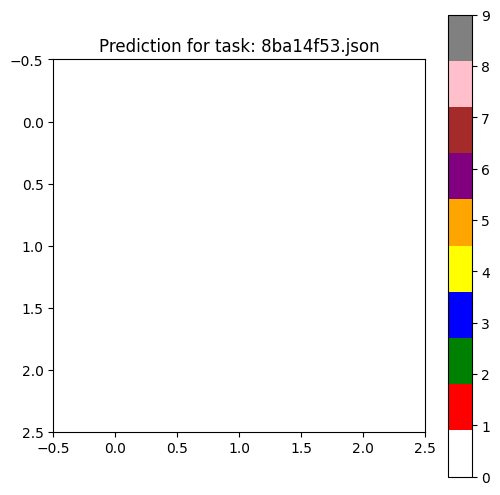

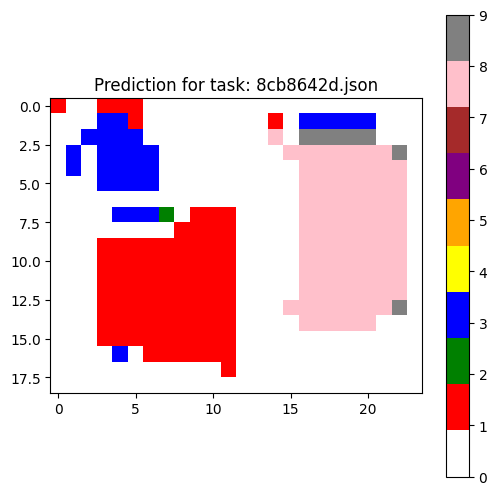

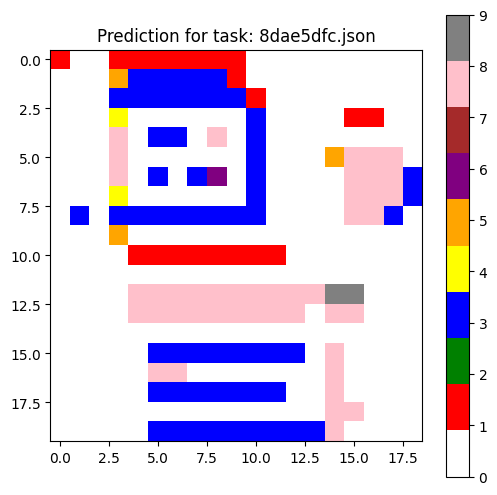

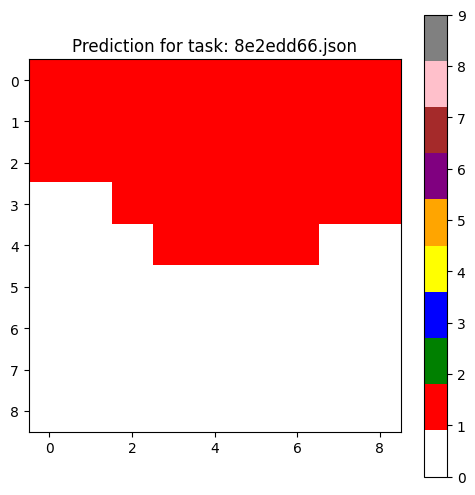

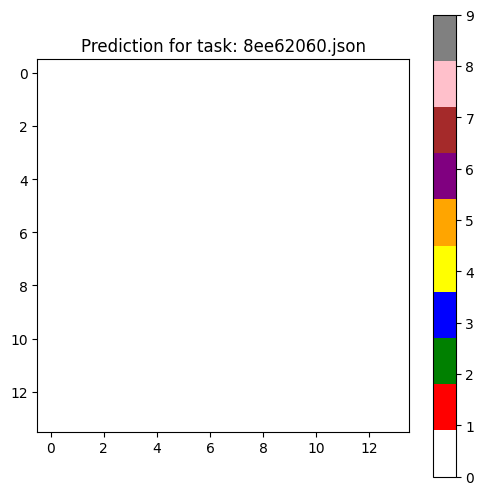

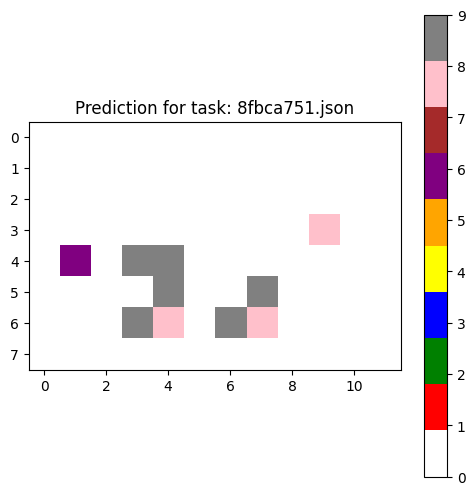

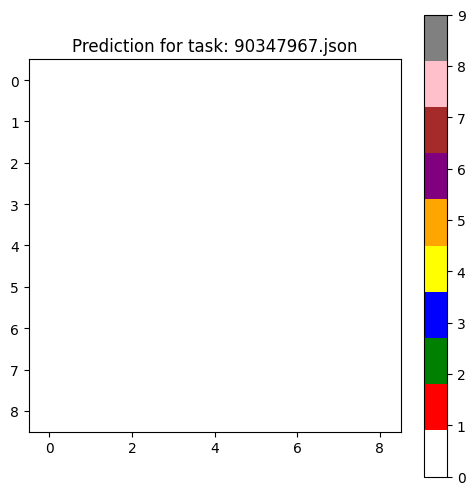

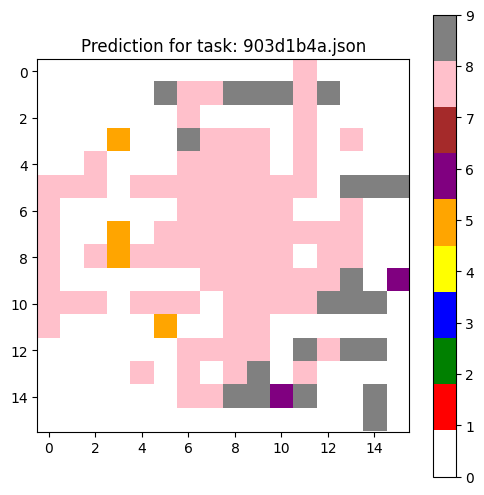

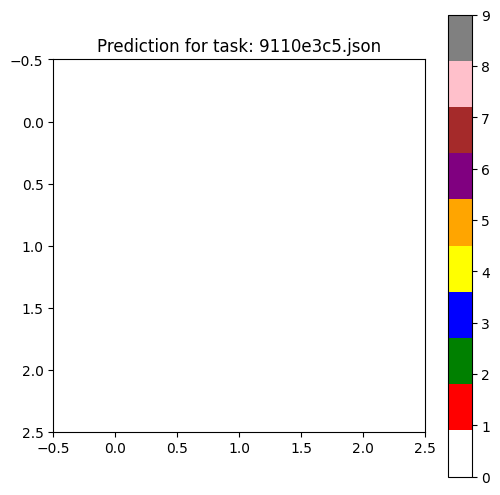

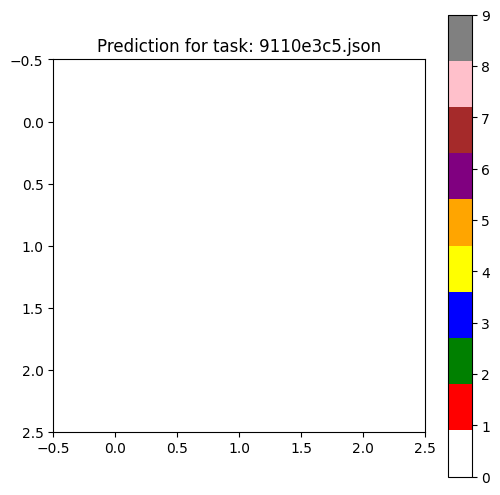

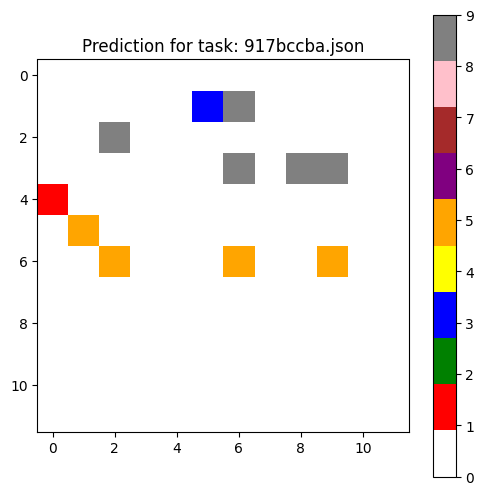

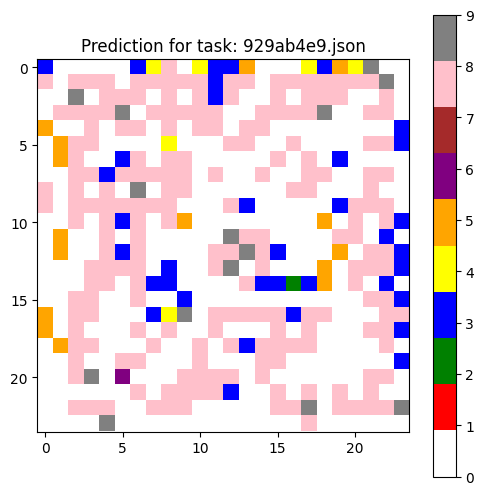

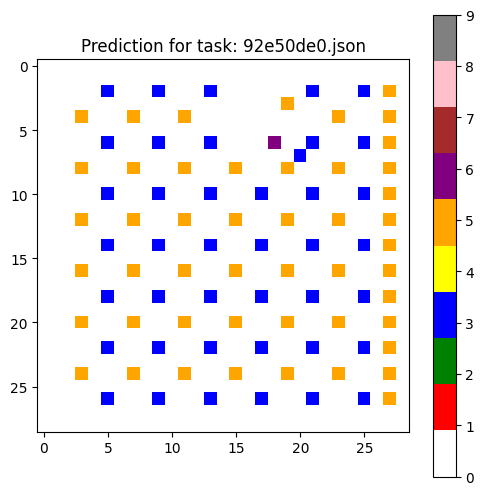

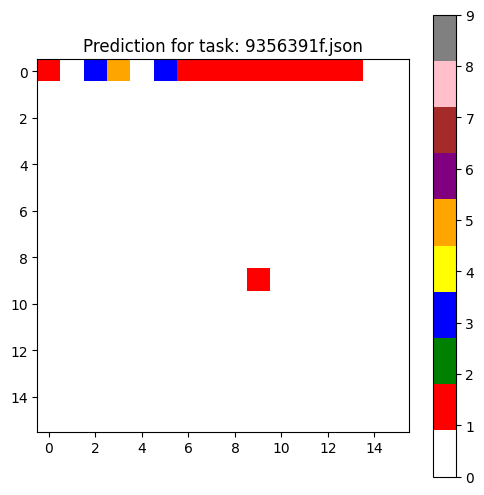

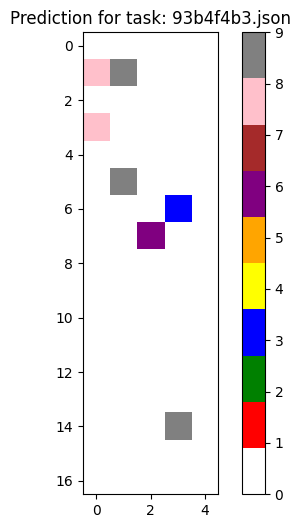

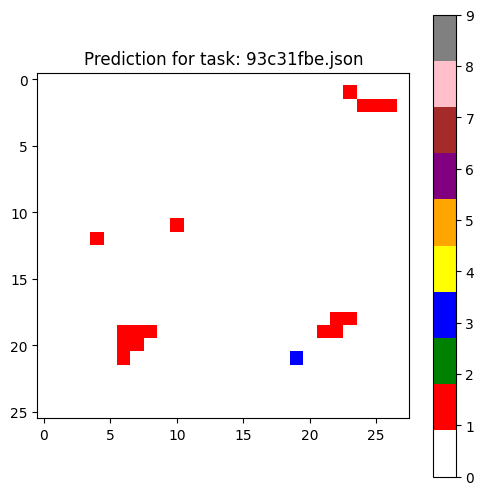

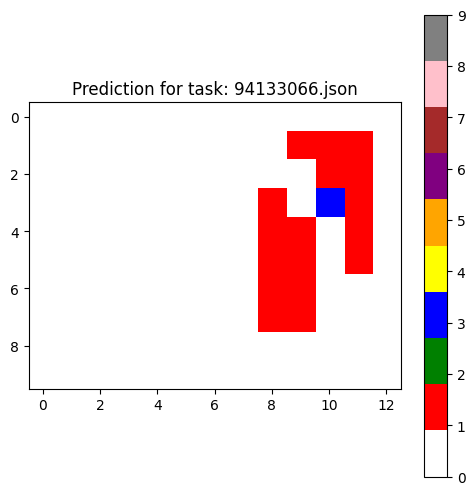

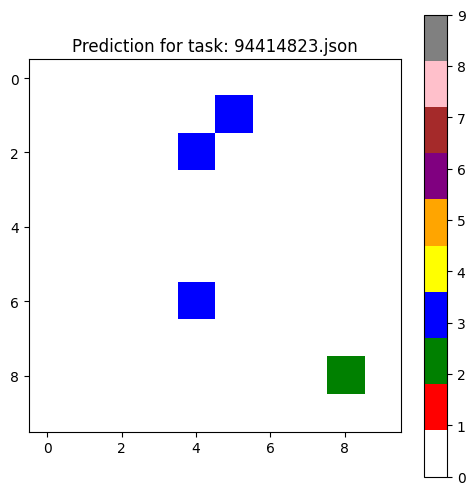

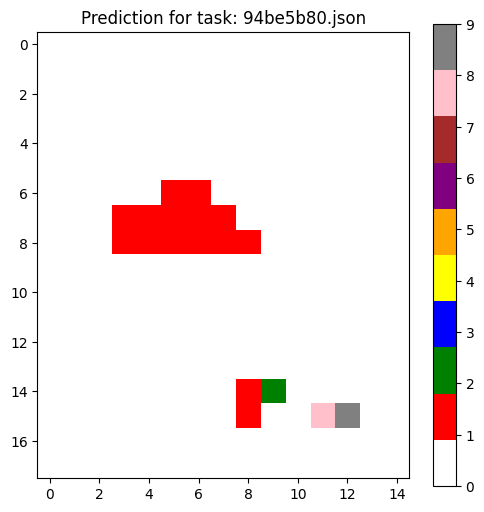

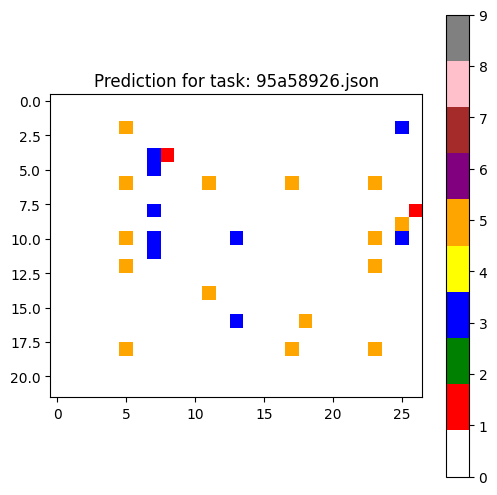

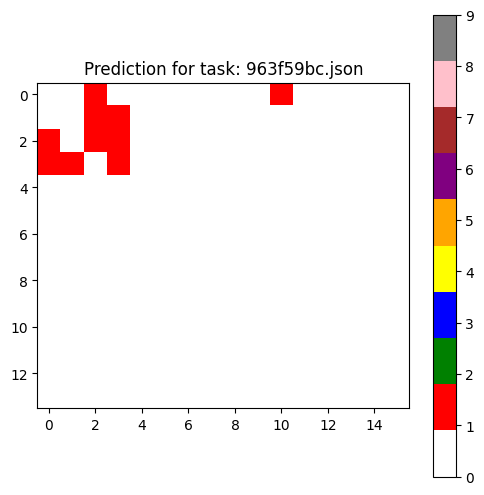

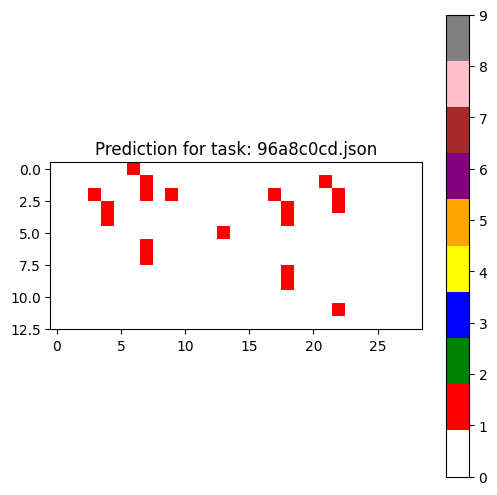

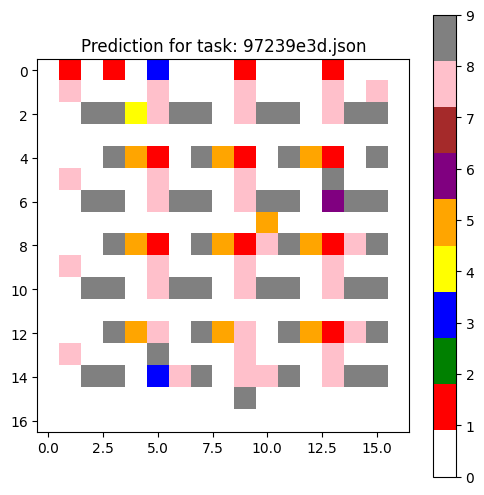

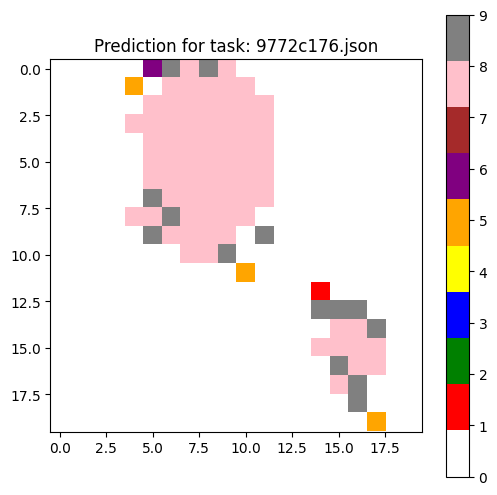

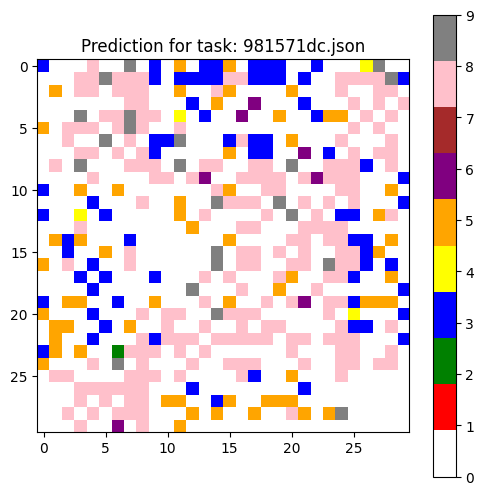

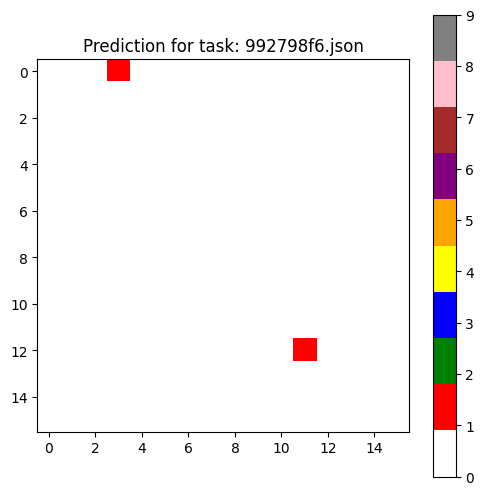

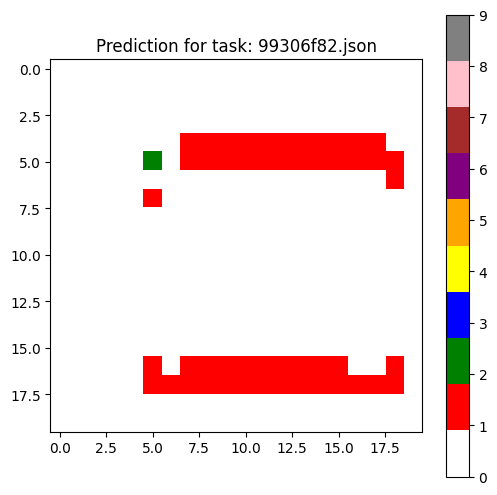

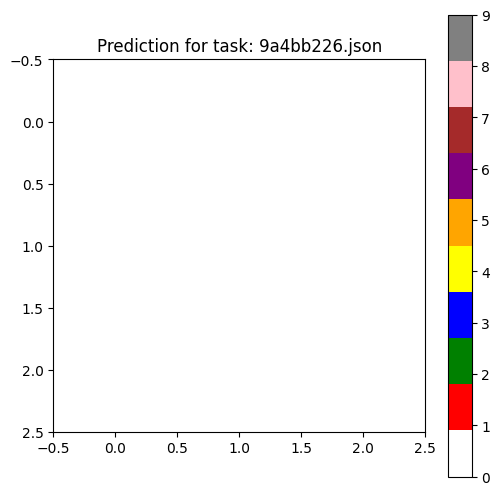

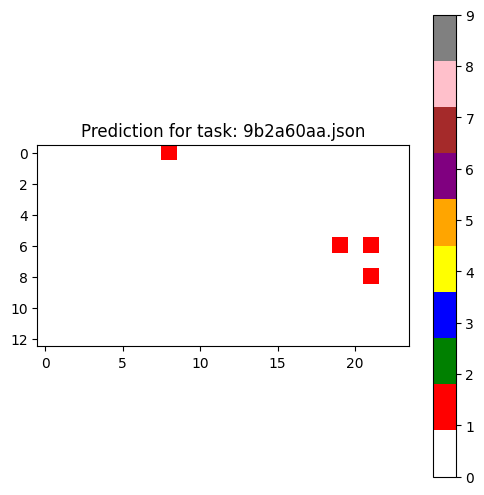

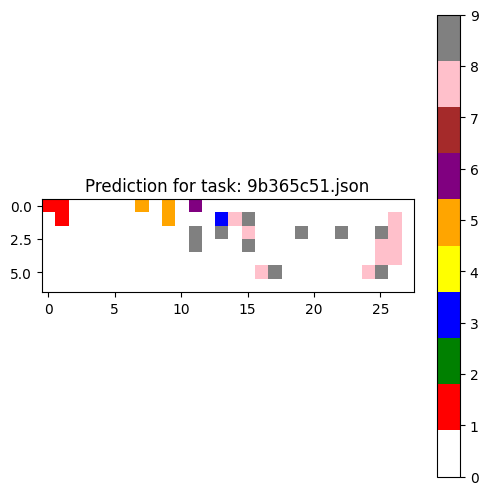

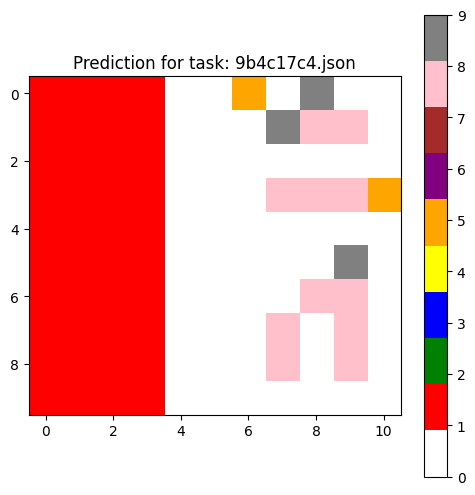

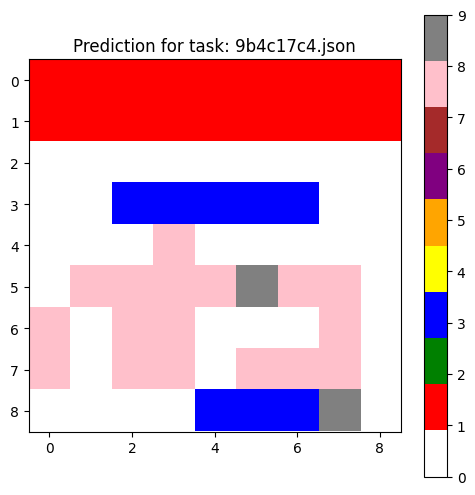

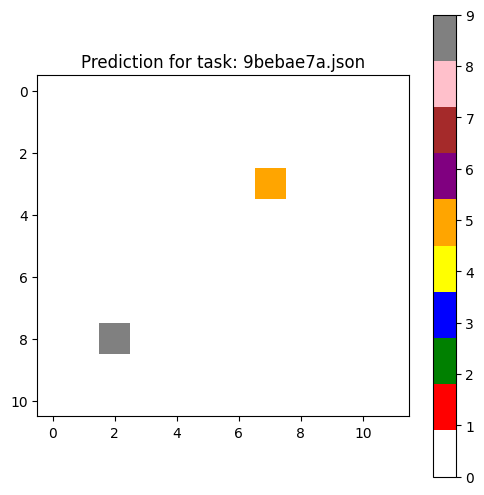

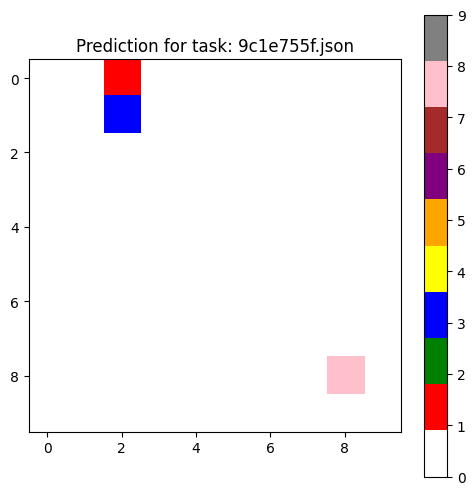

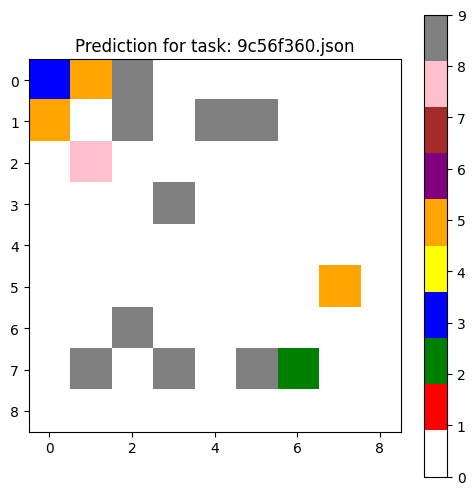

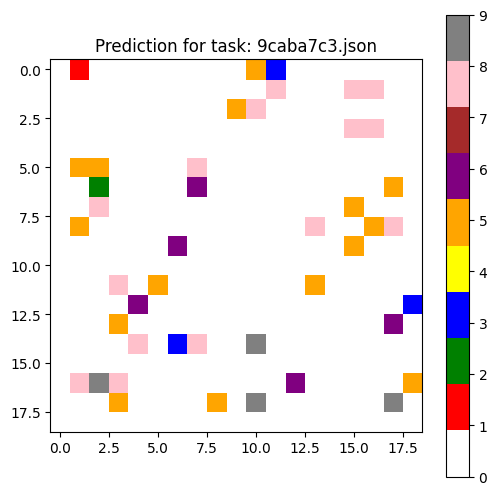

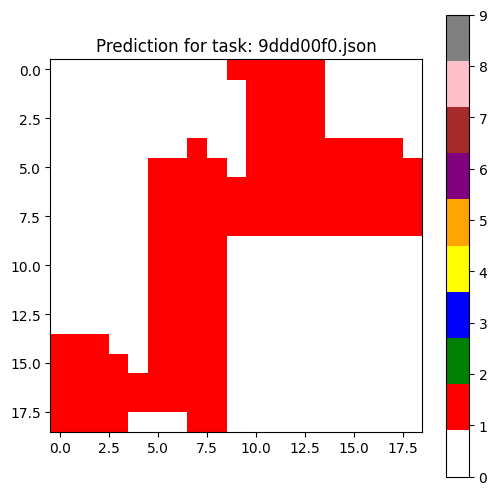

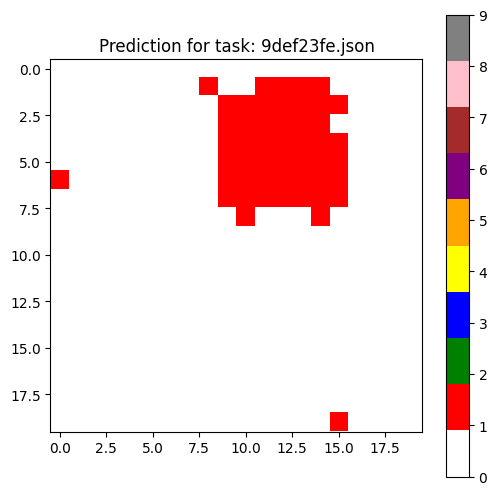

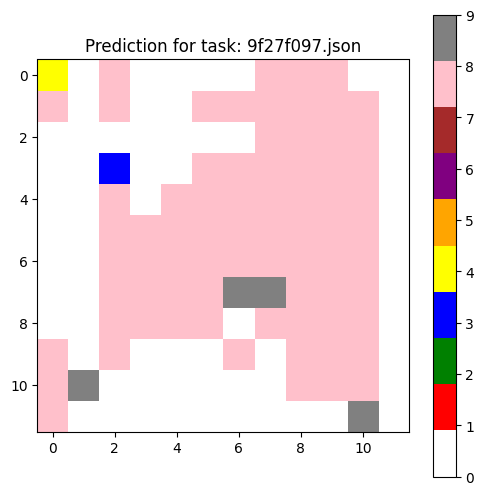

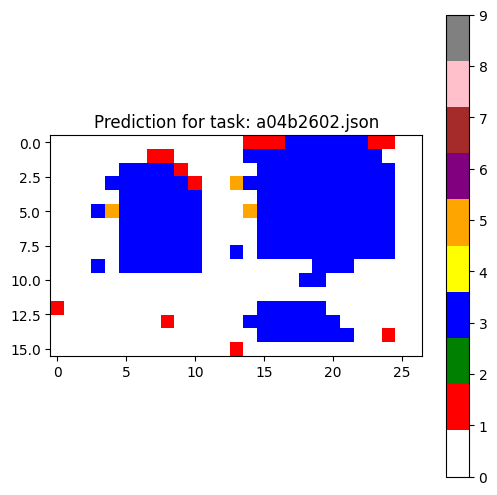

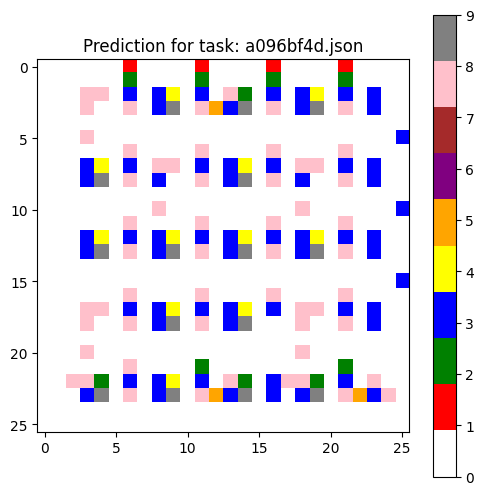

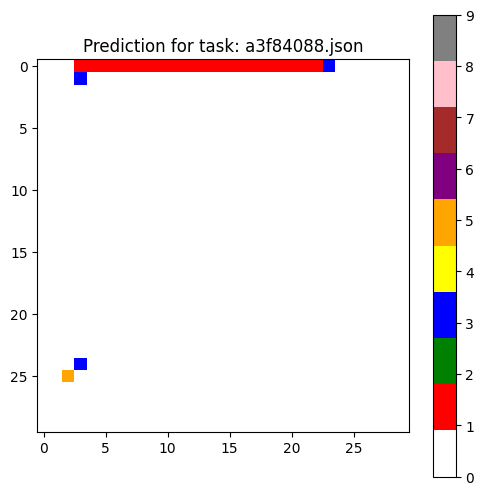

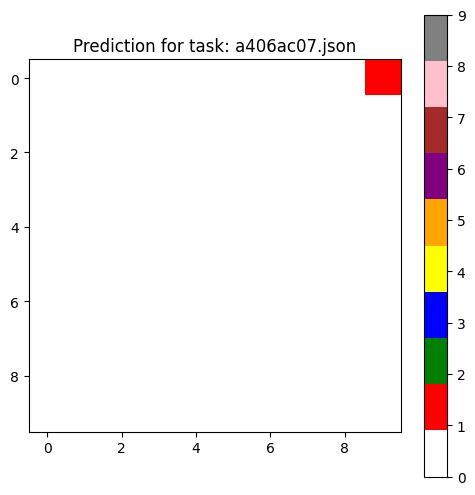

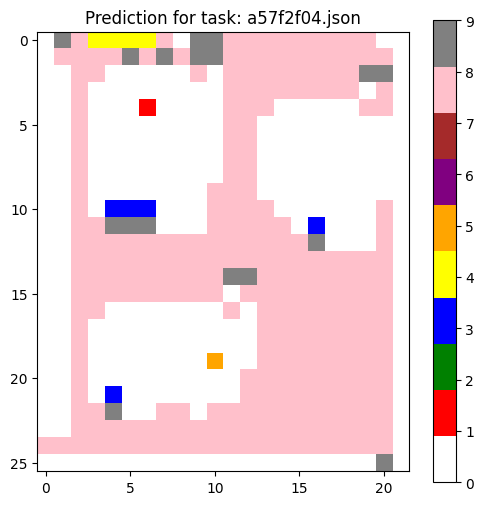

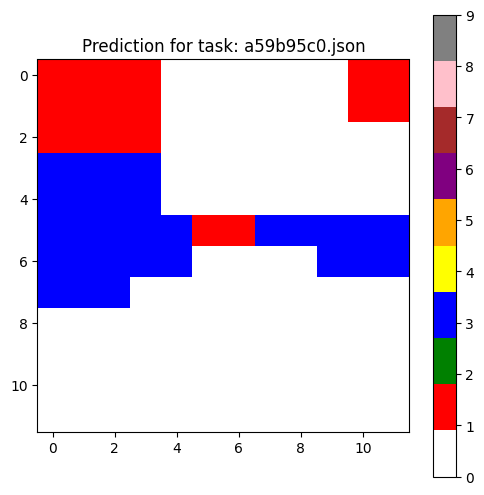

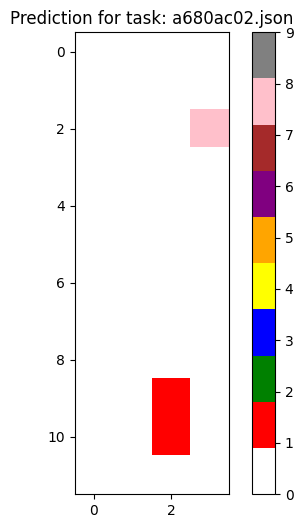

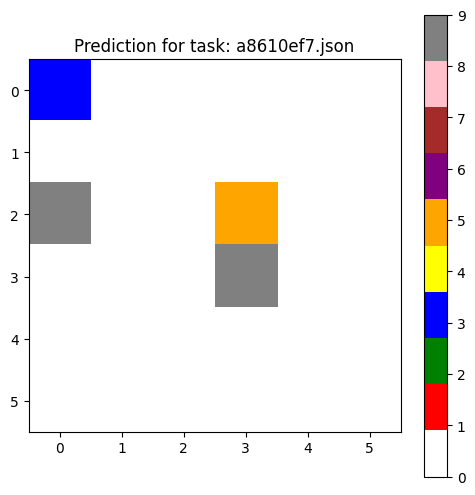

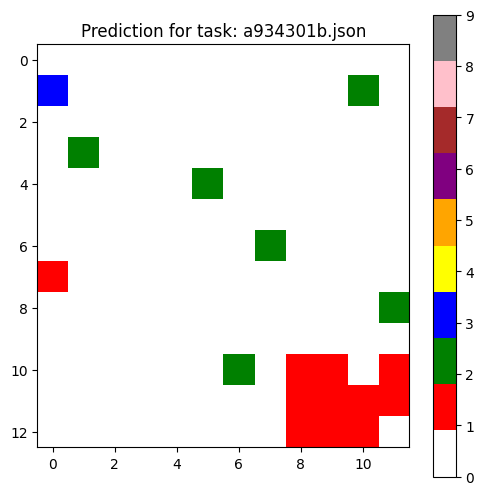

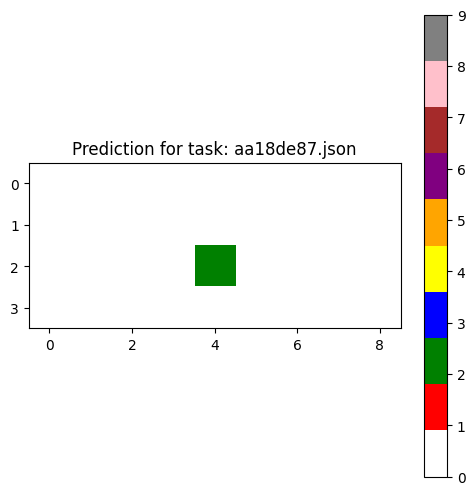

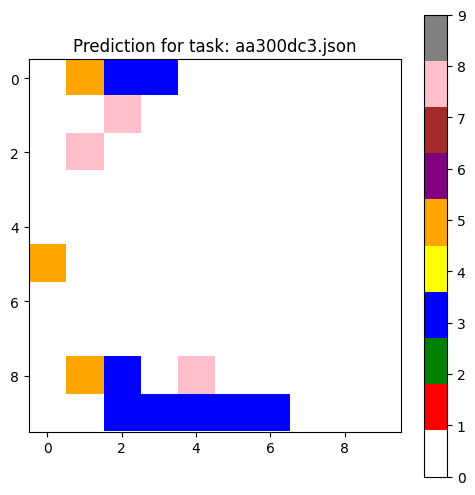

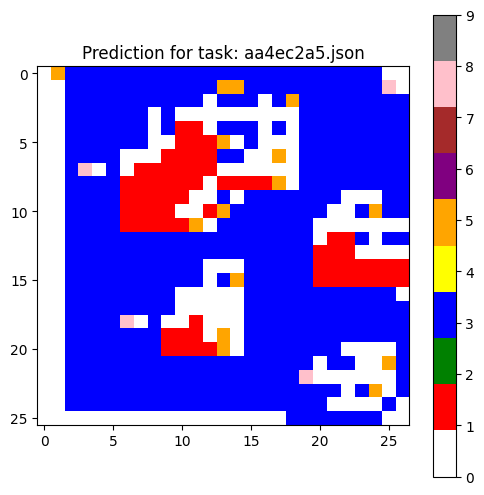

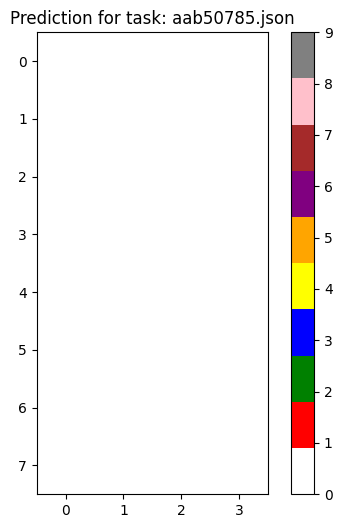

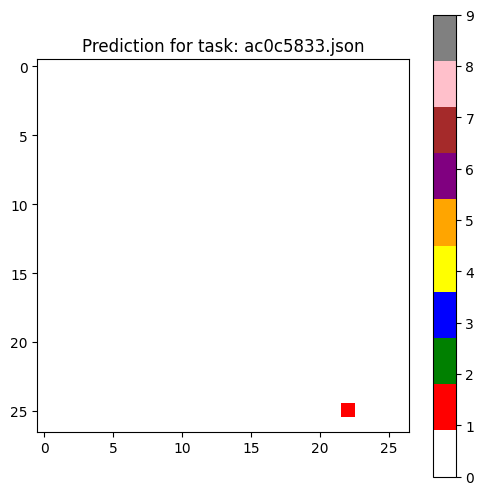

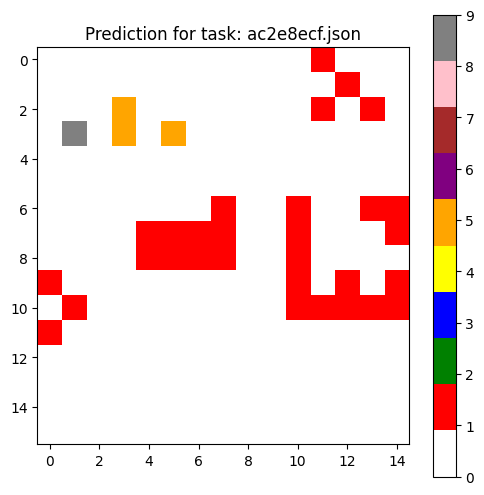

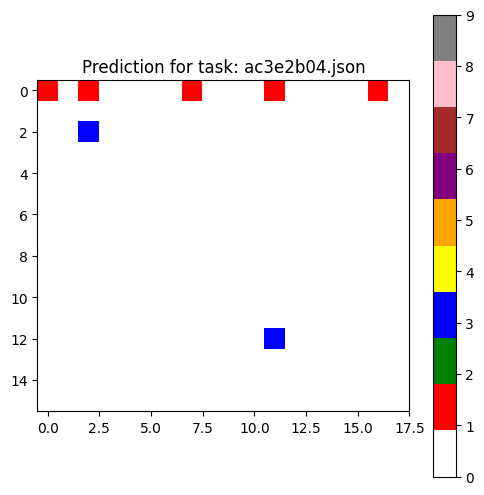

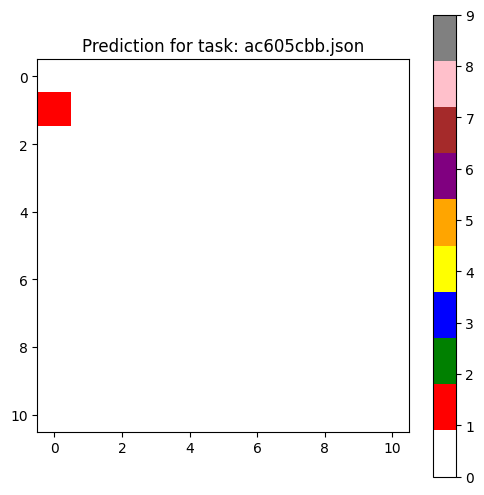

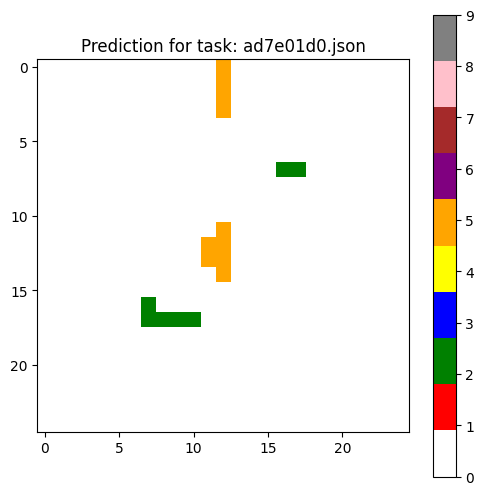

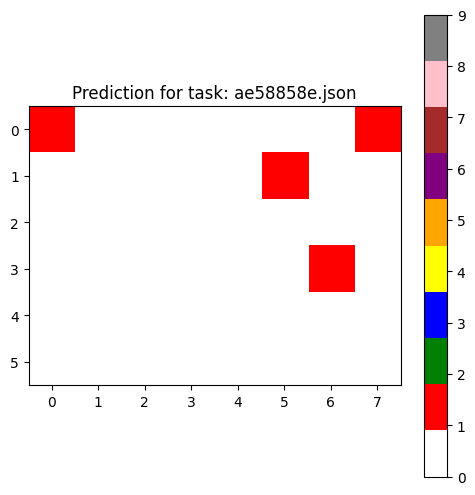

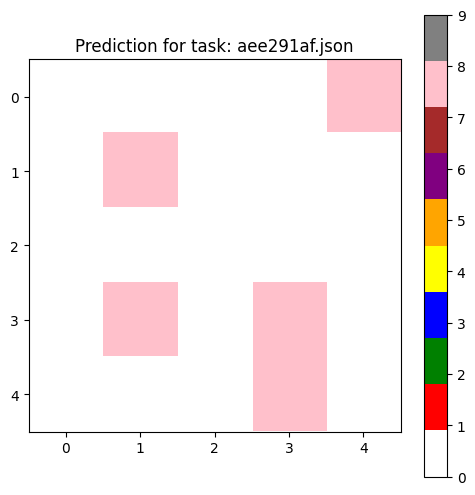

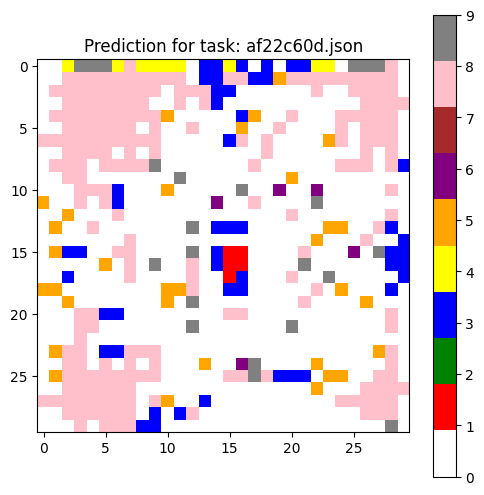

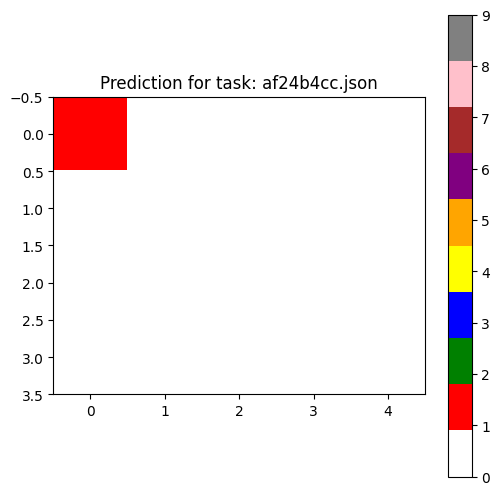

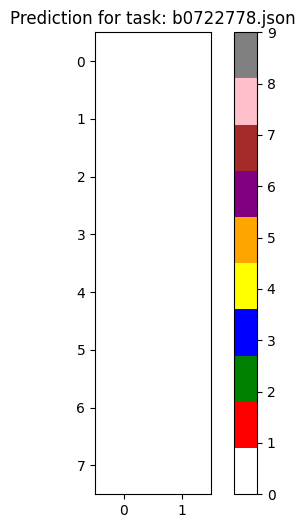

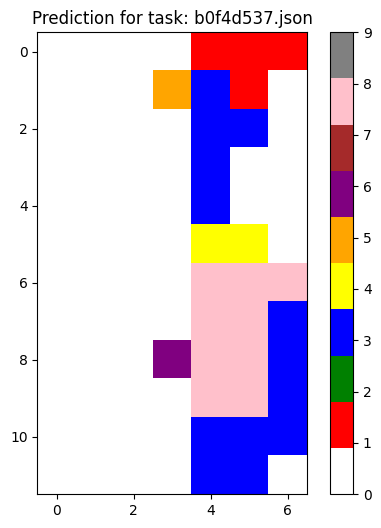

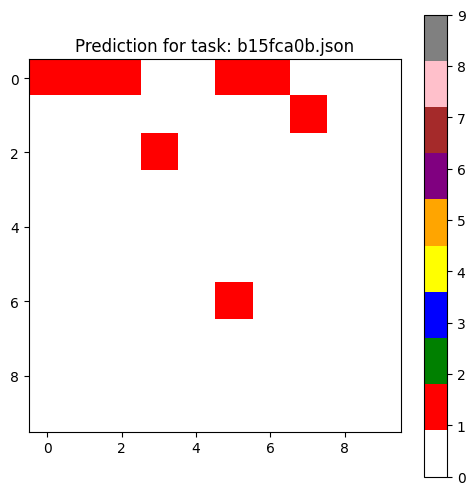

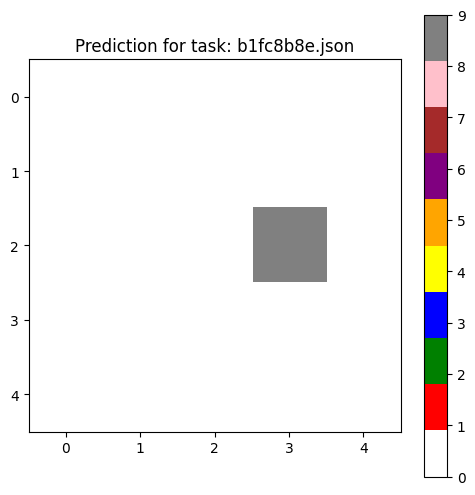

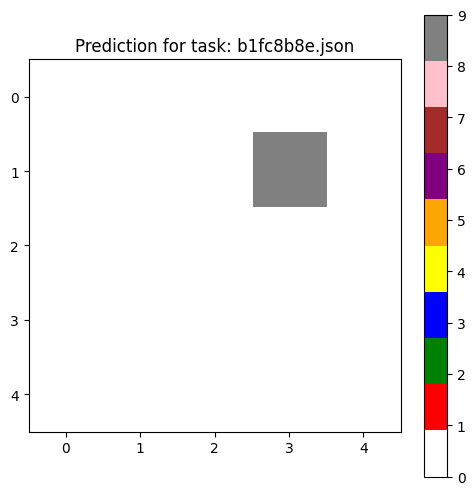

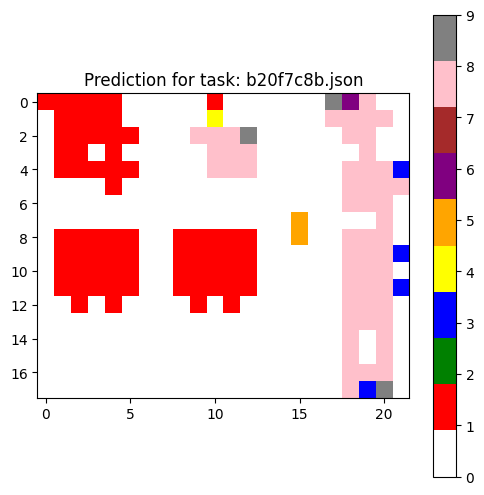

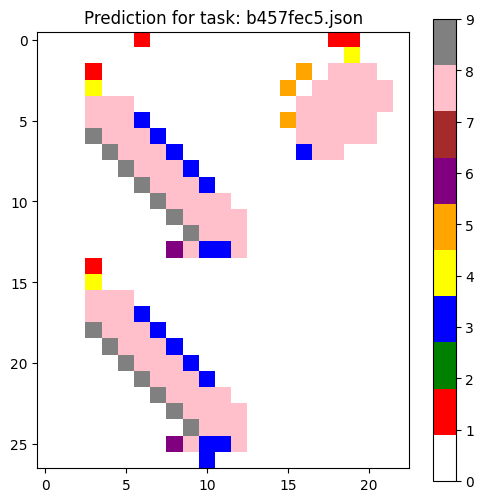

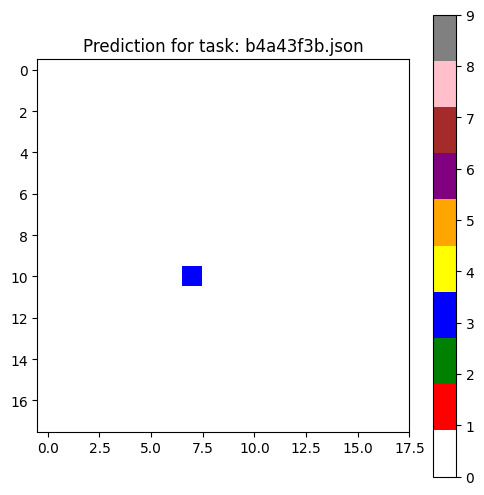

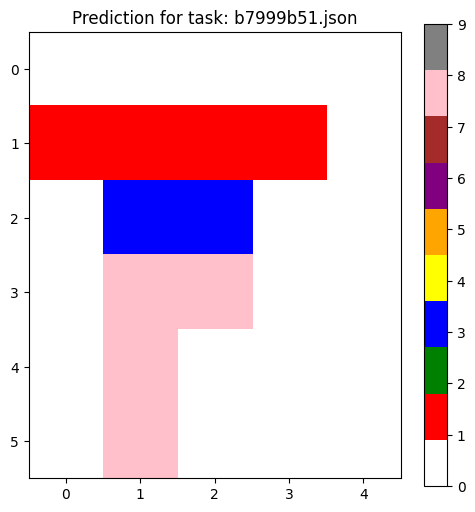

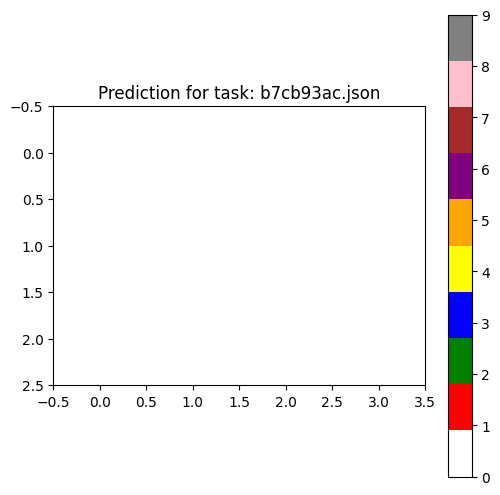

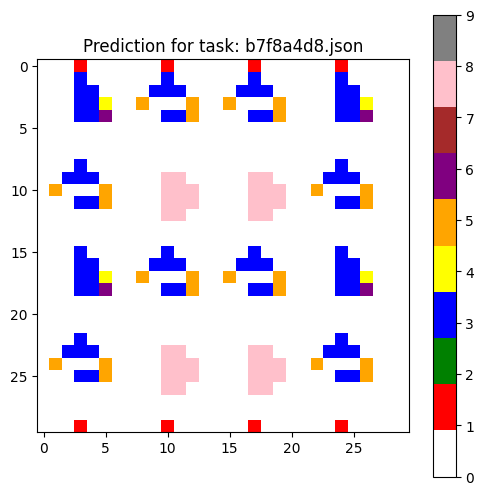

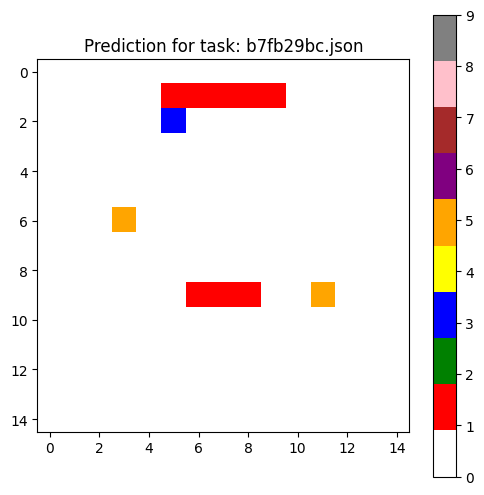

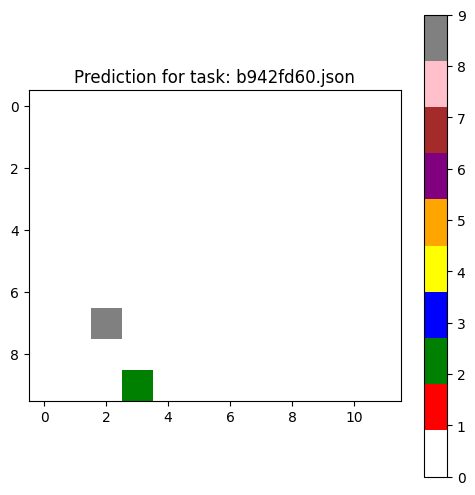

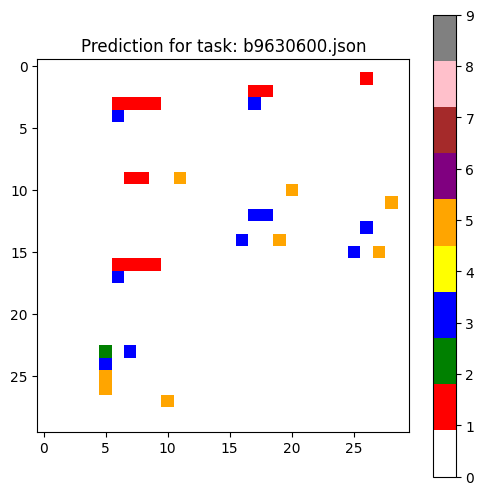

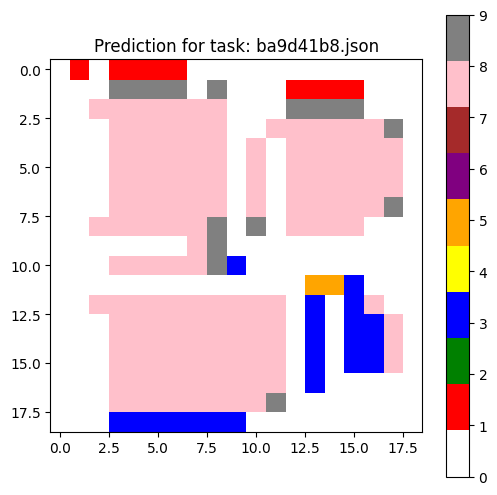

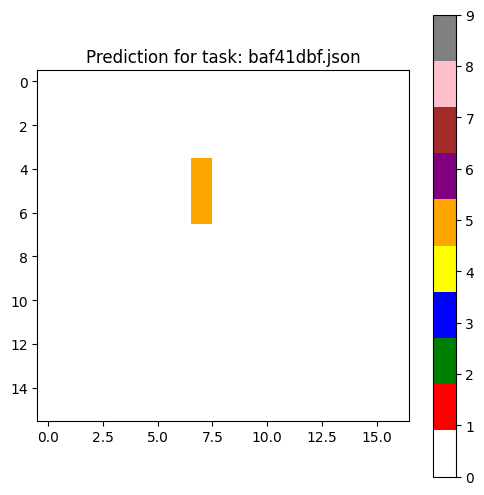

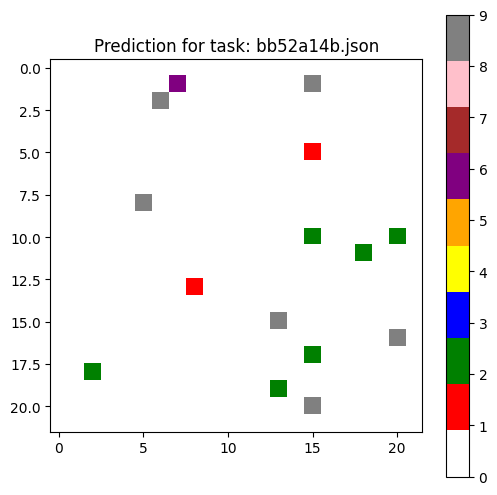

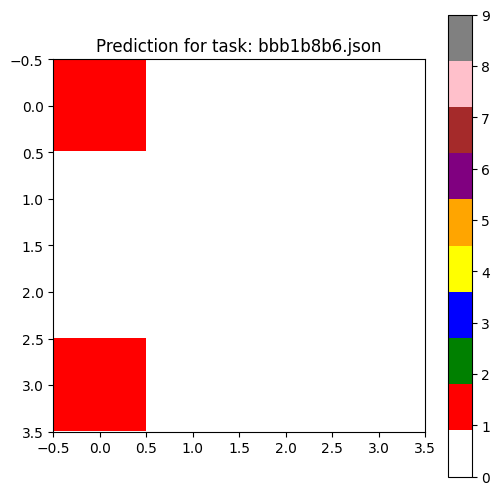

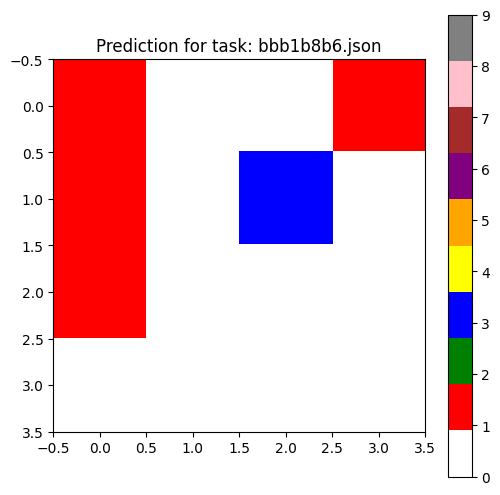

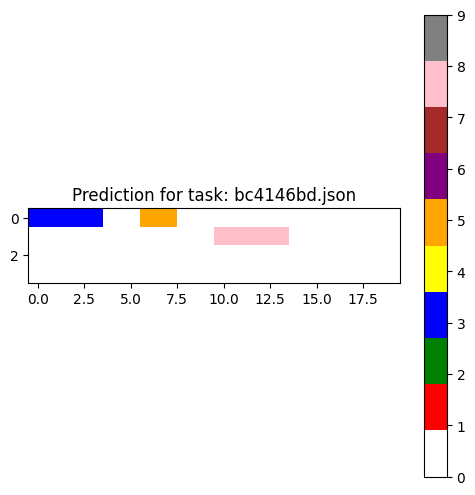

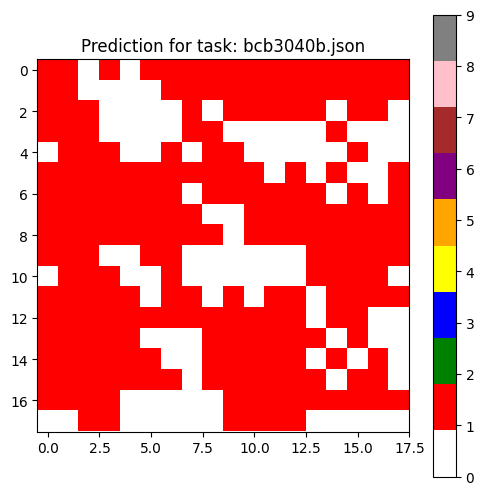

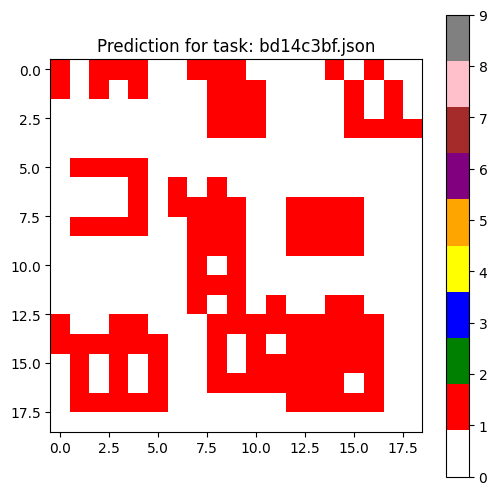

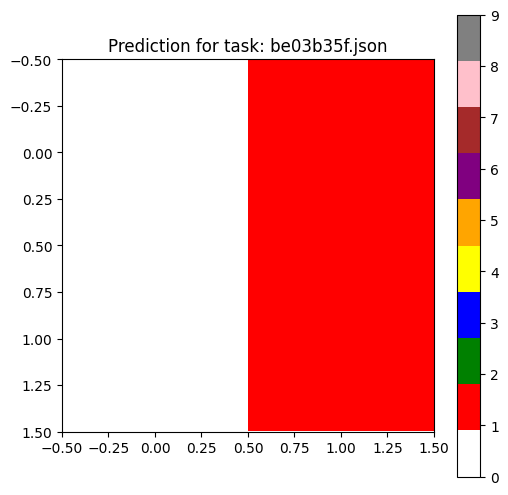

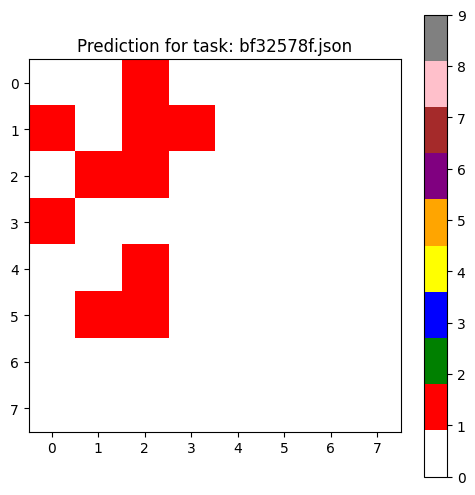

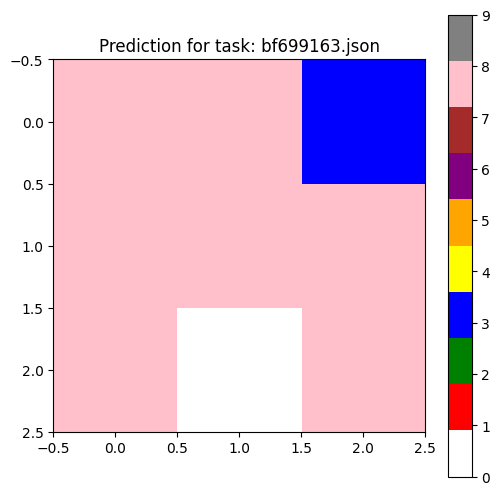

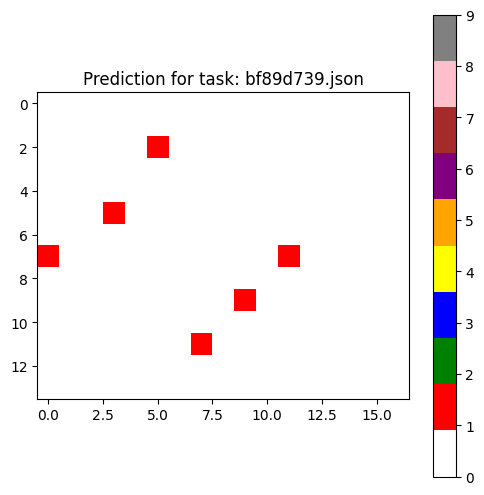

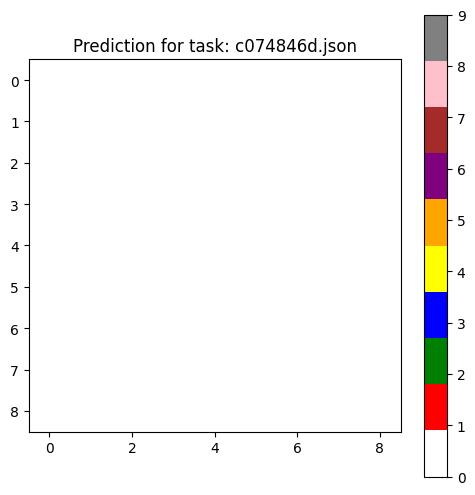

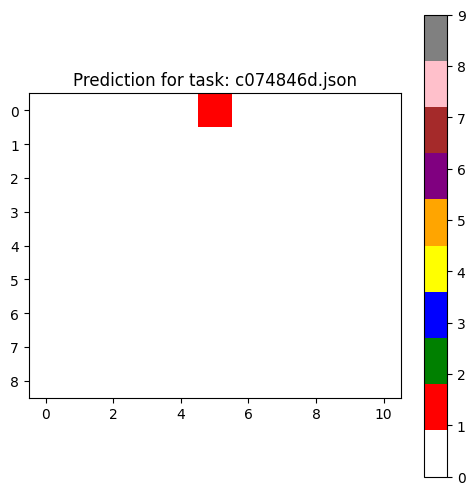

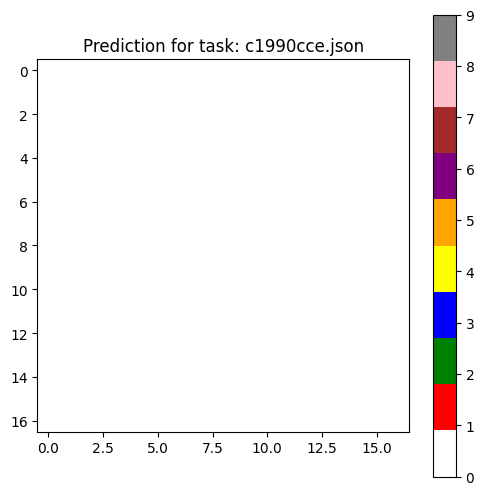

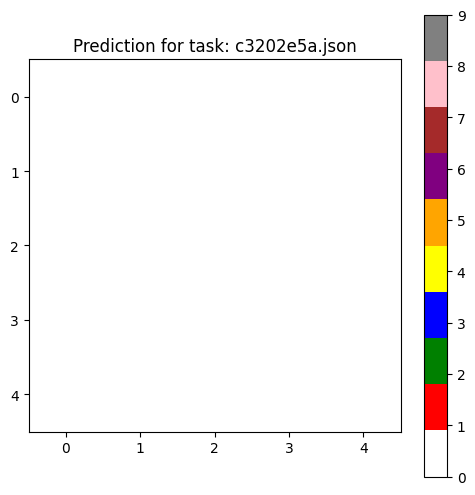

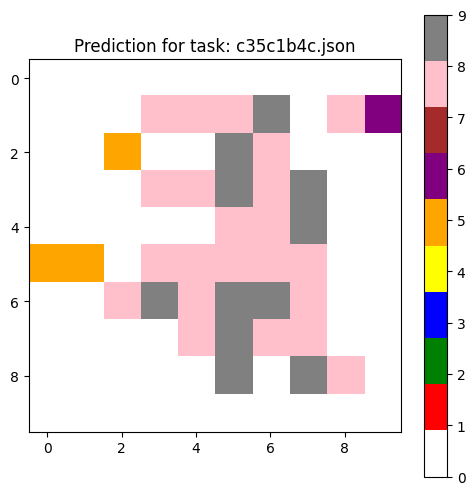

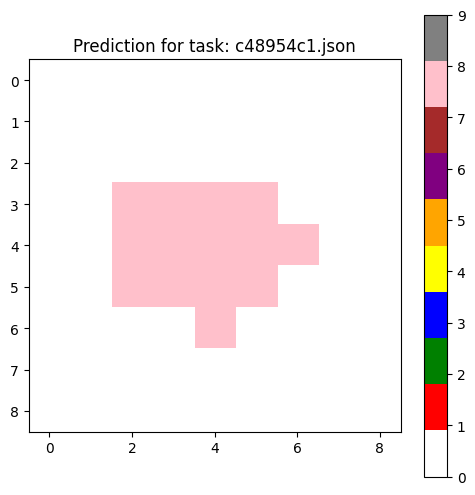

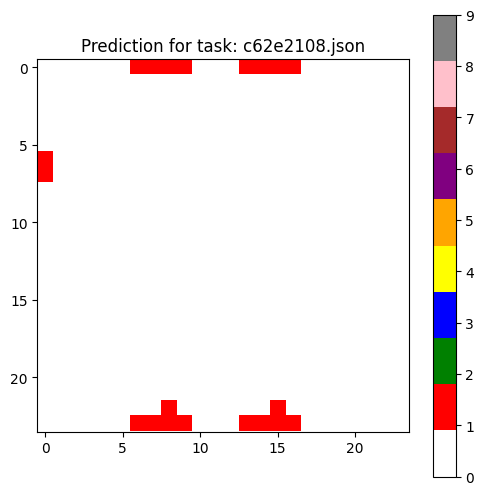

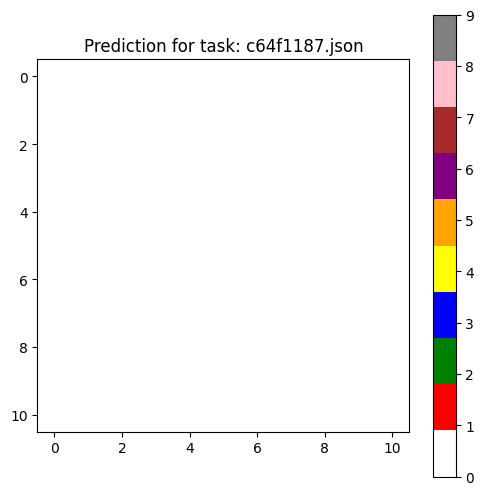

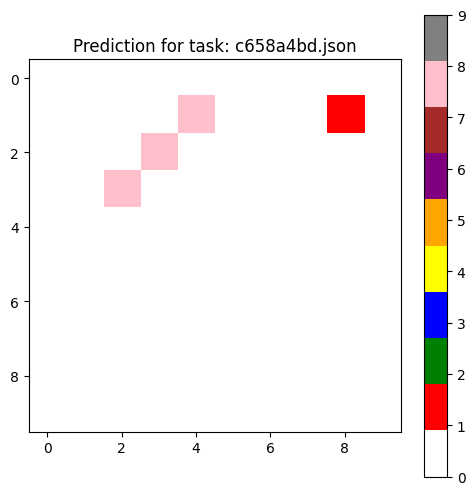

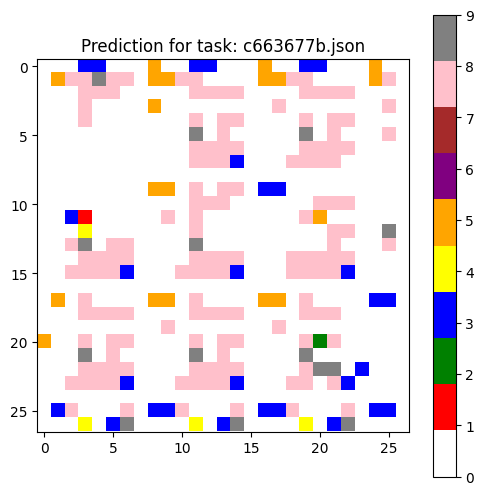

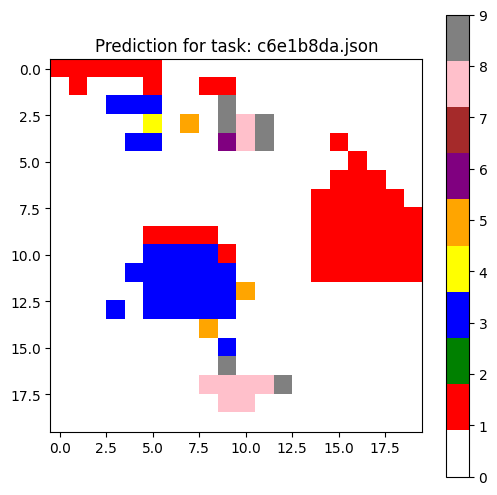

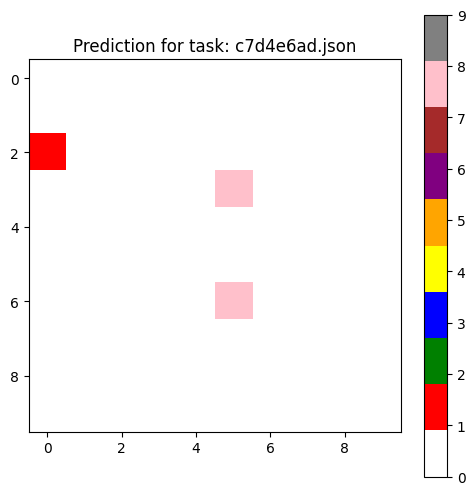

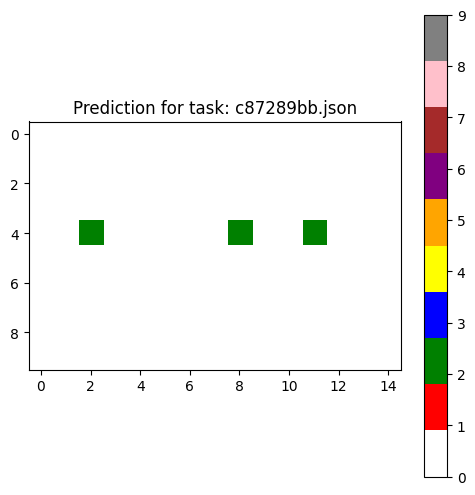

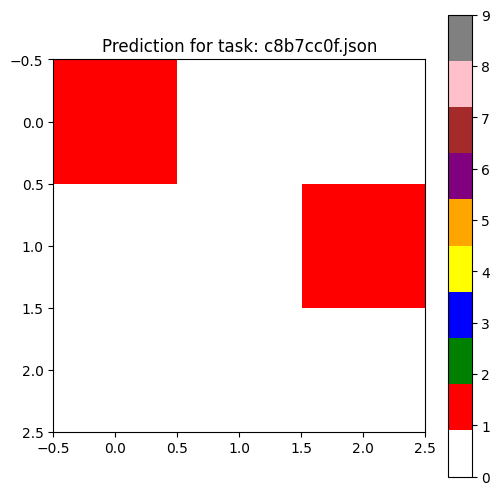

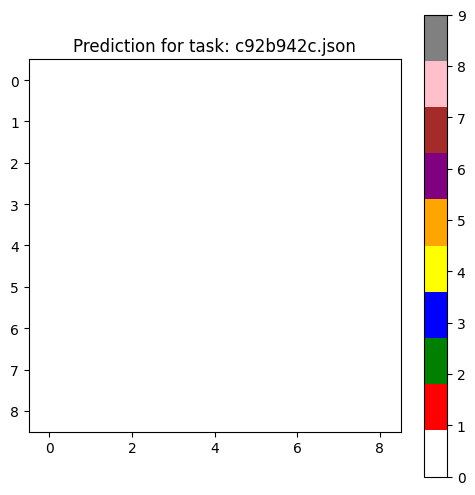

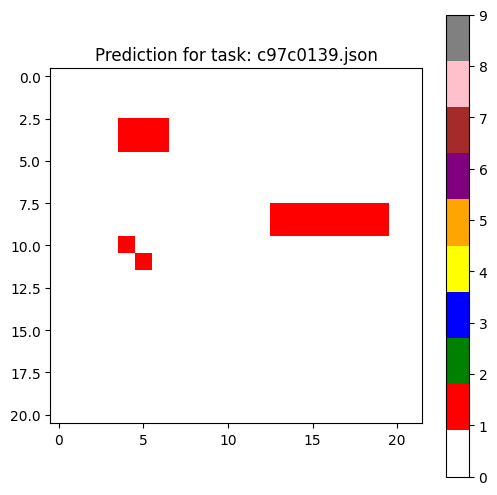

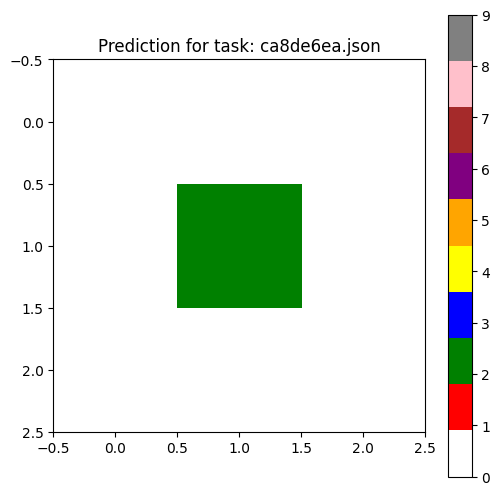

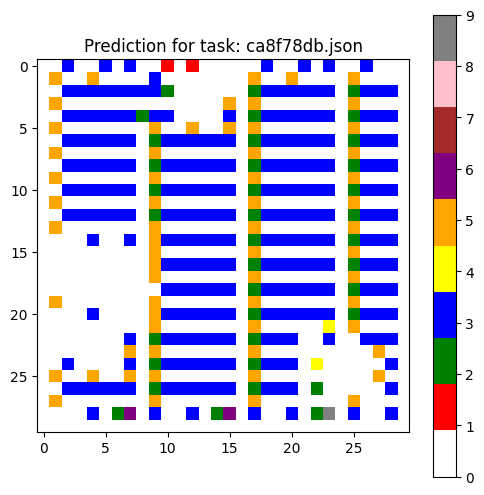

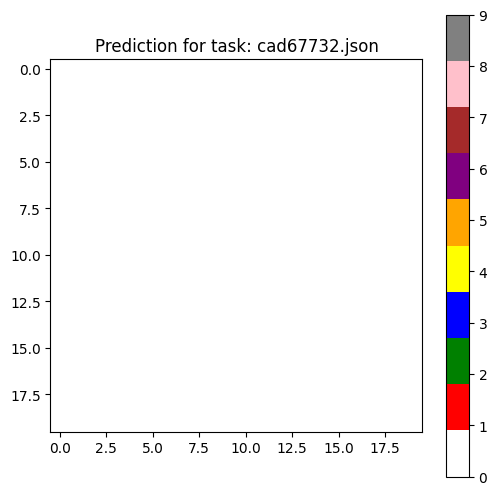

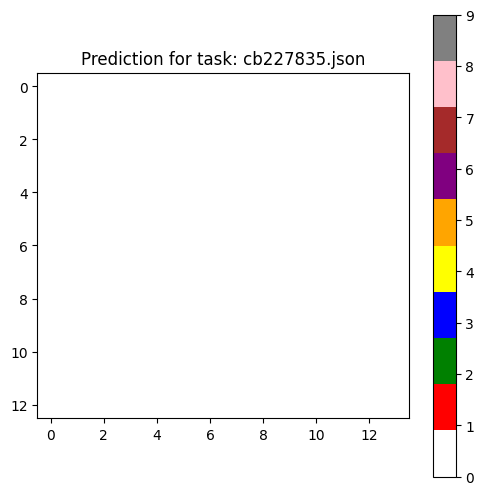

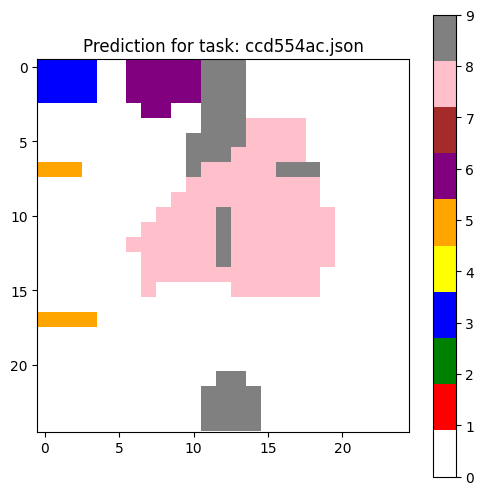

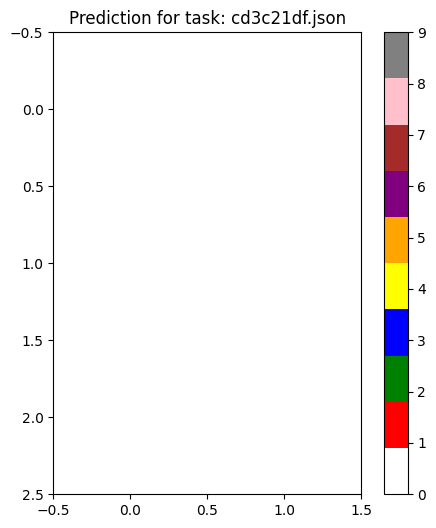

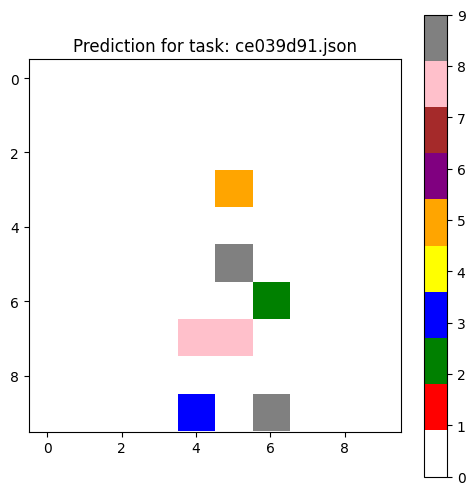

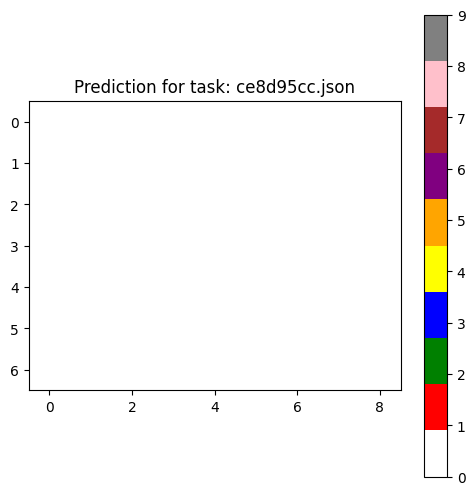

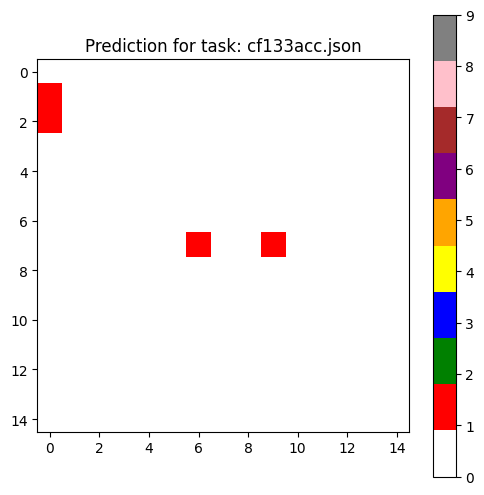

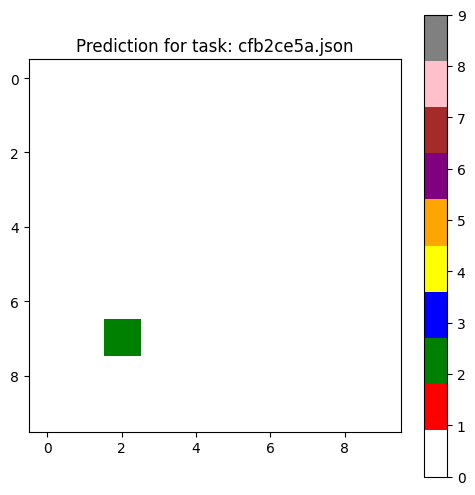

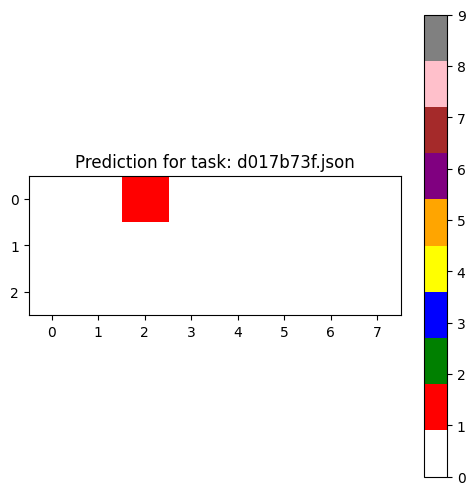

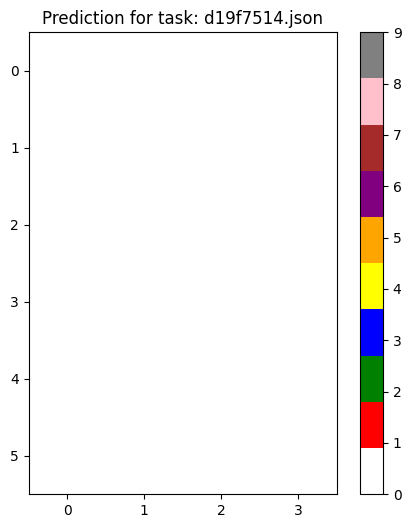

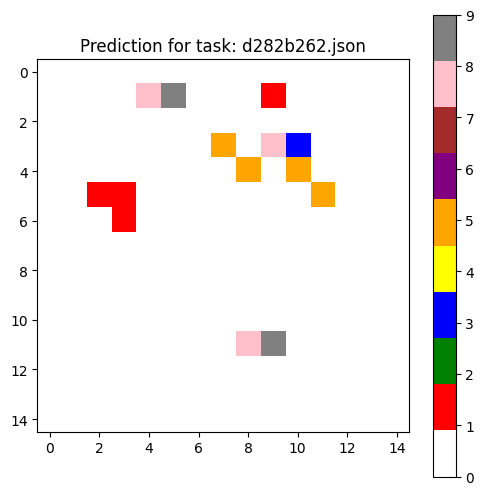

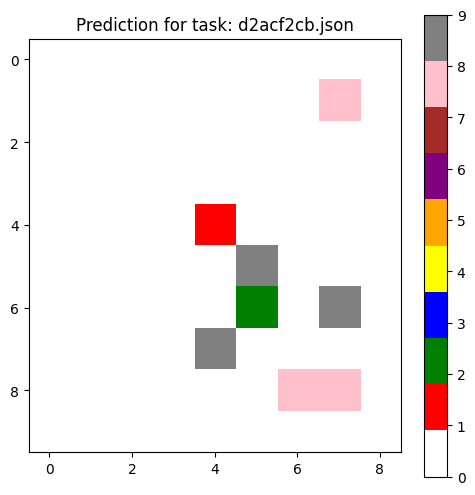

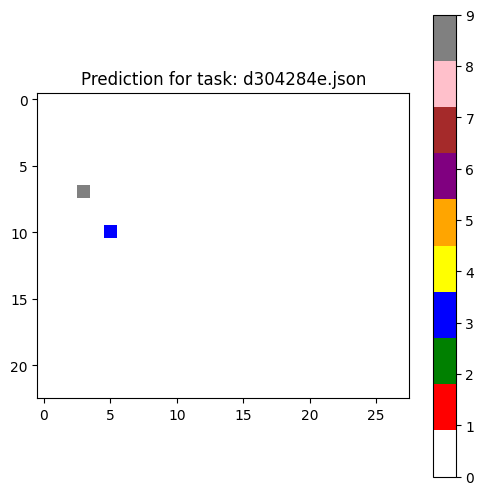

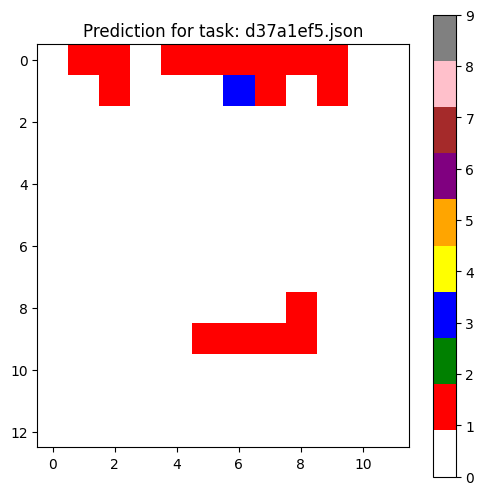

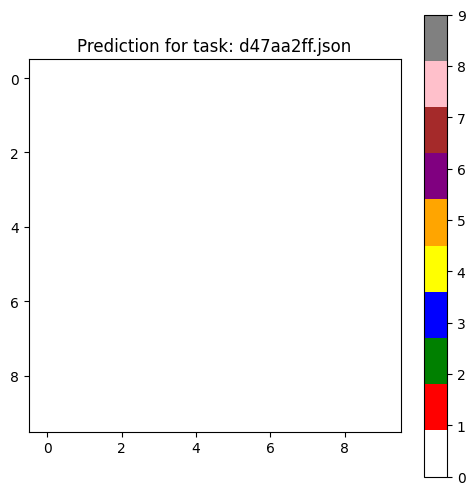

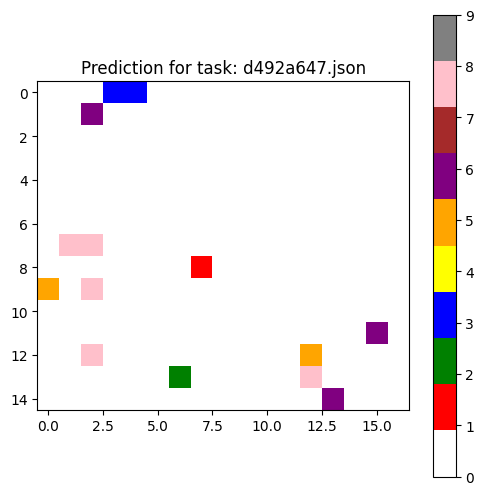

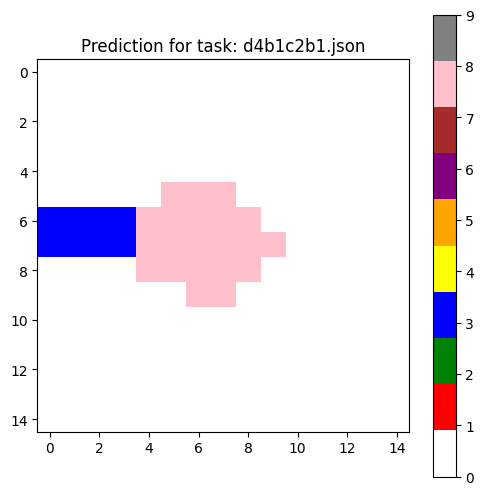

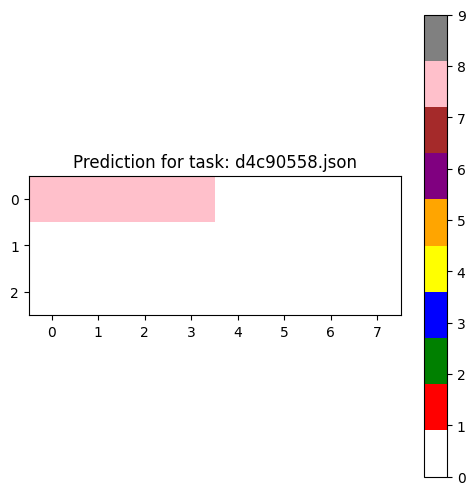

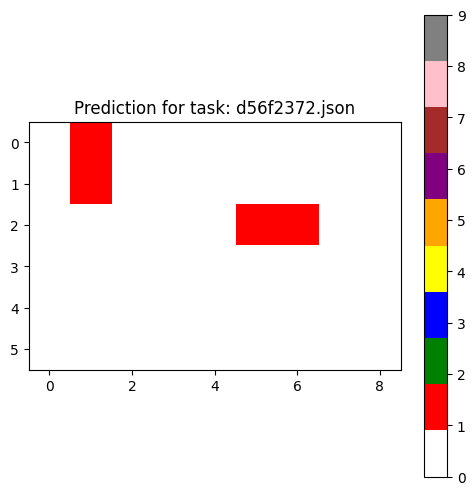

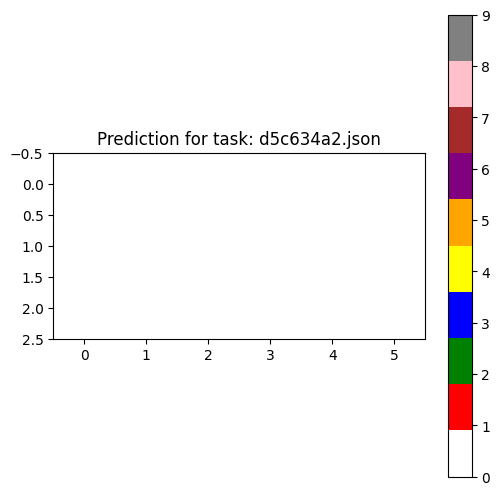

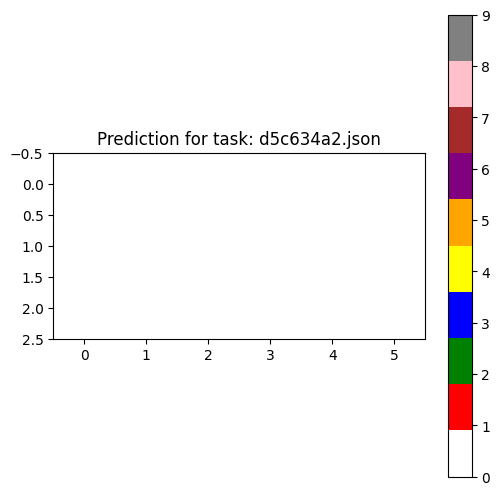

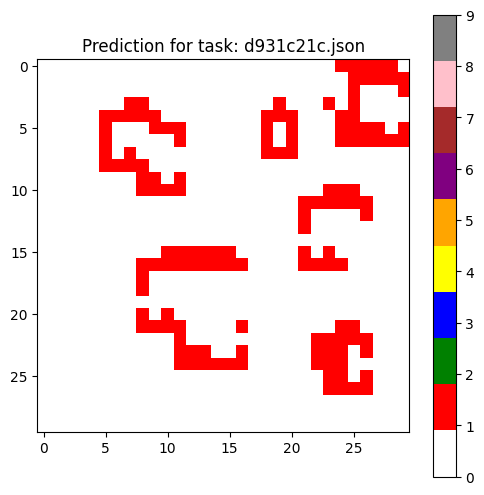

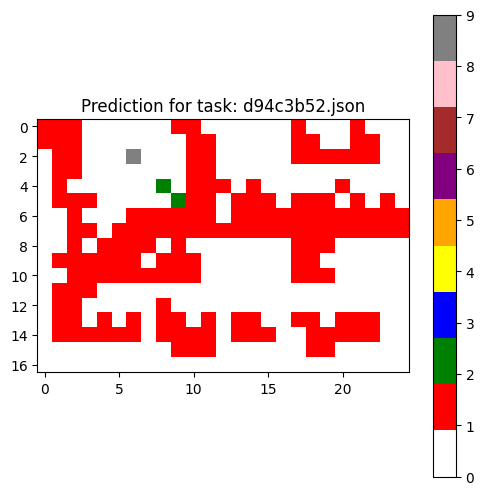

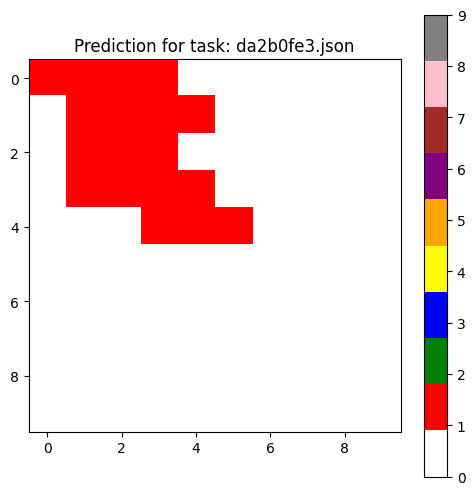

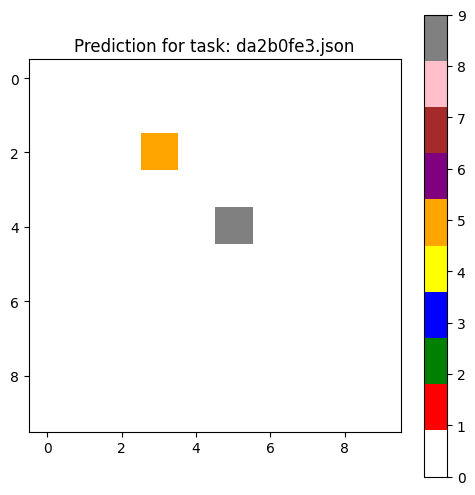

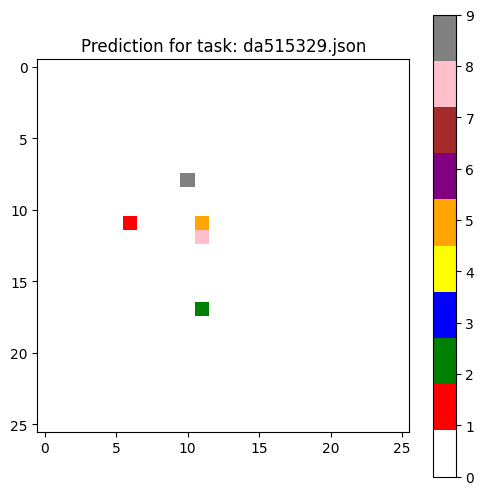

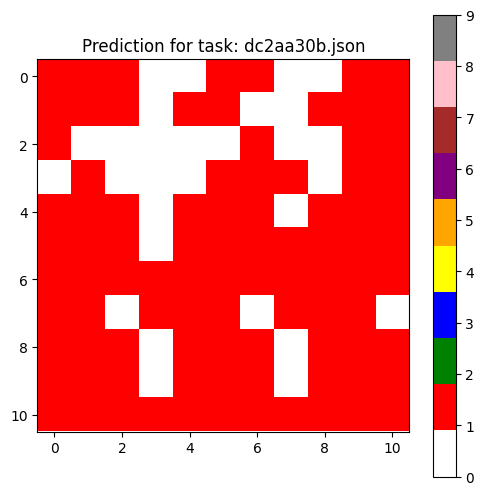

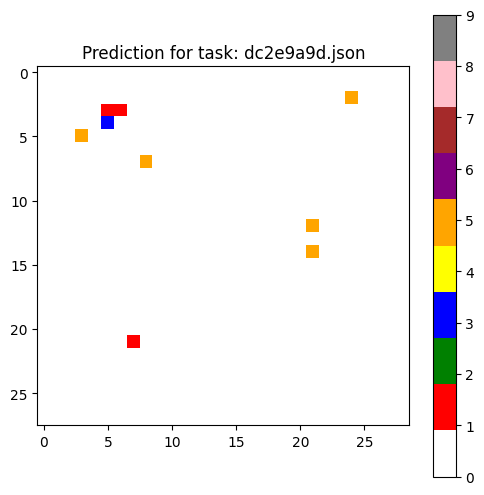

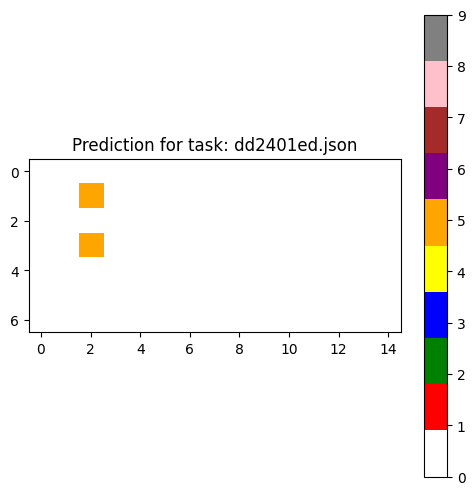

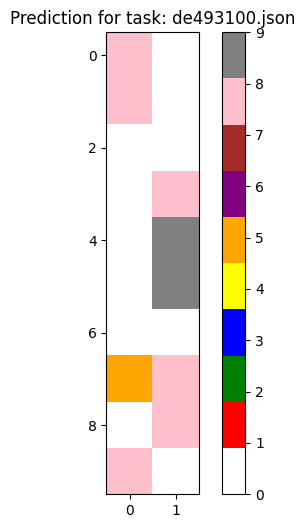

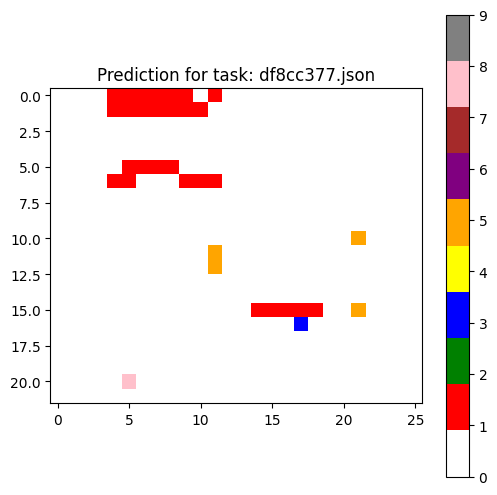

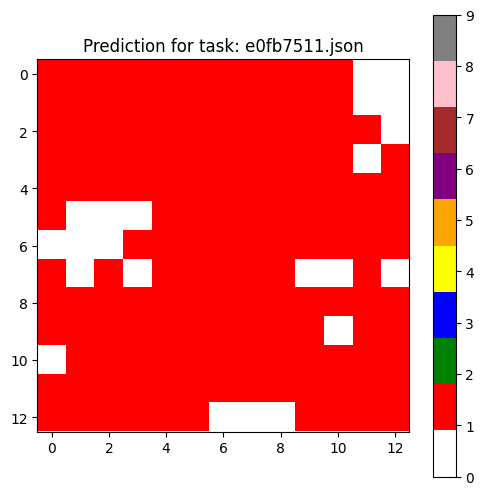

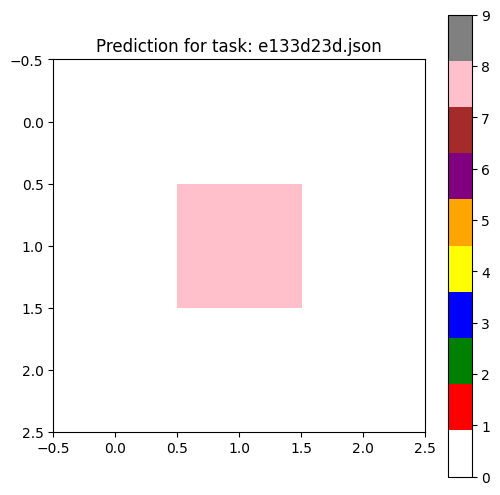

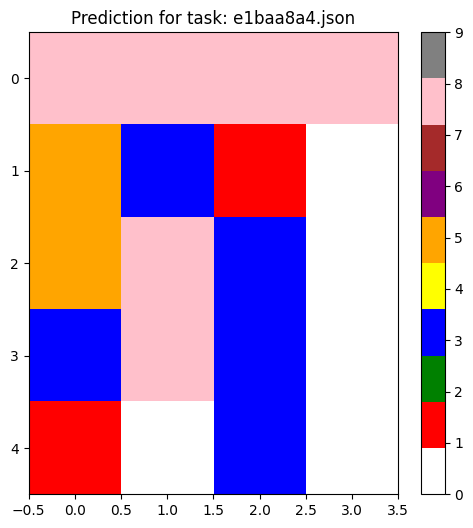

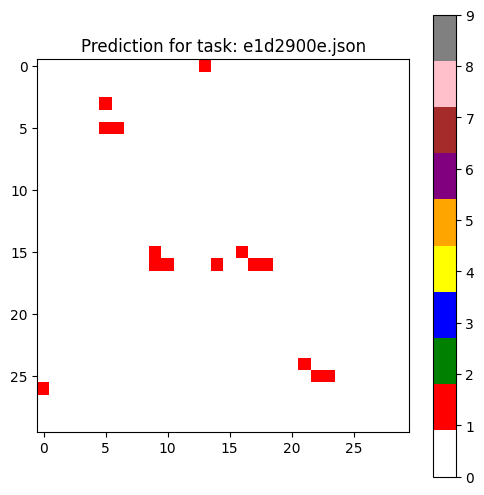

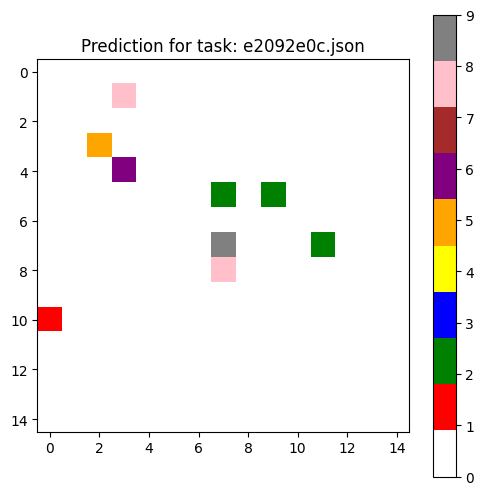

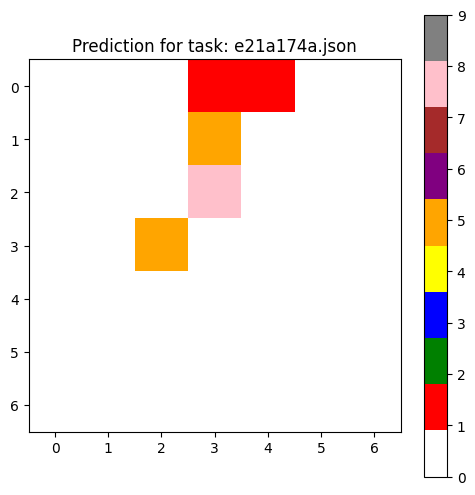

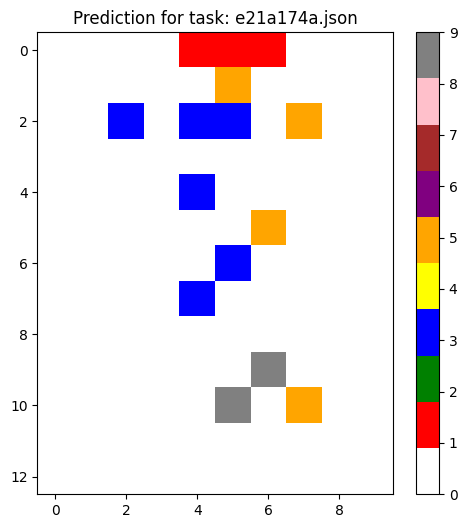

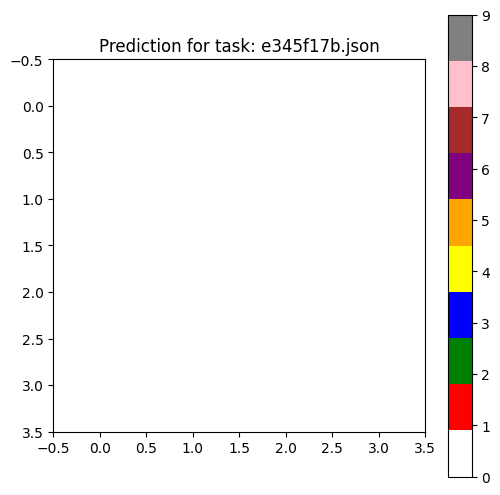

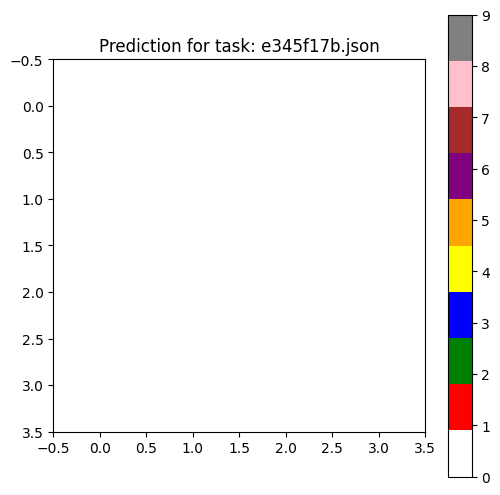

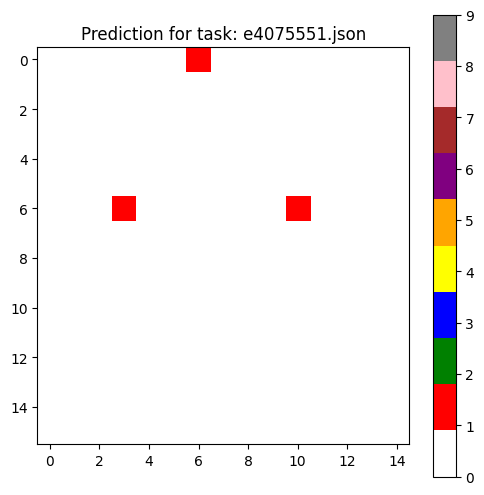

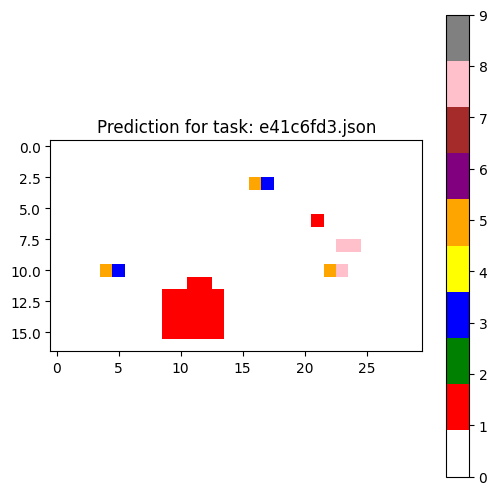

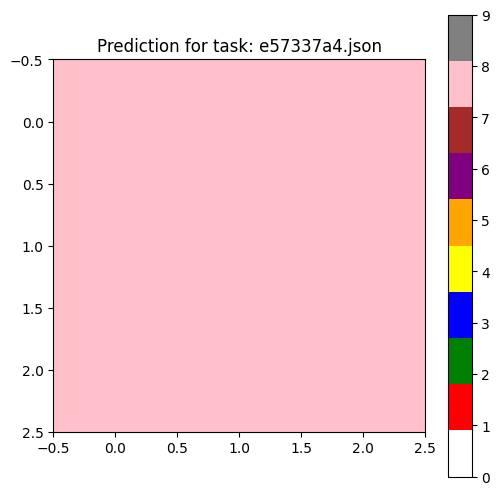

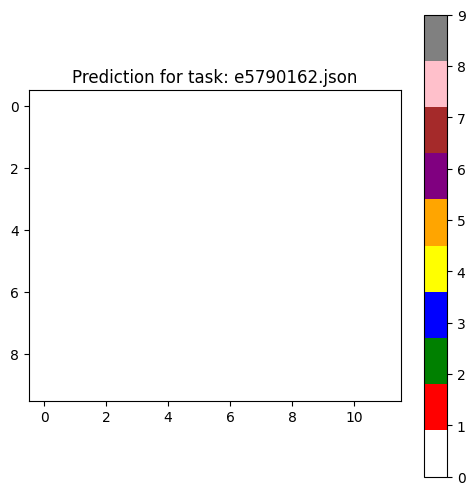

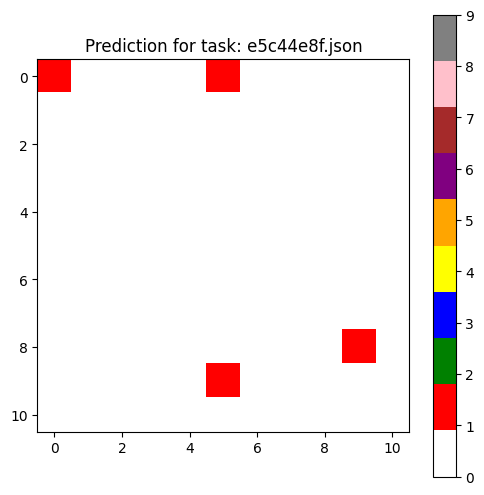

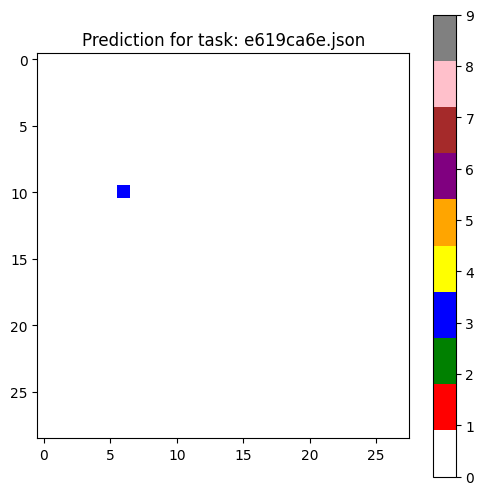

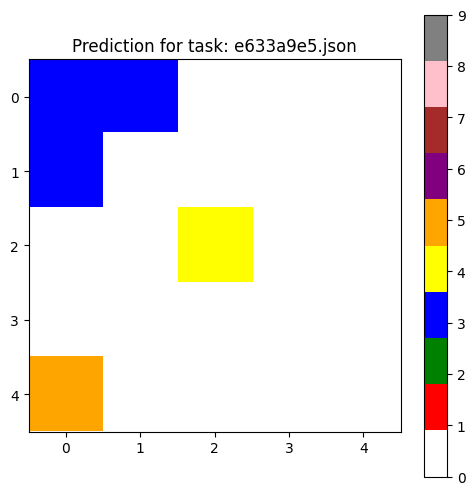

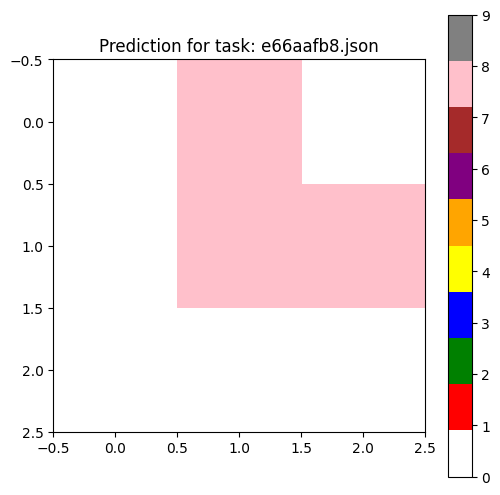

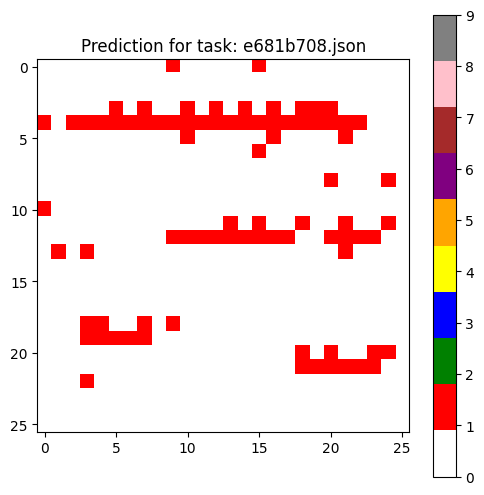

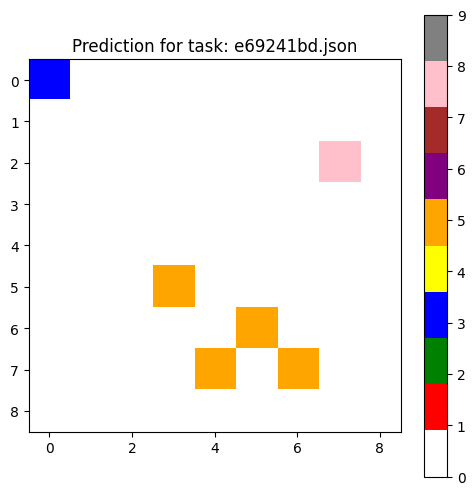

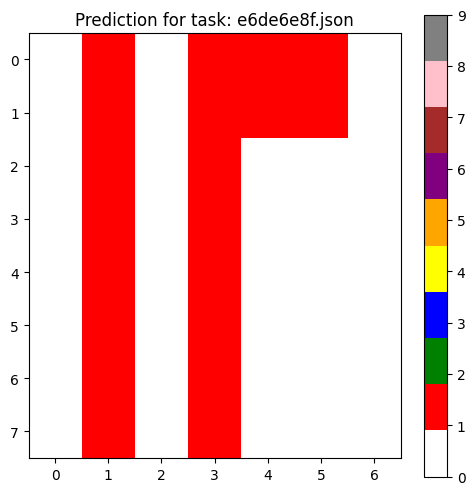

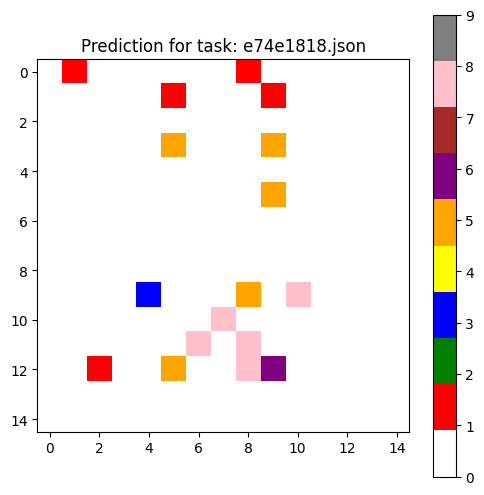

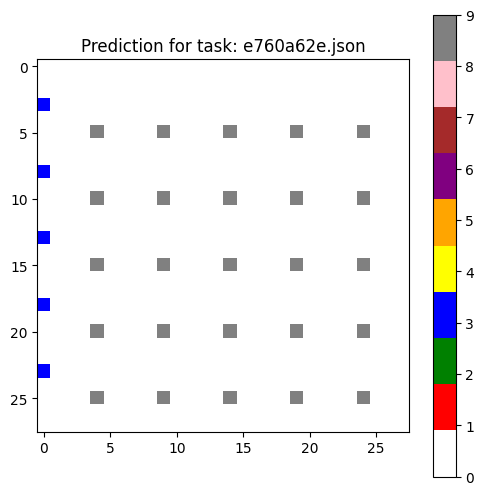

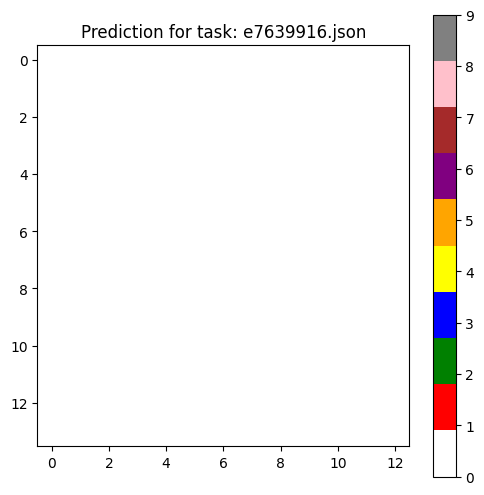

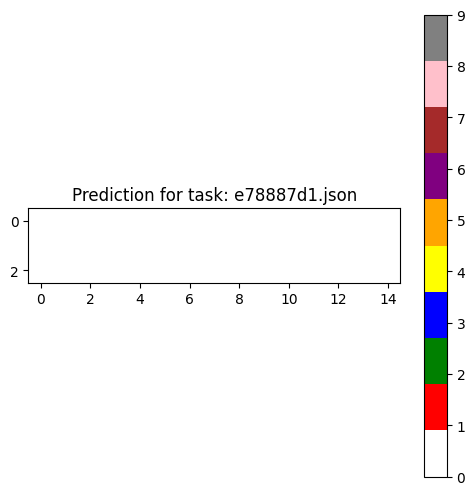

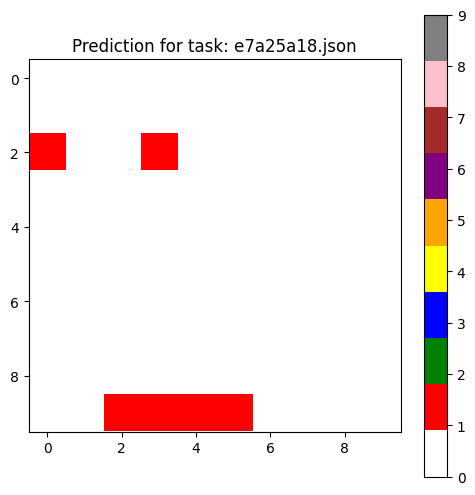

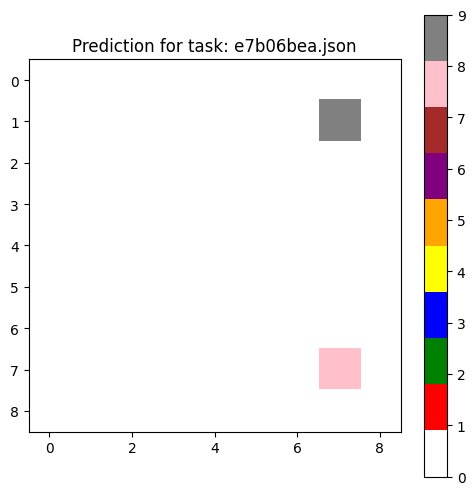

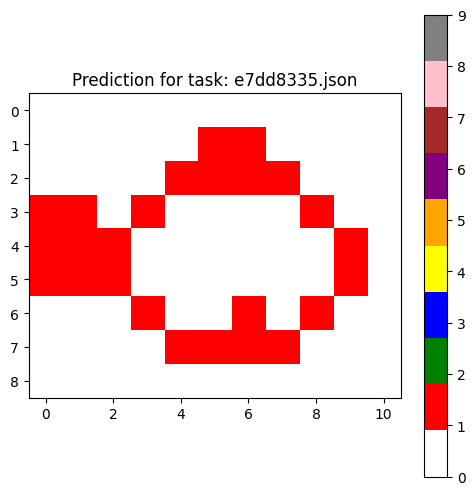

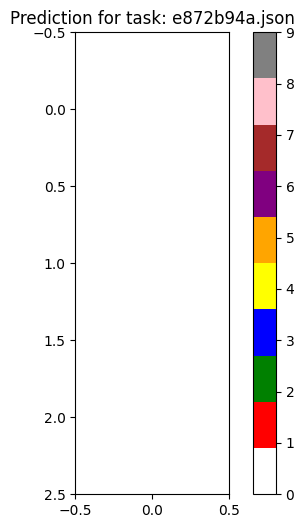

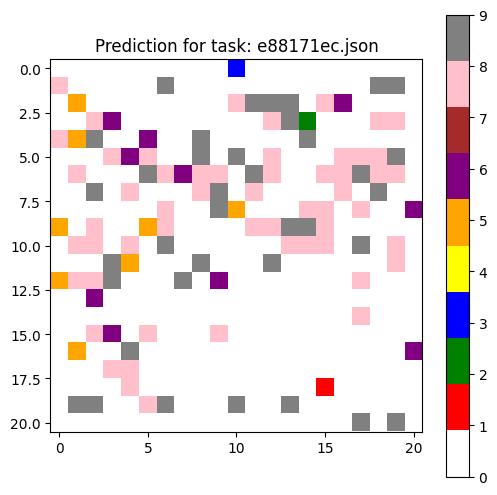

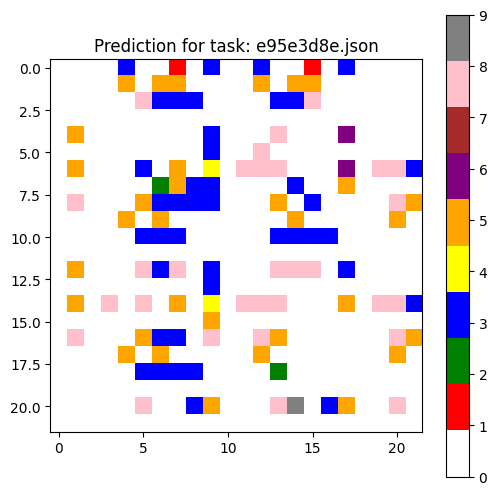

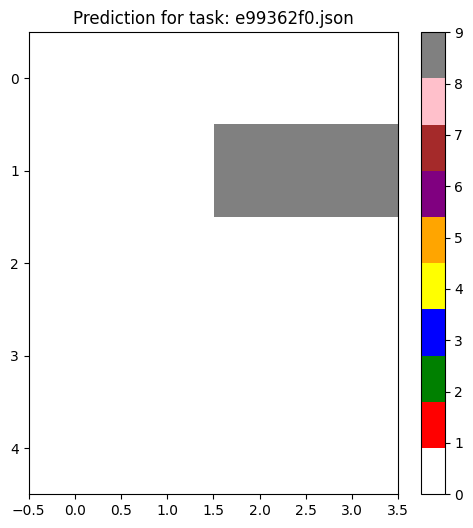

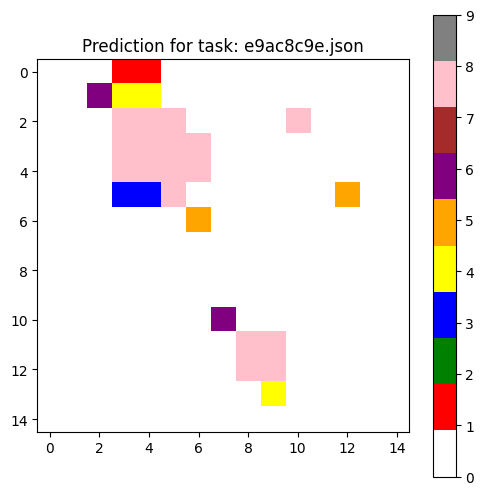

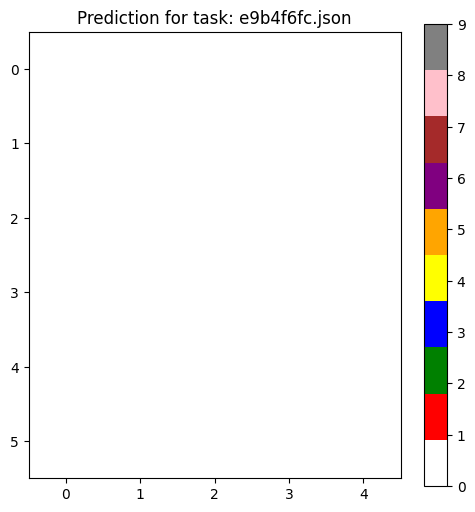

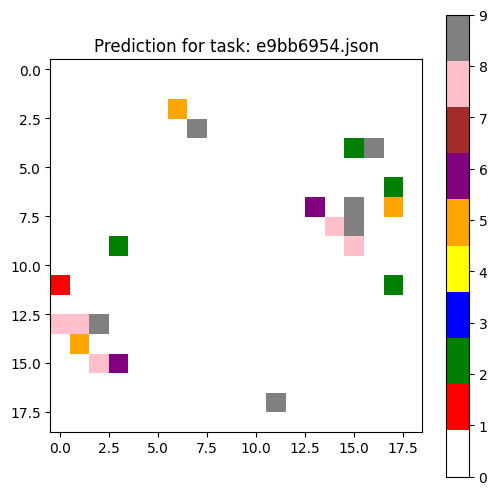

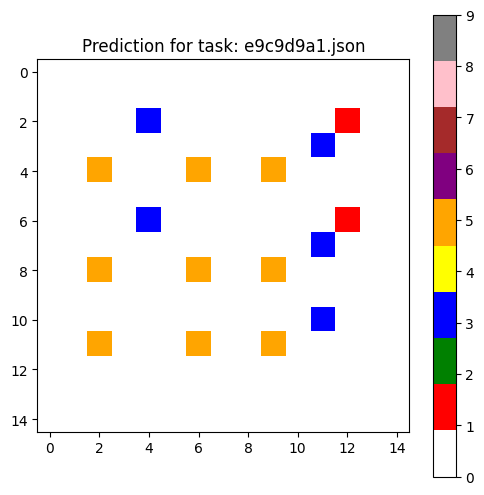

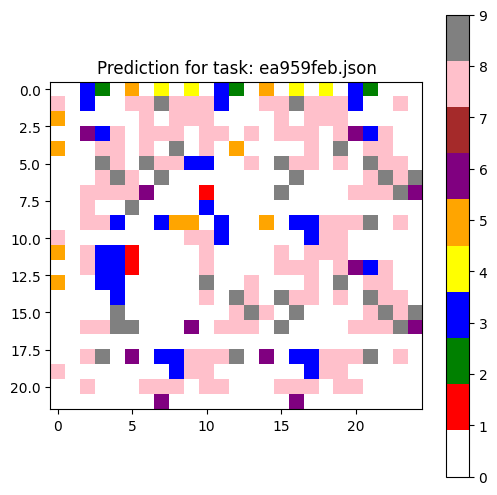

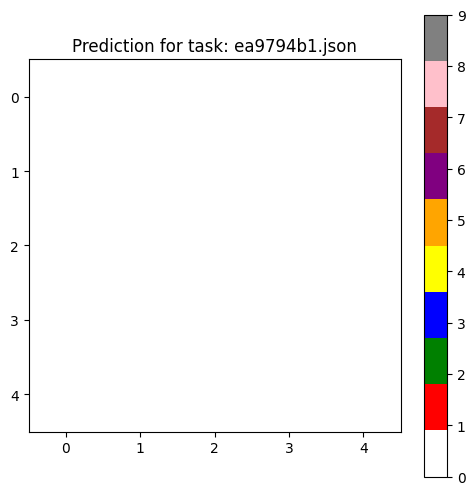

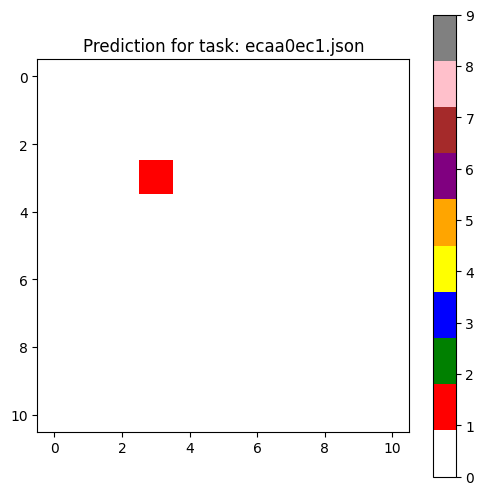

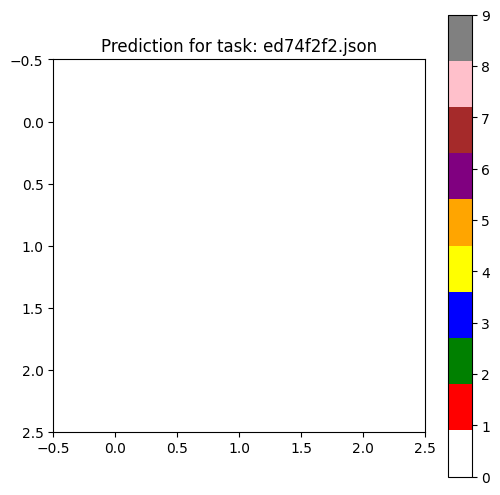

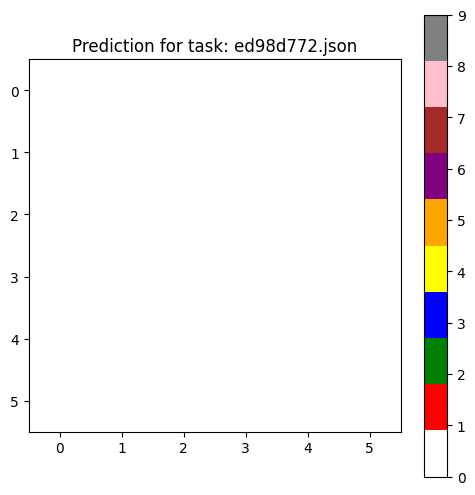

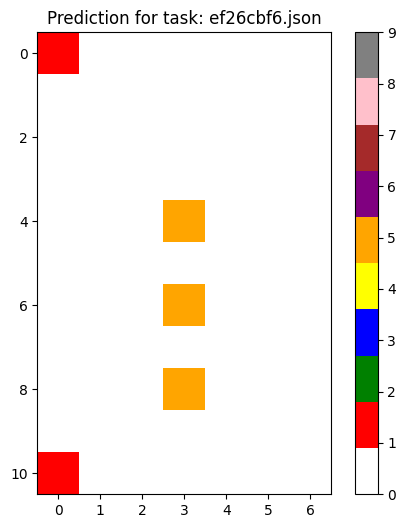

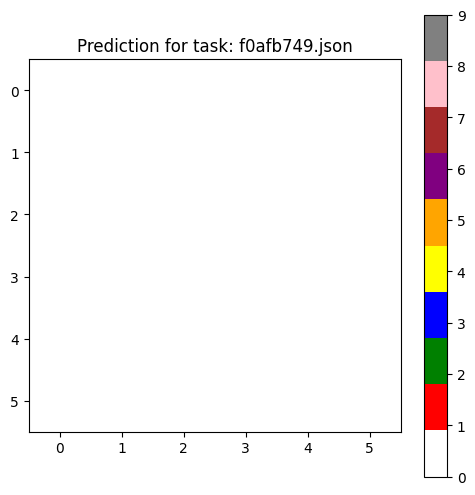

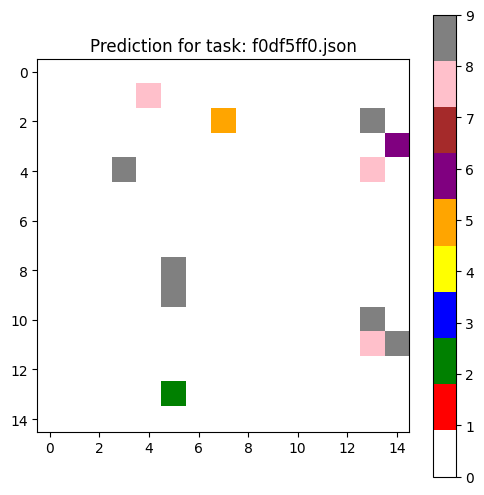

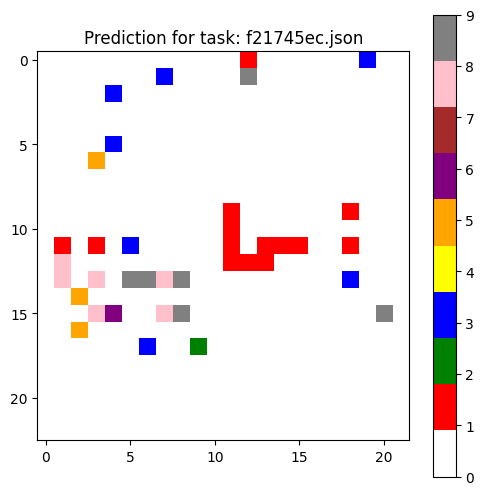

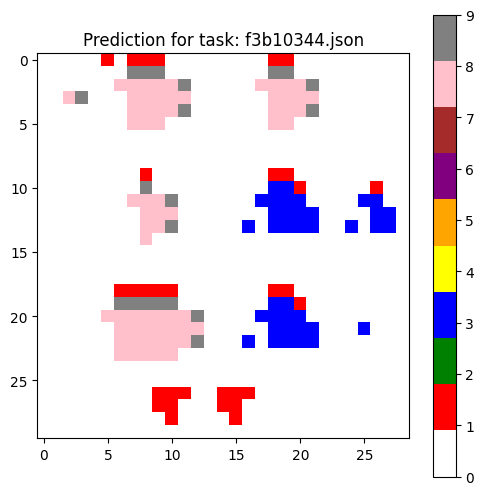

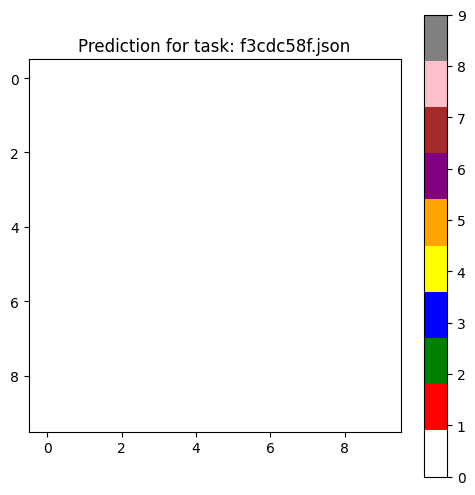

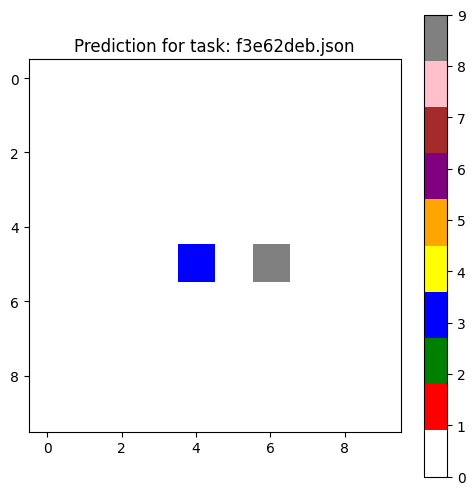

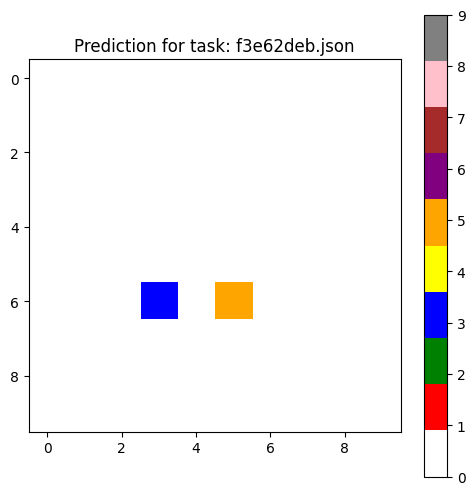

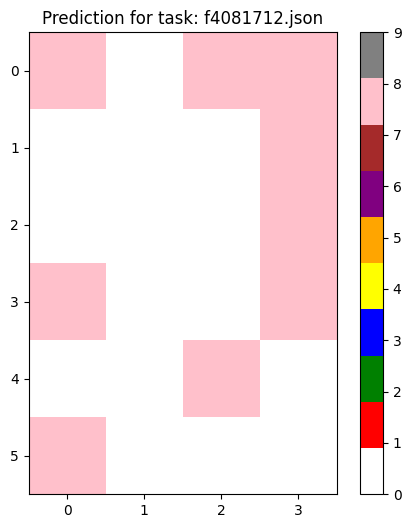

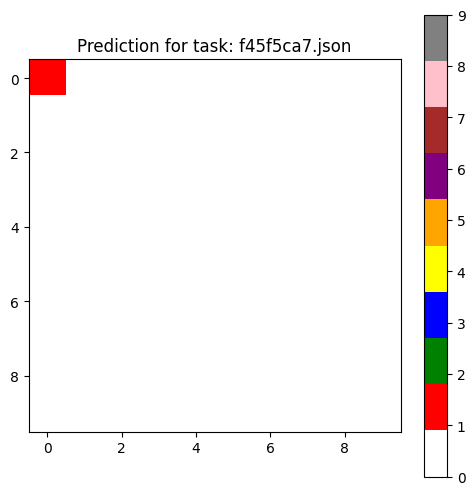

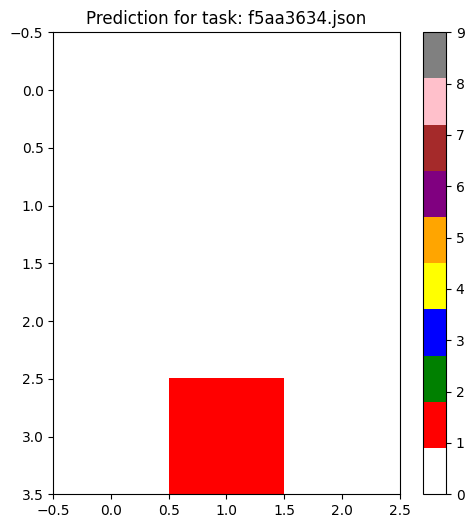

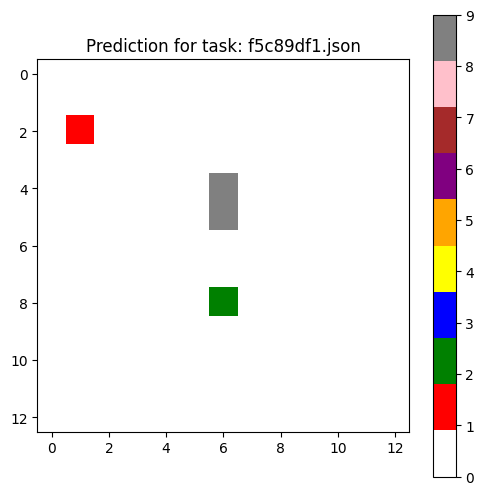

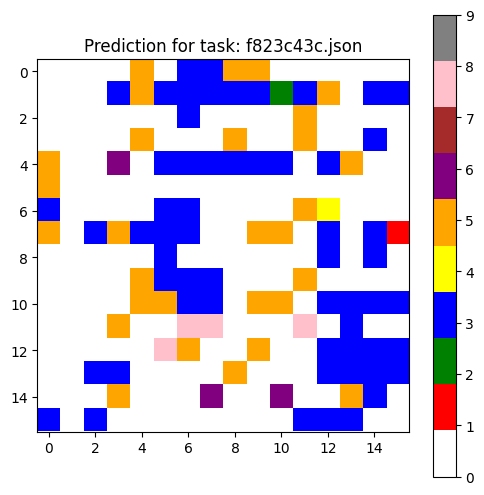

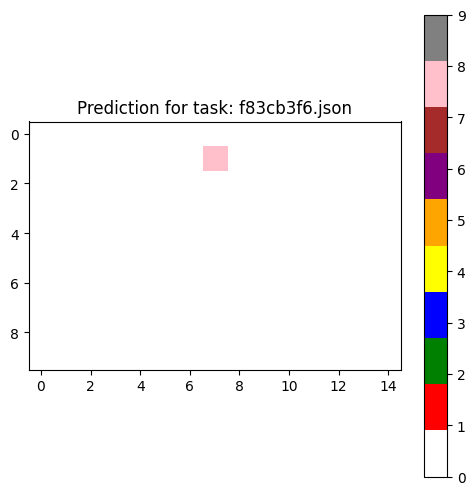

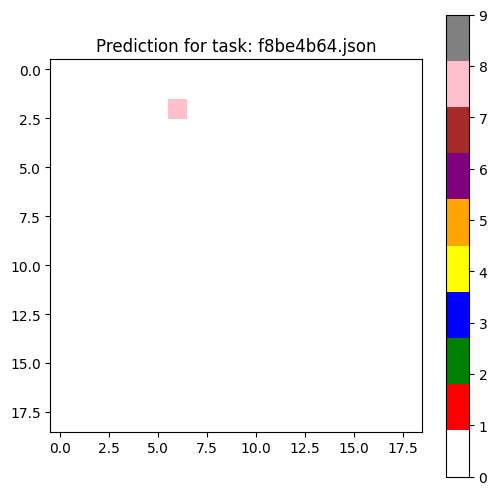

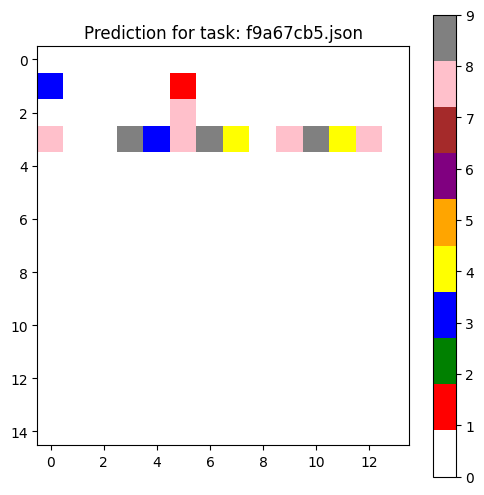

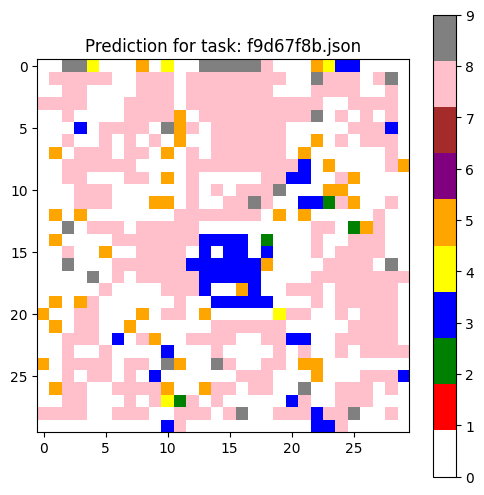

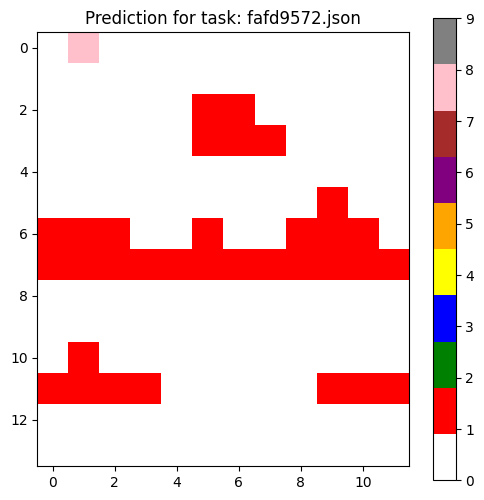

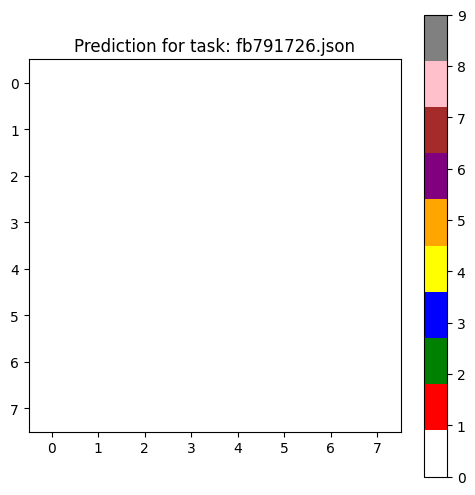

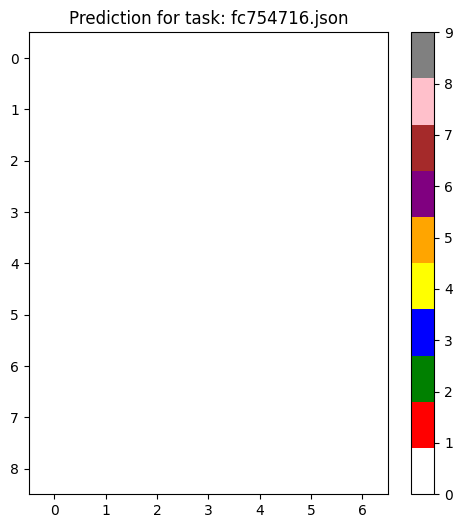

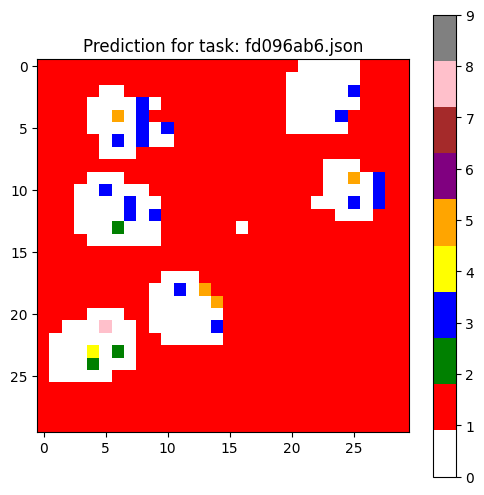

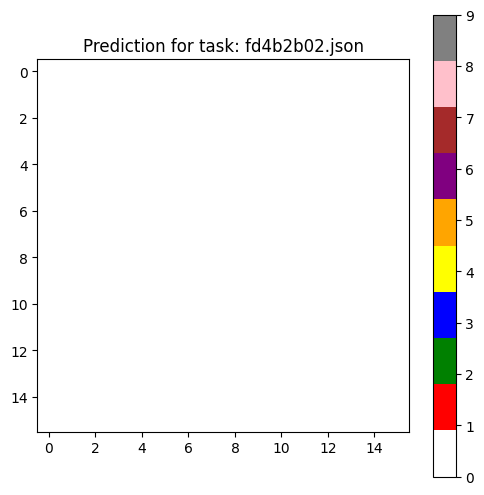

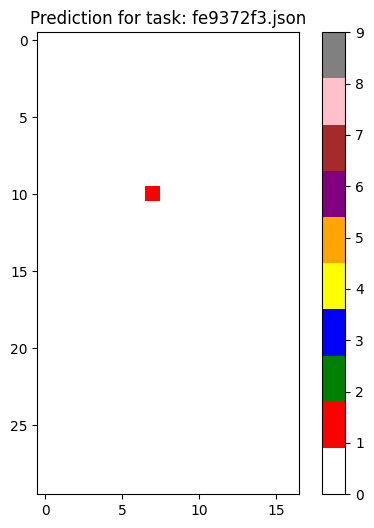

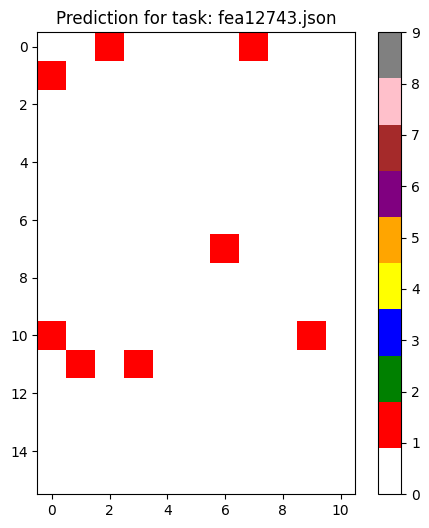

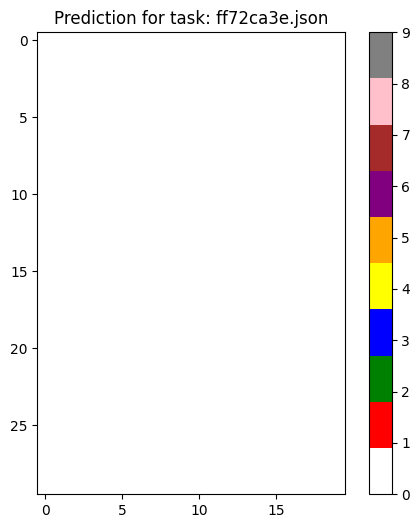

In [ ]:
def plot_test(prediction, task_id):
    """
    Plots the prediction grid for a given task ID.

    Args:
        prediction (np.ndarray): The predicted output grid.
        task_id (str): The ID of the task.
    """
    # Create a colormap with distinct colors for each class
    cmap = colors.ListedColormap(['white', 'red', 'green', 'blue', 'yellow', 'orange', 'purple', 'brown', 'pink', 'gray'])

    # Plot the prediction grid
    plt.figure(figsize=(6, 6))
    plt.imshow(prediction, cmap=cmap, vmin=0, vmax=9)  # Assuming 10 color classes
    plt.title(f"Prediction for task: {task_id}")
    plt.colorbar(ticks=range(10))  # Add a colorbar with ticks for each class
    plt.show()
# Paths
data_path = Path('/content/ARC-AGI/data')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
input_channels = 1
output_channels = 10  # Assuming 10 color classes
model = SimpleCNN(input_channels, output_channels).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Process each task in the training folder
all_task_ids = sorted(os.listdir(training_path))
for task_id in all_task_ids:
    task_file = str(training_path / task_id)
    with open(task_file, 'r') as f:
        task = json.load(f)

    # Prepare dataset and dataloader
    train_dataset = ARCDataset(task, mode='train')  # Use training mode for training data
    train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

    # Train the model using training data
    train_model(model, train_dataloader, criterion, optimizer, epochs=10)

# Process each task in evaluation folder
all_task_ids = sorted(os.listdir(evaluation_path))
for task_id in all_task_ids:
    task_file = str(evaluation_path / task_id)
    with open(task_file, 'r') as f:
        task = json.load(f)

    # Prepare dataset and dataloader
    test_dataset = ARCDataset(task, mode='test')
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)



    # Test predictions
    for test_sample in task['test']:
        input_grid = np.array(test_sample['input'], dtype=np.float32)
        # Get target shape from the 'output' key in the test sample
        target_shape = (1, len(test_sample['output']), len(test_sample['output'][0]))
        prediction = predict_model(model, input_grid, target_shape=np.array(test_sample['output']).shape) # Adding target shape
        plot_test(prediction, task_id)


